# 0.Introduction

## 0.1 Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from pandas import DataFrame
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import warnings
from sklearn import linear_model
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from keras.utils.vis_utils import plot_model
from tensorflow import keras
from sklearn.svm import SVR
import datetime
import seaborn as sns
from os import listdir
from os.path import isfile, join
from sklearn.preprocessing import StandardScaler, MinMaxScaler,FunctionTransformer, PowerTransformer, QuantileTransformer, RobustScaler
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import activations
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from IPython.display import display_html 
from re import VERBOSE
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from pyparsing.helpers import disable_diag
from scipy.stats.mstats import winsorize

warnings.filterwarnings("ignore", category= RuntimeWarning)
warnings.filterwarnings("ignore", category= FutureWarning)
set_config(display="diagram")

## 0.2 Variables

In [ ]:
#dataframe to save various results
results_mse = pd.DataFrame(columns=['modelName', 'train_mse', 'test_mse', 'difference'])
results_mae = pd.DataFrame(columns=['modelName', 'train_mae', 'test_mae', 'difference'])
results_r2score = pd.DataFrame(columns=['modelName', 'train_r2score', 'test_r2score', 'difference'])
results_evs = pd.DataFrame(columns=['modelName', 'train_evs', 'test_evs', 'difference'])

## 0.3 Functions

### -data preparation

In [ ]:
#checks missing data in %-tage in given dataset
def checkDataForNulls (dataset):
    percent_missing = dataset.isnull().sum() * 100 / len(dataset)
    missing_value_df = pd.DataFrame({'Column': dataset.columns,
                                 'percent_missing': percent_missing})
    print(missing_value_df)

In [ ]:
#show boxplot for dataset befroe modifications and after
def boxplot_compare_dist(df, y_before, y_after):
    f = plt.figure(figsize=(16,8))
    st = f.suptitle(f"{y_before} comparison", fontsize="x-large")
    ax1=plt.subplot(2,2,1)
    a = sns.distplot(df[y_before])
    plt.subplot(2,2,3)
    sns.boxplot(y=y_before, data = df)
    ax2=plt.subplot(2,2,2)
    b = sns.distplot(df [y_after])
    plt.subplot(2,2,4)
    sns.boxplot(y=y_after, data = df)
    a.title.set_text('before')
    b.title.set_text('after')
    plt.show()

In [ ]:
#transform specific column with requested tranfromer
def transform (transf, X_train, X_test, name, col):
  #train
  X_train_df = pd.DataFrame(X_train, columns = ['AT','V', 'AP', "RH"])
  X_train_df = X_train_df.drop(['AT','V'], axis=1)
  data_trans = transf.fit_transform(X_train_df) 
  data_trans_df = pd.DataFrame(data_trans, columns = ['AP', "RH"])

  #test
  X_test_df = pd.DataFrame(X_test, columns = ['AT','V', 'AP', "RH"])
  X_test_df = X_test_df.drop(['AT','V'], axis=1)
  data_trans_test = transf.transform(X_test_df)
  data_trans_test_df = pd.DataFrame(data_trans_test, columns = ['AP', "RH"])

  #show results
  compare_to_normal (X_train_df,data_trans_df, col, f'{name}_Train')
  compare_to_normal (X_test_df,data_trans_test_df, col, f'{name}_Test')
  return data_trans, data_trans_test

In [ ]:
#iterate over list of transformers and check specific column
def transform_list(X_train, X_test, col):
    rcpr_transformer = FunctionTransformer(lambda x: 1/x, validate = True)
    sqr_transformer = FunctionTransformer(lambda x: x ** (1 / 2), validate = True)
    exp_transformer = FunctionTransformer(lambda x: x **( 1 * 1.2), validate = True)
    yj_transformer = PowerTransformer(method = 'yeo-johnson', standardize = False)
    bc_transformer = PowerTransformer(method = 'box-cox', standardize = False)
    transformer_list=[rcpr_transformer,sqr_transformer, exp_transformer, yj_transformer, bc_transformer ]
    transformer_names = ["rcpr_transformer","sqr_transformer", "exp_transformer", "yj_transformer", "bc_transformer" ]
    for j in range(0, len(transformer_list)):
         transform(transformer_list[j] ,X_train, X_test, transformer_names[j], col) 

In [ ]:
def transform_y (y_train,y_test):
  y_target = y_train.to_numpy()
  y_tr_test = y_test.to_numpy()

  y_data = y_target.reshape(len(y_target), 1)
  y_data_test = y_tr_test.reshape(len(y_tr_test), 1)

  # QuantileTransformer to make bimodel to uniform
  quant_trans = QuantileTransformer(n_quantiles=300, output_distribution='uniform')

  y_trans = quant_trans.fit_transform(y_data)
  y_trans_test = quant_trans.transform(y_data_test)
  return y_target, y_trans,  y_tr_test, y_trans_test

In [ ]:
#plot specific column before modification and after modification in comparison to normal destribution
def compare_to_normal (df_before,df_after, col, name):
    f = plt.figure(figsize = (50, 10))
    st = f.suptitle(f"{col}_{name}", fontsize=30)
    plt.subplot(1, 4, 1)
    data = df_before[col]
    ax = sns.histplot(x=data, stat="density")
    mean = data.mean()
    std = data.std()
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = stats.norm.pdf(x, mean, std)
    plt.plot(x, p, color="black", linewidth=2)
    plt.xlabel(f'{col} before transformation', fontsize=20)
    plt.subplot(1, 4, 2)
    stats.probplot(df_before[col], dist = 'norm', plot = plt)
    plt.xlabel(f'{col} before transformation', fontsize=20)
    plt.subplot(1, 4, 3)
    data = df_after[col]
    ax = sns.histplot(x=data, stat="density")
    mean = data.mean()
    std = data.std()
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = stats.norm.pdf(x, mean, std)
    plt.plot(x, p, color="black", linewidth=2)
    plt.xlabel(f'{col} after transformation', fontsize=20)
    plt.subplot(1, 4, 4)
    stats.probplot(df_after[col], dist = 'norm', plot = plt)
    plt.xlabel(f'{col} after transformation', fontsize=20)
    plt.show()

In [ ]:
#split and impute dataset
def reset_t_t_split(df, imputer):
  X = df.iloc[:, :-1].values
  y= df.iloc[:, -1].values
  #split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
  #impute
  X_train_i = imputer.fit_transform(X_train)
  X_test_i = imputer.transform(X_test)
  return X_train_i, X_test_i, y_train, y_test

In [ ]:
# scale only
def scale (scaler, X_train_i, X_test_i, y_train, y_test ):
  #scale
  sc_x=scaler
  sc_y=scaler
  y_train_r = y_train.reshape(len(y_train), 1)
  y_test_r = y_test.reshape(len(y_test), 1)
  X_train_sc = sc_x.fit_transform(X_train_i)
  X_test_sc = sc_x.transform(X_test_i)
  y_train_sc = sc_y.fit_transform(y_train_r)
  y_test_sc = sc_y.transform(y_test_r)
  
  return  X_train_sc, X_test_sc, y_train_sc, y_test_sc, sc_y, y_test, y_train

In [ ]:
def transform_scale_RH (RH_transformer, df, scaler):
  X_train_o, X_test_o, y_train, y_test = reset_t_t_split(df, KNNImputer(n_neighbors=2))
  #train and test numpy array with transfromed RH col
 
  RH_train, RH_test = transform(RH_transformer,X_train_o, X_test_o, 'final_transform_box_cox', 'RH')

  RH_train_col = RH_train[:,[1]]
  X_train_mod = X_train_o[:,[0,1,2]]
  X_train_final_RH = np.append(X_train_mod, RH_train_col, axis=1)


  RH_test_col = RH_test[:,[1]]
  X_test_mod = X_test_o[:,[0,1,2]]
  X_test_final_RH = np.append(X_test_mod, RH_test_col, axis=1)

  X_train, X_test, y_train, y_test, sc_y, y_test_orig, y_train_orig = scale(scaler, X_train_final_RH, X_test_final_RH , y_train, y_test)
  return X_train, X_test, y_train, y_test, sc_y, y_test_orig, y_train_orig

### -model training

In [ ]:
#split dataset and preprocess data according to given pipeline
def split_impute_scale_pipe (df, pipe, imputer, winsorize_rh = False,winsorize_ap = False):
  pipe_s = define_pipeline_simple(RobustScaler())
  X = df.iloc[:, :-1].values
  y= df.iloc[:, -1].values
  #split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

  y_test_orig, y_train_orig = y_test, y_train

  X_train_i = imputer.fit_transform(X_train)
  X_test_i = imputer.transform(X_test)

  cols = ['AT', 'V', 'AP', 'RH']
  if winsorize_rh:
    X_train_i = winsorize_nparray(X_train_i, 3,  0.00135, 0)
    X_test_i = winsorize_nparray(X_test_i, 3,  0.00135, 0)
    
  if winsorize_ap:
    X_train_i= winsorize_nparray(X_train_i, 2,  0.00165, 0.015)
    X_test_i= winsorize_nparray(X_test_i, 2,  0.00165, 0.015)
    cols = ['AT', 'V', 'RH', 'AP']

  X_train_i = pd.DataFrame(X_train_i, columns = cols)
  X_test_i = pd.DataFrame(X_test_i, columns = cols)

  X_train_p = pipe.fit_transform(X_train_i)
  X_test_p = pipe.transform(X_test_i)

  pipe 

  y_train_r = y_train.reshape(len(y_train), 1)
  y_test_r = y_test.reshape(len(y_test), 1)
  y_train_p = pipe_s.fit_transform(y_train_r)
  y_test_p = pipe_s.transform(y_test_r)

  return X_train_p, X_test_p, y_train_p, y_test_p, pipe_s,  y_test_orig, y_train_orig

In [ ]:
#define pipeline with scaler only
def define_pipeline_simple(scaler):
  pipe_simple = Pipeline([
    ('scaler', scaler)
    ])
  return pipe_simple

In [ ]:
#define pipeline with transformer and scaler:

def define_pipeline_complex(scaler, rh_step, ap_step, is_rh = True, is_ap = True ):
  if is_rh:
    rh_pipe = Pipeline([('transformer_step', rh_step),
                        ('scaler', scaler)])
  else:
    rh_pipe = Pipeline([('scaler', scaler)])
  
  if is_ap:
    ap_pipe = Pipeline([('preprocess_step', ap_step),
                        ('scaler', scaler)])
  else:
    ap_pipe =  Pipeline([('scaler', scaler)])

  simple_pipe = define_pipeline_simple(RobustScaler())                        
  pipe = ColumnTransformer(
    [("RH_col"  , rh_pipe  , ["RH"]),
     ("AP_col", ap_pipe, ["AP"])
    ],
    remainder = simple_pipe
  )
  set_config(display="diagram")

  return pipe

In [ ]:
def winsorize_nparray(nparray, col_index, lower, upper):
  array_col =  nparray[ : , col_index]
  array_col_win = winsorize(array_col, (lower, upper))
  array_col_win_reshape = array_col_win.reshape(len(array_col_win), 1)
  combo = np.delete(nparray, col_index, 1)
  nparray = np.c_[combo, array_col_win_reshape]
  return nparray

#### -ML model training

In [ ]:
#train ML model, evaluate, save to results dataframe
def train_report_hist_pipe (name,regressor, pipe):
    model = regressor
    model.fit(X_train, y_train)
    results = pd.DataFrame(columns=['modelName', 'mse', 'mae',  'evs', 'r2'])


    r_sq = model.score(X_train, y_train)
    print(f"coefficient of determination: {r_sq}")
#train
    y_pred_train = pipe.inverse_transform(model.predict(X_train).reshape(-1,1))

    r2_score_train =  r2_score(y_train_orig, y_pred_train)
    evs_train = explained_variance_score(y_train_orig, y_pred_train)
    mae_train =  mean_absolute_error(y_train_orig, y_pred_train)
    mse_train = mean_squared_error(y_train_orig, y_pred_train)
#test
    y_pred_test = pipe.inverse_transform(model.predict(X_test).reshape(-1,1))
  
    r2_score_test =  r2_score(y_test_orig, y_pred_test)
    evs_test = explained_variance_score(y_test_orig, y_pred_test)
    mae_test =  mean_absolute_error(y_test_orig, y_pred_test)
    mse_test = mean_squared_error(y_test_orig, y_pred_test)
#difference
    diff_r2 = r2_score_train - r2_score_test
    diff_evs = evs_train - evs_test
    diff_mae = mae_test - mae_train
    diff_mse = mse_test - mse_train

    results_r2score.loc[len(results_r2score.index)] = [name, round( r2_score_train*100,3), round( r2_score_test*100,3), round( diff_r2*100,3)]
    results_evs.loc[len(results_evs.index)] = [name, round( evs_train*100,3), round( evs_test*100,3), round( diff_evs*100,3)]
    results_mae.loc[len(results_mae.index)] = [name, round( mae_train,3), round( mae_test,3), round( diff_mae,3)]
    results_mse.loc[len(results_mse.index)] = [name, round( mse_train,3), round( mse_test,3), round( diff_mse,3)]

    results.loc[len(results.index)] = [f'{name}_train', round( mse_train,3), round( mae_train,3),round( evs_train*100,3),round( r2_score_train*100,3) ]
    results.loc[len(results.index)] = [f'{name}_test', round( mse_test,3), round( mae_test,3),round( evs_test*100,3),round( r2_score_test*100,3) ]

    print (results)

#### -ANN model training

In [ ]:
#define model architecture and complie model
def define_model (name, opt, n_layers, unt, input_vec_len):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(units = unt, activation = 'relu', input_shape = (input_vec_len,)))
  for n in range(1, n_layers):
     model.add(tf.keras.layers.Dense(units = unt, activation = 'relu'))
  model.add(tf.keras.layers.Dense(units = 1))
  model.compile(optimizer = opt, loss="mse",  metrics = ['mae'])
  return model

In [ ]:
#evaluate model
def evaluate_model_pipe (name, pipe, pat,  n_layers, unt, batch, opt, ep,  n_folds = 5):
  histories = list()
  early_stopping_monitor = EarlyStopping(patience=pat)
  checkpointer = ModelCheckpoint(
      filepath = f'/content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_{name}.hdf5',
      verbose = 1,
      save_best_only = True
  )
  input_vec_len = X_train.shape[1]
  name = define_model(name, opt, n_layers, unt, input_vec_len)
  history = name.fit(X_train, y_train, epochs = ep, batch_size = batch, verbose = 0, validation_data=(X_test, y_test), callbacks= [early_stopping_monitor, checkpointer])
  histories.append(history)
  _y_pred_test = name.predict(X_test).reshape(-1,1)
  y_pred_test = pipe.inverse_transform(_y_pred_test)
  y_pred_train = pipe.inverse_transform(name.predict(X_train).reshape(-1,1))
  return histories, y_pred_test, y_pred_train

In [ ]:
#plot diagnostic learning curves
def show_plots (histories, name):
  f = plt.figure(figsize=(30,4))
  st = f.suptitle(name, fontsize="x-large")

  plt.subplot(1,2,1)
  # plot loss during training
  plt.title('Loss (Mean Squared Error)')
  plt.plot(histories[0].history['loss'], label='train mse')
  plt.plot(histories[0].history['val_loss'], label='test mse')
  ax = plt.gca()
  ax.get_yaxis().set_visible(False)
  plt.legend()

  plt.subplot (1,2,2)
  plt.title('Mean Absolute Error')
  plt.plot(histories[0].history['mae'], label='train mae')
  plt.plot(histories[0].history['val_mae'], label='test mae')
  axes = plt.gca()
  axes.get_yaxis().set_visible(False)
  plt.legend()

  plt.savefig(f"{name} model results.pdf") 
  plt.show()

In [ ]:
#count results and save to dataframe
def results(name,  y_pred_test,  y_pred_train):
  r2_score_train = round(r2_score(y_train_orig, y_pred_train)*100,3)
  evs_train = round(explained_variance_score(y_train_orig, y_pred_train)*100,3)
  mae_train = mean_absolute_error(y_train_orig, y_pred_train)
  mse_train = mean_squared_error(y_train_orig, y_pred_train)

  r2_score_test = round(r2_score(y_test_orig, y_pred_test)*100,3)
  evs_test = round(explained_variance_score(y_test_orig, y_pred_test)*100,3)
  mae_test = mean_absolute_error(y_test_orig, y_pred_test)
  mse_test = mean_squared_error(y_test_orig, y_pred_test)

  #difference
  diff_r2 = r2_score_train - r2_score_test
  diff_evs = evs_train - evs_test
  diff_mae = mae_test - mae_train
  diff_mse = mse_test - mse_train

  results_r2score.loc[len(results_r2score.index)] = [name, r2_score_train, r2_score_test, round(diff_r2,3)]
  results_evs.loc[len(results_evs.index)] = [name, evs_train, evs_test, round( diff_evs,3)]
  results_mae.loc[len(results_mae.index)] = [name, round( mae_train,3), round( mae_test,3), round( diff_mae,3)]
  results_mse.loc[len(results_mse.index)] = [name, round( mse_train,3), round( mse_test,3), round( diff_mse,3)]

  results = pd.DataFrame(columns = ['type', 'mean_squared_error', 'mean_absolute_error',  'r2_score', 'e_v_score'])
  results.loc[0] = [f"train:_{name}", round( mse_train,3),round( mae_train,3), r2_score_train ,evs_train]
  results.loc[1] = [f"test:_{name}",  round( mse_test,3) , round( mae_test,3) , r2_score_test ,evs_test]
  results.loc[2] = [f"{name}", round( diff_mse,3) , round( diff_mae,3) , round( diff_r2,3) ,round( diff_evs,3)]

  print(results)
  return results

In [ ]:
# complete run from model training, evaluation, vizualization and resalts saving
def complete_run (name, pipe,ep = 450, pat = 50, opt = 'adam', n_layers = 1, unt = 6, batch = 256):

  histories, y_pred_test, y_pred_train = evaluate_model_pipe (name, pipe, pat, n_layers, unt, batch, opt, ep,  n_folds = 5)

  show_plots(histories, name)
  
  data_res = results(name,  y_pred_test,  y_pred_train)
  data_res.to_csv(f'/content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/results/{name}_results.csv', index=False) 

In [ ]:
#upload results from path and save to main results df
def upload_save_results(df):
  name = df.loc[2]['type']
  r2_score_train = df.loc[0]['r2_score']
  evs_train = df.loc[0]['e_v_score']
  mae_train = df.loc[0]['mean_absolute_error']
  mse_train = df.loc[0]['mean_squared_error']

  r2_score_test = df.loc[1]['r2_score']
  evs_test = df.loc[1]['e_v_score']
  mae_test = df.loc[1]['mean_absolute_error']
  mse_test = df.loc[1]['mean_squared_error']

    #difference
  diff_r2 = df.loc[2]['r2_score']
  diff_evs = df.loc[2]['e_v_score']
  diff_mae = df.loc[2]['mean_absolute_error']
  diff_mse = df.loc[2]['mean_squared_error']

  results_r2score.loc[len(results_r2score.index)] = [name, r2_score_train, r2_score_test, diff_r2]
  results_evs.loc[len(results_evs.index)] = [name, evs_train, evs_test, diff_evs]
  results_mae.loc[len(results_mae.index)] = [name, mae_train, mae_test, diff_mae]
  results_mse.loc[len(results_mse.index)] = [name, mse_train, mse_test, diff_mse]

In [ ]:
#update results from saved files
def update_results(isFinal = False):
  mypath = '/content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/results'
  if isFinal:
    mypath = '/content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/results_final'
  onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
  for file in onlyfiles:
    df = pd.read_csv(f"{mypath}/{file}")
    upload_save_results(df)

In [ ]:
#save model as json file
def save_model_as_json(model,name):
  model_json = model.to_json()
  with open(f'/content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-classifier-model_{name}.json', 'w') as json_file:
    json_file.write(model_json)

### -show results

In [ ]:
def percent_graph (df, test):
  N = len(df.iloc[:10])
  new_df = df.sort_values(test, ascending=True).iloc[:10]
  ind = np.arange(N) 
  name = new_df['modelName'].head(12)
  # Figure Size
  fig, ax = plt.subplots(figsize =(20, 7))
  ax.barh(name, new_df[test].values.tolist(), color = 'orange')
  ax.barh(name, new_df['difference'].values.tolist(), left = new_df[test].values.tolist())
  for bar, disease in zip(ax.patches,new_df[test].values.tolist()):
      ax.text(0.3, bar.get_y()+bar.get_height()/2, disease, color = 'white', fontsize=15, ha = 'left', va = 'center') 
  plt.show()

In [ ]:
def failure_graph (df, train, test):
  N = len(df)
  new_df = df.sort_values(test, ascending=False)
  ind = np.arange(N) 
  name = new_df['modelName'].head(12)
  # Figure Size
  fig, ax = plt.subplots(figsize =(20, 7))
  ax.barh(name, new_df[train].values.tolist())
  ax.barh(name, new_df['difference'].values.tolist(), left = new_df[train].values.tolist())
  for bar, disease in zip(ax.patches,new_df[test].values.tolist()):
    ax.text(0.3, bar.get_y()+bar.get_height()/2, disease, color = 'orange',fontsize=15, ha = 'left', va = 'center') 
  plt.show()

In [ ]:
def show_results(isGraph = True):
    new_results_mse = results_mse.sort_values('test_mse', ascending=True)
    new_results_mae = results_mae.sort_values('test_mae', ascending=True)
    new_results_r2score = results_r2score.sort_values('test_r2score', ascending=False)
    new_results_evs = results_evs.sort_values('test_evs', ascending=False)

    df1_styler = new_results_mse.style.set_table_attributes('border="1" class="dataframe table table-hover table-bordered" style="display:inline"').set_precision(3).set_caption('MSE')
    df2_styler = new_results_mae.style.set_table_attributes('border="1" class="dataframe table table-hover table-bordered" style="display:inline"').set_precision(3).set_caption('MAE')
    df3_styler = new_results_r2score.style.set_table_attributes('border="1" class="dataframe table table-hover table-bordered" style="display:inline"').set_precision(3).set_caption('r2score')
    df4_styler = new_results_evs.style.set_table_attributes('border="1" class="dataframe table table-hover table-bordered" style="display:inline"').set_precision(3).set_caption('EVS')
    
    display_html(df1_styler._repr_html_()+"____\n"+df2_styler._repr_html_()+"____"+df3_styler._repr_html_()+"____"+df4_styler._repr_html_(), raw=True)

    m_mse = new_results_mse['modelName'].to_list()
    tr_mse = new_results_mse['train_mse'].to_list()
    te_mse = new_results_mse['test_mse'].to_list()

    m_mae = new_results_mae['modelName'].to_list()
    tr_mae = new_results_mae['train_mae'].to_list()
    te_mae = new_results_mae['test_mae'].to_list()

    m_r2score = new_results_r2score['modelName'].to_list()
    tr_r2score = new_results_r2score['train_r2score'].to_list()
    te_r2score = new_results_r2score['test_r2score'].to_list()

    m_evs = new_results_evs['modelName'].to_list()
    tr_evs = new_results_evs['train_evs'].to_list()
    te_evs = new_results_evs['test_evs'].to_list()

    f = plt.figure(figsize=(40,15))
    st = f.suptitle('Results', fontsize="x-large")

    if isGraph:
      failure_graph(results_mse, 'train_mse', 'test_mse')
      failure_graph(results_mae, 'train_mae', 'test_mae')
      percent_graph (results_evs, 'test_evs')
      percent_graph (results_r2score, 'test_r2score')
    
    

# 3.ANN model tuning

## 3.1 Modifying model architecture in combination with optimizers

### SGD


Epoch 1: val_loss improved from inf to 0.34818, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_2_units:_6.hdf5

Epoch 2: val_loss improved from 0.34818 to 0.31335, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_2_units:_6.hdf5

Epoch 3: val_loss improved from 0.31335 to 0.28597, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_2_units:_6.hdf5

Epoch 4: val_loss improved from 0.28597 to 0.26040, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_2_units:_6.hdf5

Epoch 5: val_loss improved from 0.26040 to 0.23303, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_2_uni

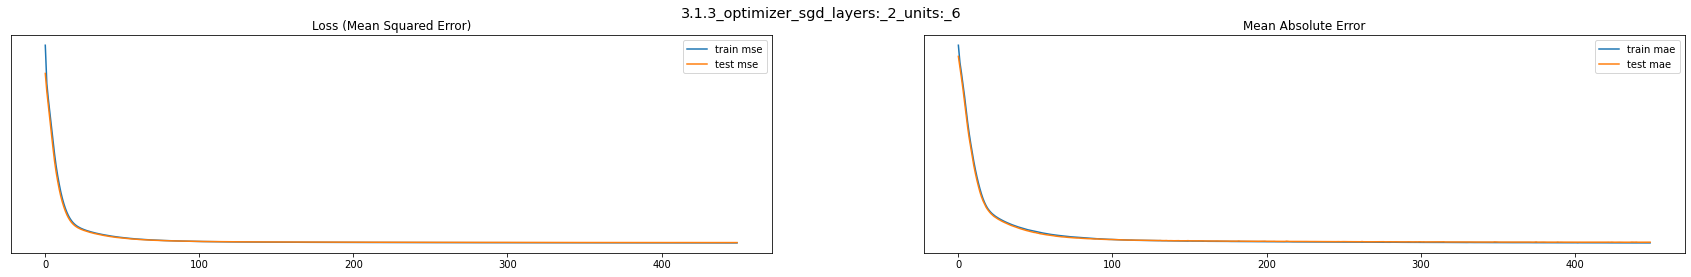

                                            type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_2_units:_6              17.977   
1   test:_3.1.3_optimizer_sgd_layers:_2_units:_6              18.514   
2         3.1.3_optimizer_sgd_layers:_2_units:_6               0.537   

   mean_absolute_error  r2_score  e_v_score  
0                3.302    93.810     93.814  
1                3.343    93.685     93.689  
2                0.040     0.125      0.125  

Epoch 1: val_loss improved from inf to 0.25672, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_2_units:_8.hdf5

Epoch 2: val_loss improved from 0.25672 to 0.21266, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_2_units:_8.hdf5

Epoch 3: val_loss improved from 0.21266 to 0.17028, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/

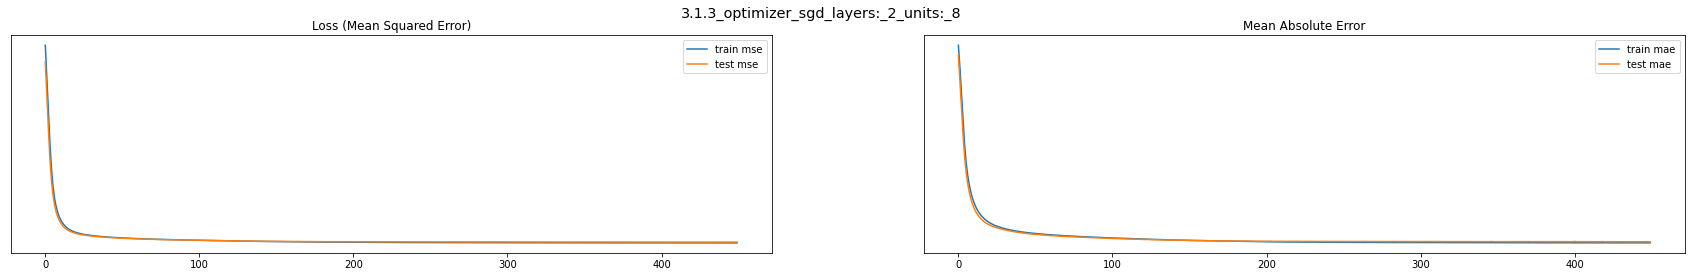

                                            type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_2_units:_8              17.527   
1   test:_3.1.3_optimizer_sgd_layers:_2_units:_8              18.398   
2         3.1.3_optimizer_sgd_layers:_2_units:_8               0.871   

   mean_absolute_error  r2_score  e_v_score  
0                3.247    93.965     93.965  
1                3.303    93.724     93.725  
2                0.056     0.241      0.240  

Epoch 1: val_loss improved from inf to 0.34761, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_2_units:_16.hdf5

Epoch 2: val_loss improved from 0.34761 to 0.29250, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_2_units:_16.hdf5

Epoch 3: val_loss improved from 0.29250 to 0.24518, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Projec

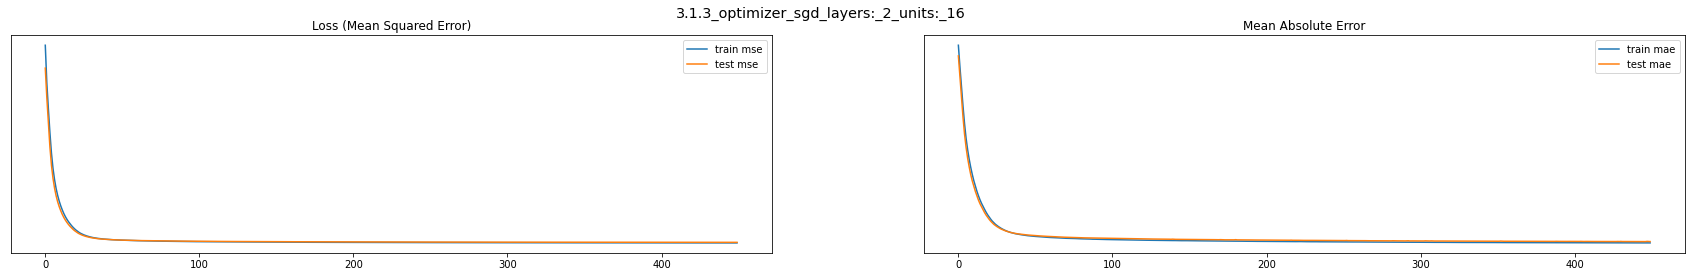

                                             type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_2_units:_16              17.183   
1   test:_3.1.3_optimizer_sgd_layers:_2_units:_16              18.060   
2         3.1.3_optimizer_sgd_layers:_2_units:_16               0.877   

   mean_absolute_error  r2_score  e_v_score  
0                3.204    94.084     94.084  
1                3.280    93.840     93.840  
2                0.076     0.244      0.244  

Epoch 1: val_loss improved from inf to 0.23298, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_2_units:_32.hdf5

Epoch 2: val_loss improved from 0.23298 to 0.15990, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_2_units:_32.hdf5

Epoch 3: val_loss improved from 0.15990 to 0.10857, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Pr

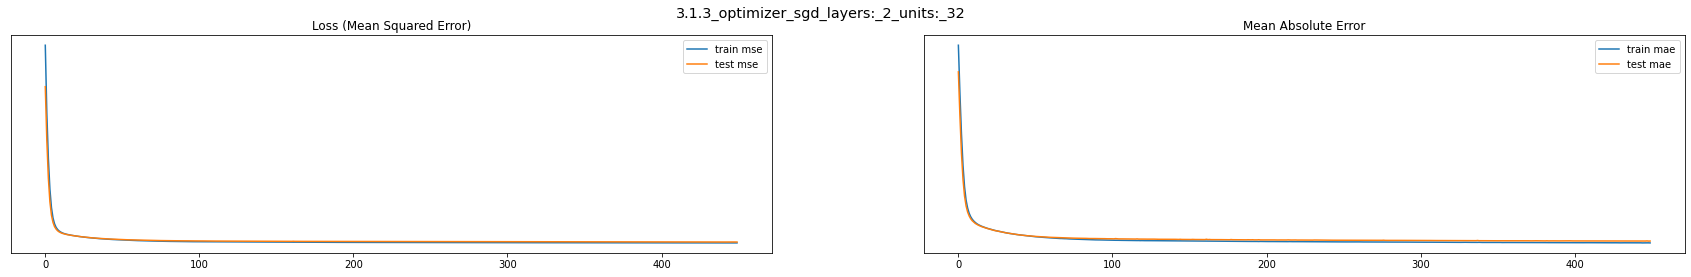

                                             type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_2_units:_32              16.638   
1   test:_3.1.3_optimizer_sgd_layers:_2_units:_32              17.613   
2         3.1.3_optimizer_sgd_layers:_2_units:_32               0.975   

   mean_absolute_error  r2_score  e_v_score  
0                3.146    94.271     94.272  
1                3.237    93.992     93.993  
2                0.091     0.279      0.279  

Epoch 1: val_loss improved from inf to 0.20544, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_2_units:_64.hdf5

Epoch 2: val_loss improved from 0.20544 to 0.13281, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_2_units:_64.hdf5

Epoch 3: val_loss improved from 0.13281 to 0.08487, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Pr

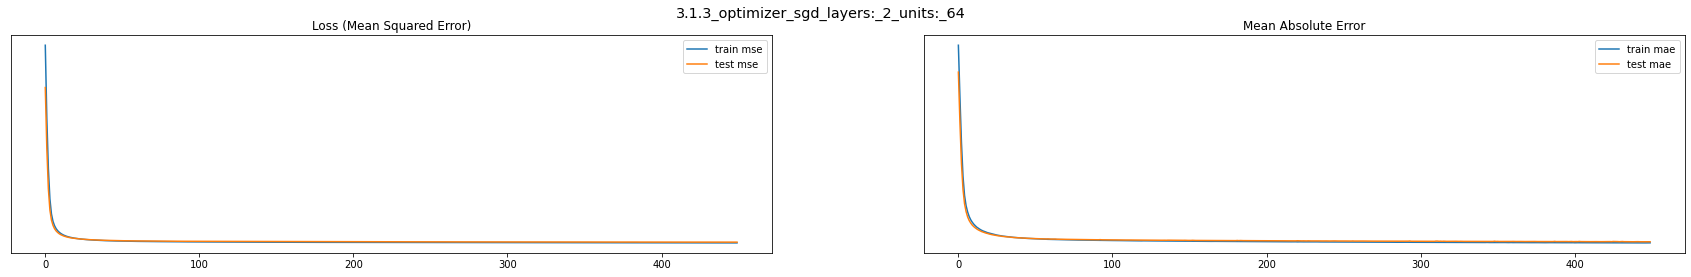

                                             type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_2_units:_64              16.454   
1   test:_3.1.3_optimizer_sgd_layers:_2_units:_64              17.195   
2         3.1.3_optimizer_sgd_layers:_2_units:_64               0.741   

   mean_absolute_error  r2_score  e_v_score  
0                3.119    94.335     94.335  
1                3.171    94.135     94.135  
2                0.052     0.200      0.200  

Epoch 1: val_loss improved from inf to 0.16977, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_2_units:_128.hdf5

Epoch 2: val_loss improved from 0.16977 to 0.08112, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_2_units:_128.hdf5

Epoch 3: val_loss improved from 0.08112 to 0.04606, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_

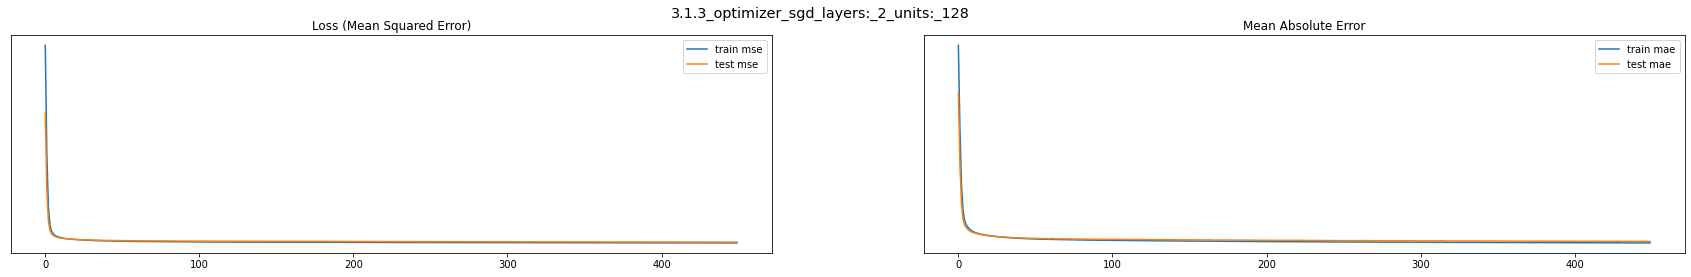

                                              type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_2_units:_128              16.385   
1   test:_3.1.3_optimizer_sgd_layers:_2_units:_128              17.167   
2         3.1.3_optimizer_sgd_layers:_2_units:_128               0.782   

   mean_absolute_error  r2_score  e_v_score  
0                3.116    94.358     94.359  
1                3.182    94.144     94.144  
2                0.066     0.214      0.215  

Epoch 1: val_loss improved from inf to 0.37258, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_4_units:_6.hdf5

Epoch 2: val_loss improved from 0.37258 to 0.36780, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_4_units:_6.hdf5

Epoch 3: val_loss improved from 0.36780 to 0.36510, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_

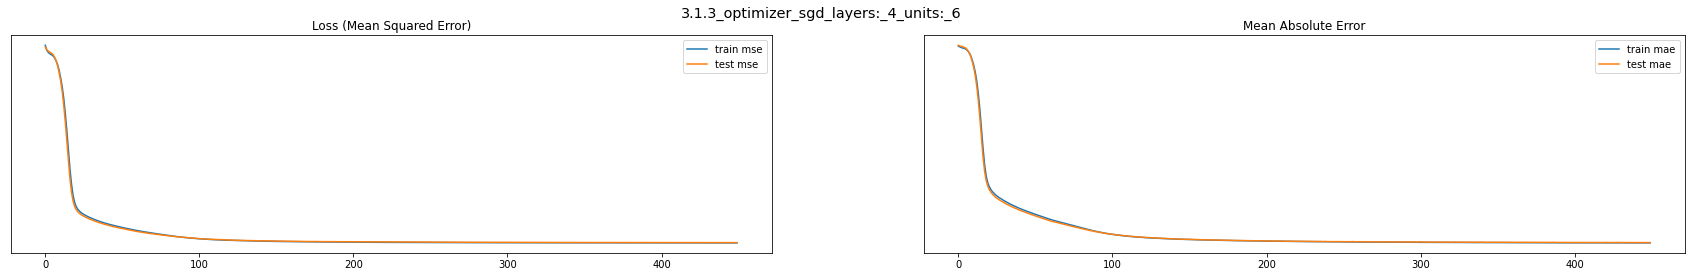

                                            type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_4_units:_6              17.850   
1   test:_3.1.3_optimizer_sgd_layers:_4_units:_6              18.274   
2         3.1.3_optimizer_sgd_layers:_4_units:_6               0.424   

   mean_absolute_error  r2_score  e_v_score  
0                3.285    93.854     93.856  
1                3.305    93.766     93.768  
2                0.021     0.088      0.088  

Epoch 1: val_loss improved from inf to 0.31474, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_4_units:_8.hdf5

Epoch 2: val_loss improved from 0.31474 to 0.27764, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_4_units:_8.hdf5

Epoch 3: val_loss improved from 0.27764 to 0.24946, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/

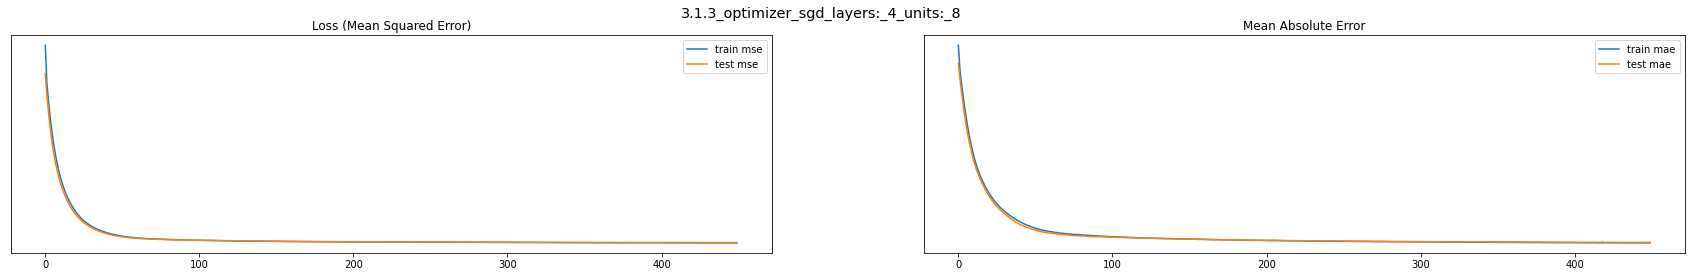

                                            type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_4_units:_8              17.927   
1   test:_3.1.3_optimizer_sgd_layers:_4_units:_8              18.328   
2         3.1.3_optimizer_sgd_layers:_4_units:_8               0.400   

   mean_absolute_error  r2_score  e_v_score  
0                3.299    93.827     93.852  
1                3.318    93.748     93.772  
2                0.019     0.079      0.080  

Epoch 1: val_loss improved from inf to 0.36069, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_4_units:_16.hdf5

Epoch 2: val_loss improved from 0.36069 to 0.34888, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_4_units:_16.hdf5

Epoch 3: val_loss improved from 0.34888 to 0.33865, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Projec

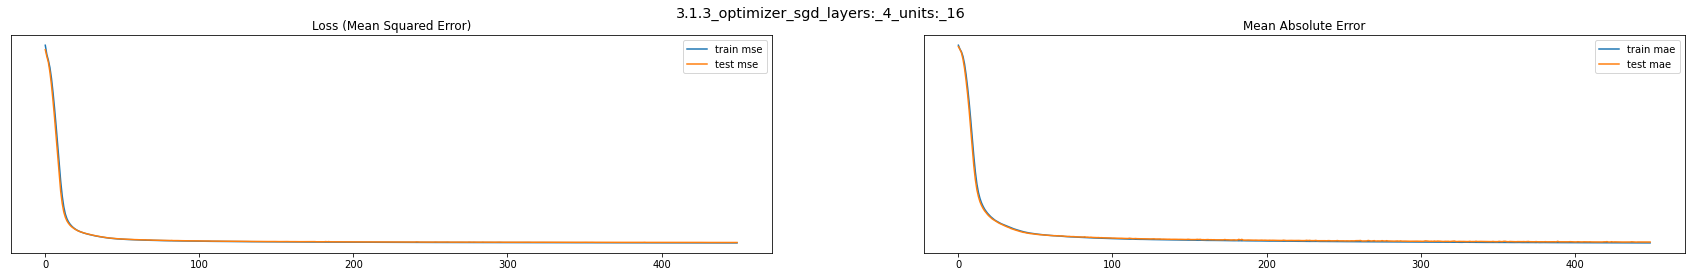

                                             type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_4_units:_16              16.854   
1   test:_3.1.3_optimizer_sgd_layers:_4_units:_16              17.482   
2         3.1.3_optimizer_sgd_layers:_4_units:_16               0.628   

   mean_absolute_error  r2_score  e_v_score  
0                3.184    94.197     94.199  
1                3.234    94.037     94.040  
2                0.050     0.160      0.159  

Epoch 1: val_loss improved from inf to 0.30855, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_4_units:_32.hdf5

Epoch 2: val_loss improved from 0.30855 to 0.25828, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_4_units:_32.hdf5

Epoch 3: val_loss improved from 0.25828 to 0.20351, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Pr

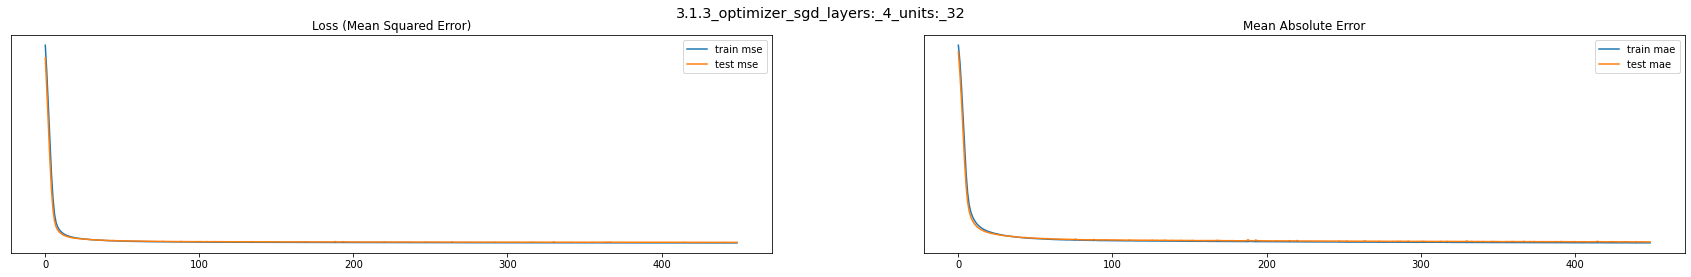

                                             type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_4_units:_32              16.420   
1   test:_3.1.3_optimizer_sgd_layers:_4_units:_32              17.122   
2         3.1.3_optimizer_sgd_layers:_4_units:_32               0.701   

   mean_absolute_error  r2_score  e_v_score  
0                3.111    94.346     94.346  
1                3.167    94.160     94.160  
2                0.057     0.186      0.186  

Epoch 1: val_loss improved from inf to 0.30561, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_4_units:_64.hdf5

Epoch 2: val_loss improved from 0.30561 to 0.23671, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_4_units:_64.hdf5

Epoch 3: val_loss improved from 0.23671 to 0.16457, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Pr

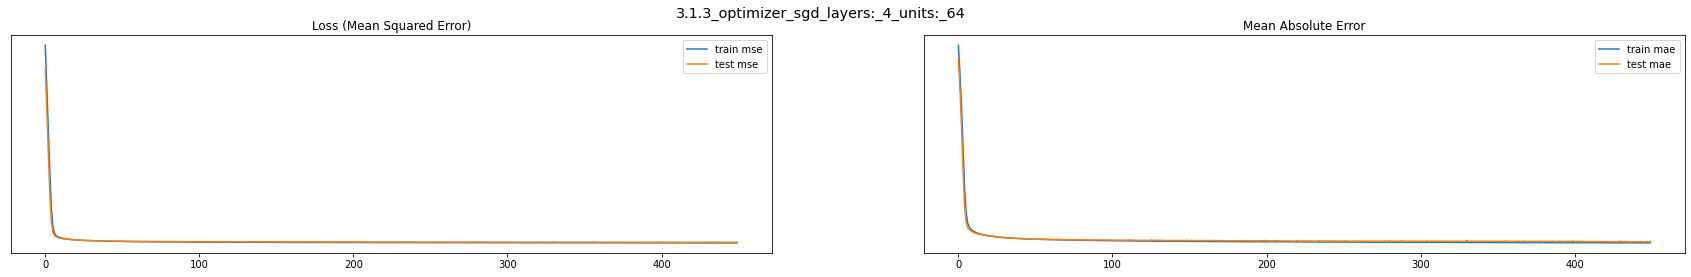

                                             type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_4_units:_64              16.174   
1   test:_3.1.3_optimizer_sgd_layers:_4_units:_64              16.973   
2         3.1.3_optimizer_sgd_layers:_4_units:_64               0.800   

   mean_absolute_error  r2_score  e_v_score  
0                3.097    94.431     94.470  
1                3.164    94.210     94.249  
2                0.067     0.221      0.221  

Epoch 1: val_loss improved from inf to 0.31370, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_4_units:_128.hdf5

Epoch 2: val_loss improved from 0.31370 to 0.24559, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_4_units:_128.hdf5

Epoch 3: val_loss improved from 0.24559 to 0.17131, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_

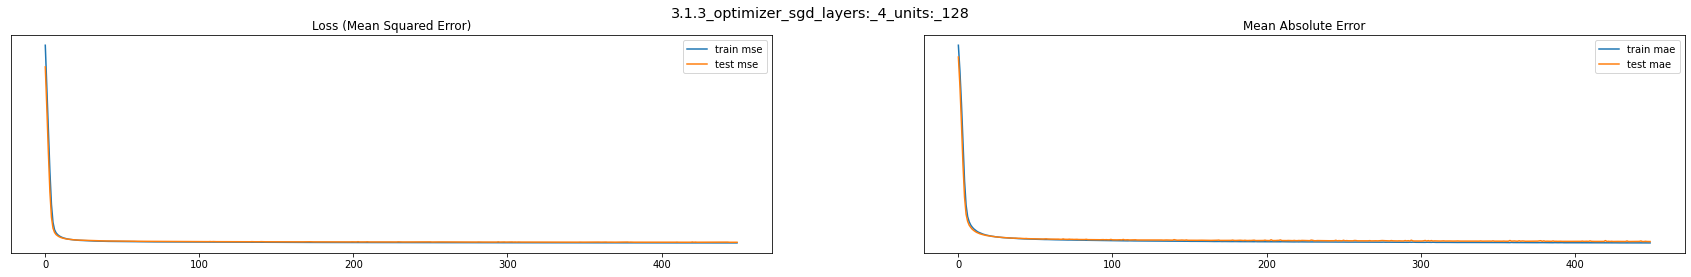

                                              type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_4_units:_128              15.895   
1   test:_3.1.3_optimizer_sgd_layers:_4_units:_128              16.782   
2         3.1.3_optimizer_sgd_layers:_4_units:_128               0.887   

   mean_absolute_error  r2_score  e_v_score  
0                3.054    94.527     94.527  
1                3.137    94.275     94.276  
2                0.082     0.252      0.251  

Epoch 1: val_loss improved from inf to 0.20244, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_6_units:_6.hdf5

Epoch 2: val_loss improved from 0.20244 to 0.13983, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_6_units:_6.hdf5

Epoch 3: val_loss improved from 0.13983 to 0.11339, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_

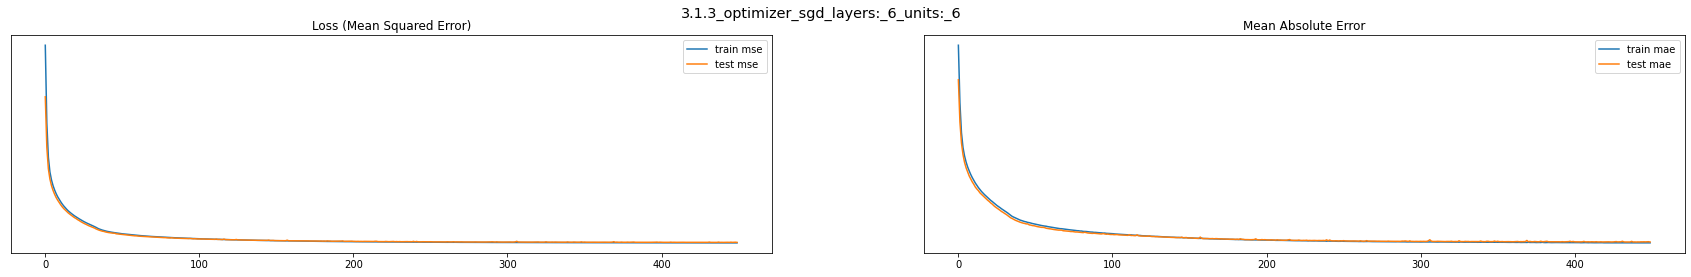

                                            type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_6_units:_6              17.409   
1   test:_3.1.3_optimizer_sgd_layers:_6_units:_6              17.933   
2         3.1.3_optimizer_sgd_layers:_6_units:_6               0.524   

   mean_absolute_error  r2_score  e_v_score  
0                3.227    94.006     94.012  
1                3.267    93.883     93.890  
2                0.041     0.123      0.122  

Epoch 1: val_loss improved from inf to 0.36044, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_6_units:_8.hdf5

Epoch 2: val_loss improved from 0.36044 to 0.35326, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_6_units:_8.hdf5

Epoch 3: val_loss improved from 0.35326 to 0.34813, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/

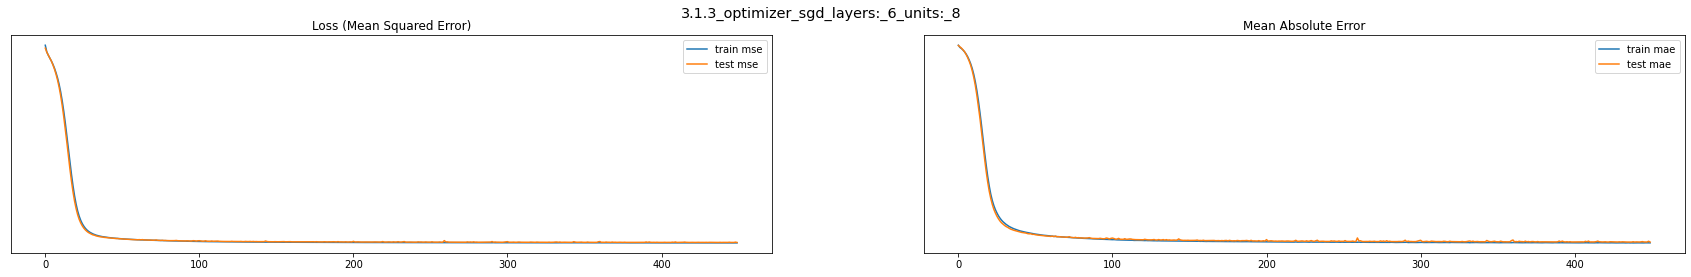

                                            type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_6_units:_8              17.526   
1   test:_3.1.3_optimizer_sgd_layers:_6_units:_8              18.174   
2         3.1.3_optimizer_sgd_layers:_6_units:_8               0.649   

   mean_absolute_error  r2_score  e_v_score  
0                3.257    93.966     93.966  
1                3.308    93.801     93.801  
2                0.051     0.165      0.165  

Epoch 1: val_loss improved from inf to 0.33440, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_6_units:_16.hdf5

Epoch 2: val_loss improved from 0.33440 to 0.30781, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_6_units:_16.hdf5

Epoch 3: val_loss improved from 0.30781 to 0.27627, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Projec

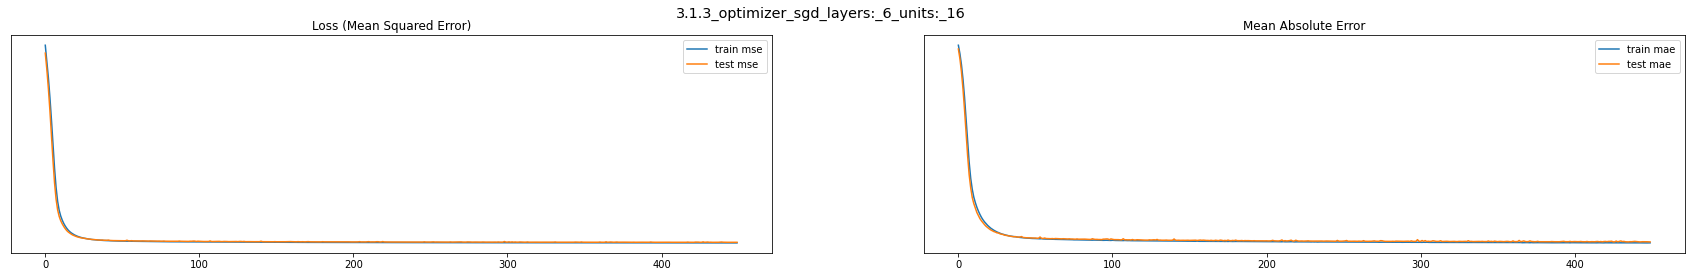

                                             type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_6_units:_16              16.688   
1   test:_3.1.3_optimizer_sgd_layers:_6_units:_16              17.509   
2         3.1.3_optimizer_sgd_layers:_6_units:_16               0.820   

   mean_absolute_error  r2_score  e_v_score  
0                3.151    94.254     94.259  
1                3.214    94.028     94.034  
2                0.063     0.226      0.225  

Epoch 1: val_loss improved from inf to 0.34076, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_6_units:_32.hdf5

Epoch 2: val_loss improved from 0.34076 to 0.31848, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_6_units:_32.hdf5

Epoch 3: val_loss improved from 0.31848 to 0.29179, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Pr

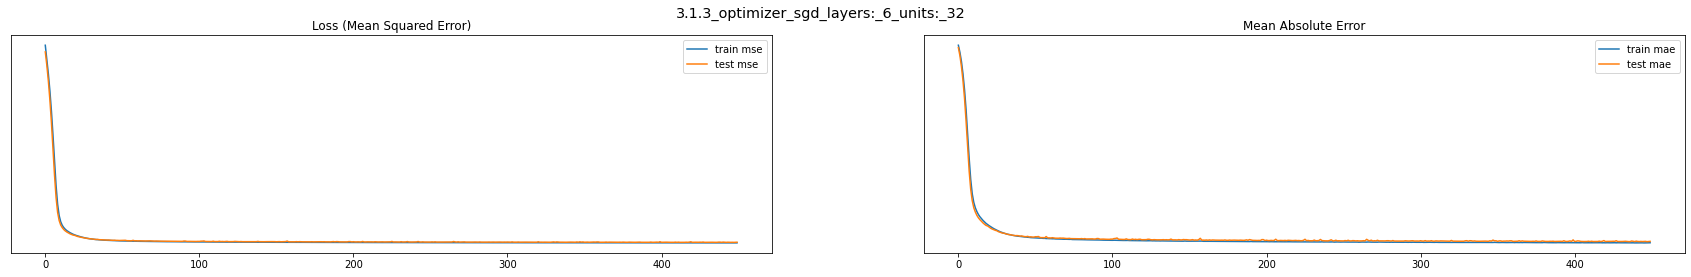

                                             type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_6_units:_32              16.275   
1   test:_3.1.3_optimizer_sgd_layers:_6_units:_32              17.036   
2         3.1.3_optimizer_sgd_layers:_6_units:_32               0.761   

   mean_absolute_error  r2_score  e_v_score  
0                3.068    94.396     94.465  
1                3.148    94.189     94.255  
2                0.080     0.207      0.210  

Epoch 1: val_loss improved from inf to 0.31668, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_6_units:_64.hdf5

Epoch 2: val_loss improved from 0.31668 to 0.26904, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_6_units:_64.hdf5

Epoch 3: val_loss improved from 0.26904 to 0.21370, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Pr

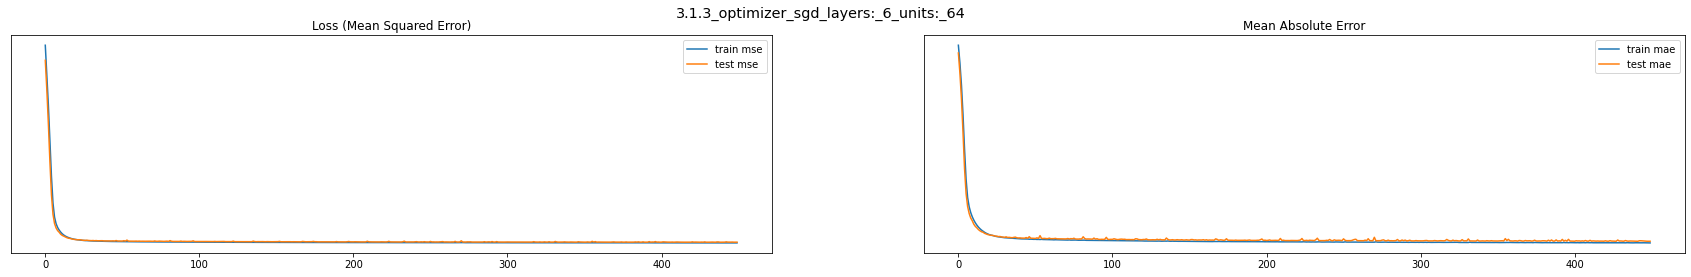

                                             type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_6_units:_64              15.882   
1   test:_3.1.3_optimizer_sgd_layers:_6_units:_64              16.849   
2         3.1.3_optimizer_sgd_layers:_6_units:_64               0.967   

   mean_absolute_error  r2_score  e_v_score  
0                3.035    94.531     94.543  
1                3.135    94.253     94.262  
2                0.101     0.278      0.281  

Epoch 1: val_loss improved from inf to 0.34092, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_6_units:_128.hdf5

Epoch 2: val_loss improved from 0.34092 to 0.31131, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_6_units:_128.hdf5

Epoch 3: val_loss improved from 0.31131 to 0.26429, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_

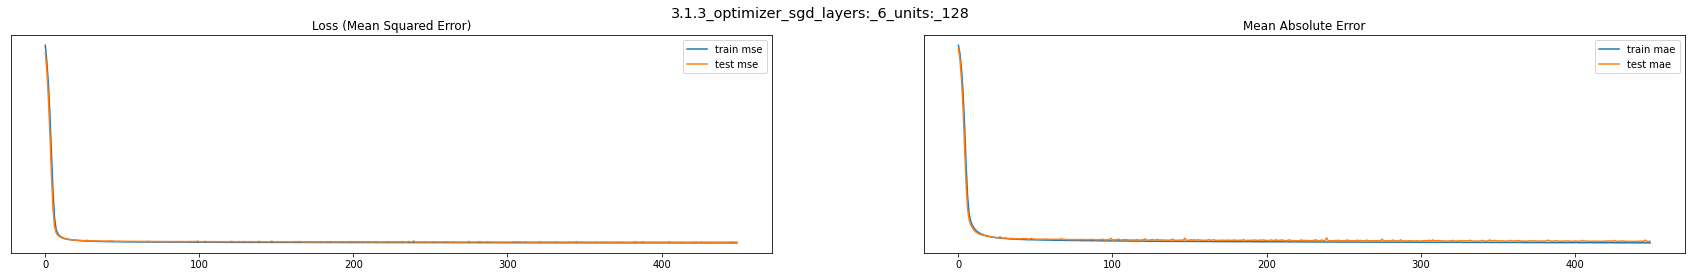

                                              type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_6_units:_128              15.770   
1   test:_3.1.3_optimizer_sgd_layers:_6_units:_128              16.727   
2         3.1.3_optimizer_sgd_layers:_6_units:_128               0.957   

   mean_absolute_error  r2_score  e_v_score  
0                3.035    94.570     94.571  
1                3.124    94.294     94.295  
2                0.089     0.276      0.276  

Epoch 1: val_loss improved from inf to 0.36498, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_8_units:_6.hdf5

Epoch 2: val_loss improved from 0.36498 to 0.36102, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_8_units:_6.hdf5

Epoch 3: val_loss improved from 0.36102 to 0.35900, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_

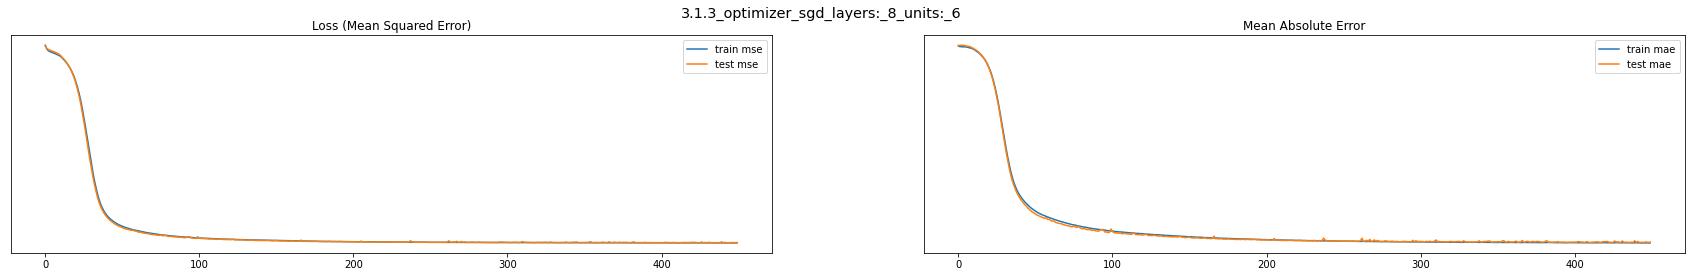

                                            type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_8_units:_6              18.005   
1   test:_3.1.3_optimizer_sgd_layers:_8_units:_6              18.352   
2         3.1.3_optimizer_sgd_layers:_8_units:_6               0.346   

   mean_absolute_error  r2_score  e_v_score  
0                3.294     93.80     93.906  
1                3.326     93.74     93.850  
2                0.032      0.06      0.056  

Epoch 1: val_loss improved from inf to 0.36200, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_8_units:_8.hdf5

Epoch 2: val_loss improved from 0.36200 to 0.35407, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_8_units:_8.hdf5

Epoch 3: val_loss improved from 0.35407 to 0.34826, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/

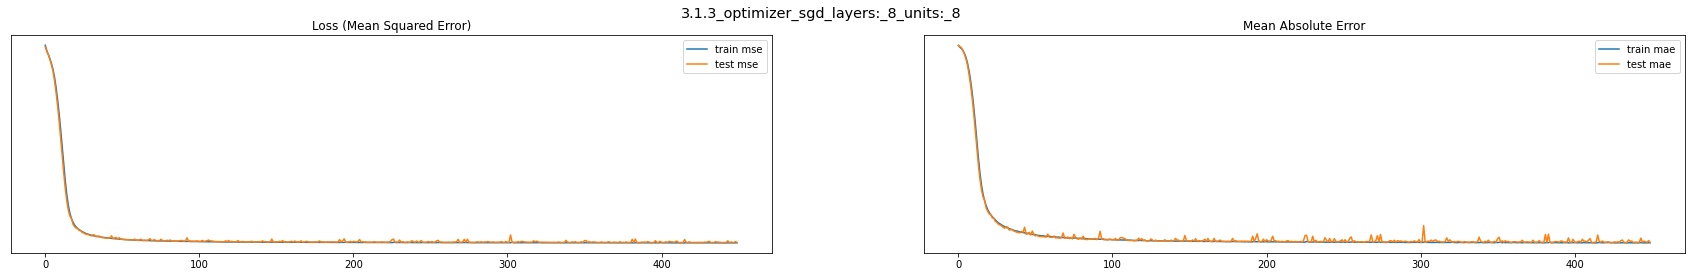

                                            type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_8_units:_8              17.382   
1   test:_3.1.3_optimizer_sgd_layers:_8_units:_8              17.991   
2         3.1.3_optimizer_sgd_layers:_8_units:_8               0.609   

   mean_absolute_error  r2_score  e_v_score  
0                3.227    94.015     94.050  
1                3.256    93.863     93.892  
2                0.029     0.152      0.158  

Epoch 1: val_loss improved from inf to 0.36031, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_8_units:_16.hdf5

Epoch 2: val_loss improved from 0.36031 to 0.35161, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_8_units:_16.hdf5

Epoch 3: val_loss improved from 0.35161 to 0.34294, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Projec

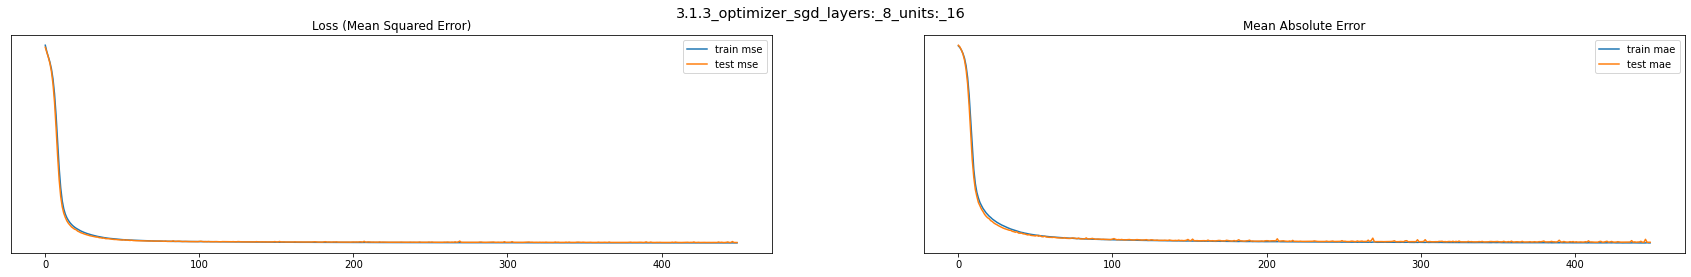

                                             type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_8_units:_16              16.953   
1   test:_3.1.3_optimizer_sgd_layers:_8_units:_16              17.547   
2         3.1.3_optimizer_sgd_layers:_8_units:_16               0.594   

   mean_absolute_error  r2_score  e_v_score  
0                3.174    94.163     94.164  
1                3.220    94.014     94.016  
2                0.046     0.149      0.148  

Epoch 1: val_loss improved from inf to 0.34396, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_8_units:_32.hdf5

Epoch 2: val_loss improved from 0.34396 to 0.32091, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_8_units:_32.hdf5

Epoch 3: val_loss improved from 0.32091 to 0.29109, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Pr

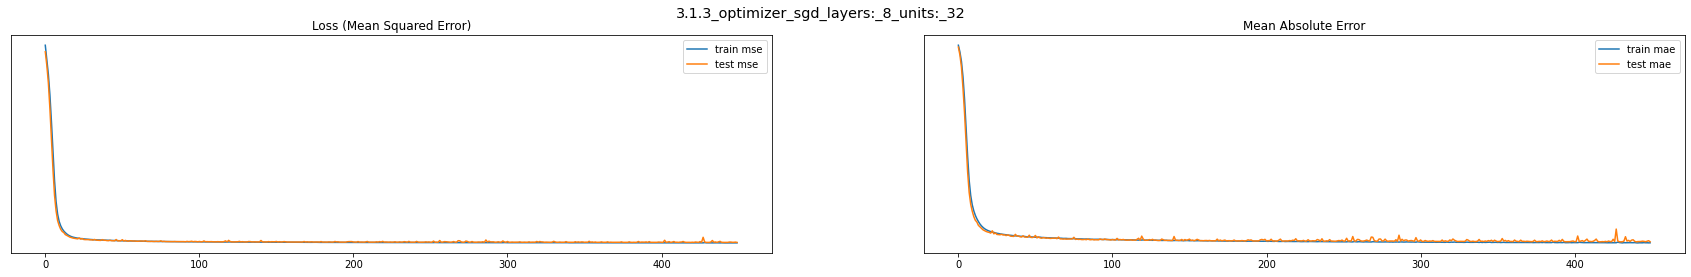

                                             type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_8_units:_32              15.728   
1   test:_3.1.3_optimizer_sgd_layers:_8_units:_32              16.473   
2         3.1.3_optimizer_sgd_layers:_8_units:_32               0.745   

   mean_absolute_error  r2_score  e_v_score  
0                3.028    94.584     94.587  
1                3.099    94.381     94.382  
2                0.070     0.203      0.205  

Epoch 1: val_loss improved from inf to 0.33509, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_8_units:_64.hdf5

Epoch 2: val_loss improved from 0.33509 to 0.29420, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_8_units:_64.hdf5

Epoch 3: val_loss improved from 0.29420 to 0.24195, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Pr

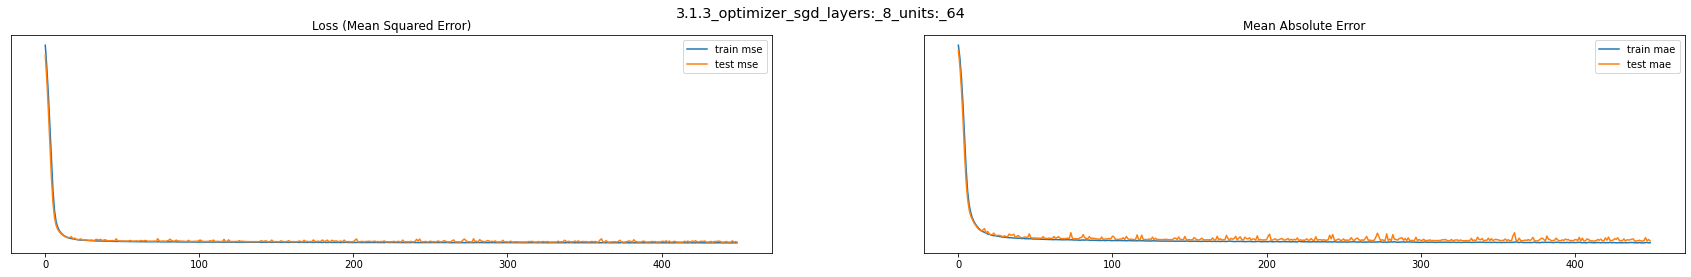

                                             type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_8_units:_64              15.106   
1   test:_3.1.3_optimizer_sgd_layers:_8_units:_64              16.218   
2         3.1.3_optimizer_sgd_layers:_8_units:_64               1.112   

   mean_absolute_error  r2_score  e_v_score  
0                2.955    94.799     94.806  
1                3.072    94.468     94.476  
2                0.117     0.331      0.330  

Epoch 1: val_loss improved from inf to 0.34371, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_8_units:_128.hdf5

Epoch 2: val_loss improved from 0.34371 to 0.31369, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_8_units:_128.hdf5

Epoch 3: val_loss improved from 0.31369 to 0.27575, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_

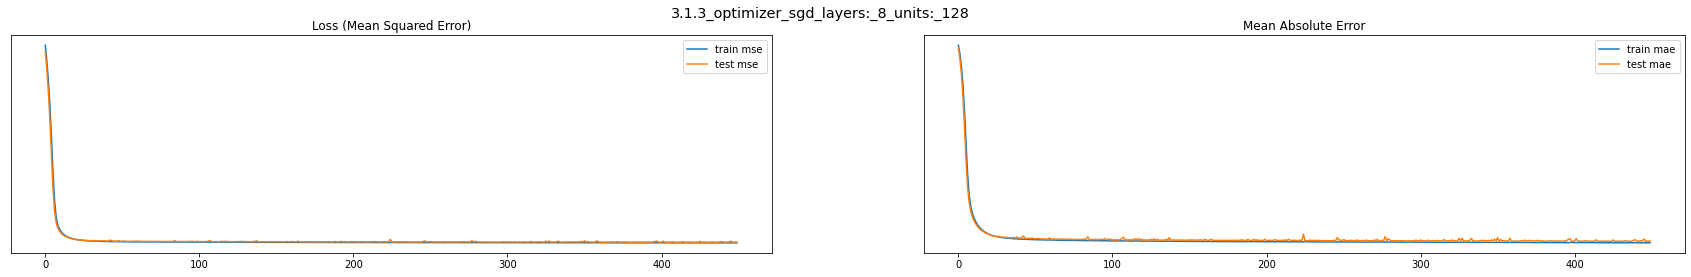

                                              type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_8_units:_128              15.591   
1   test:_3.1.3_optimizer_sgd_layers:_8_units:_128              16.578   
2         3.1.3_optimizer_sgd_layers:_8_units:_128               0.986   

   mean_absolute_error  r2_score  e_v_score  
0                3.005    94.632     94.684  
1                3.100    94.345     94.396  
2                0.096     0.287      0.288  

Epoch 1: val_loss improved from inf to 0.36530, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_10_units:_6.hdf5

Epoch 2: val_loss improved from 0.36530 to 0.36417, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_10_units:_6.hdf5

Epoch 3: val_loss improved from 0.36417 to 0.36395, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_AN

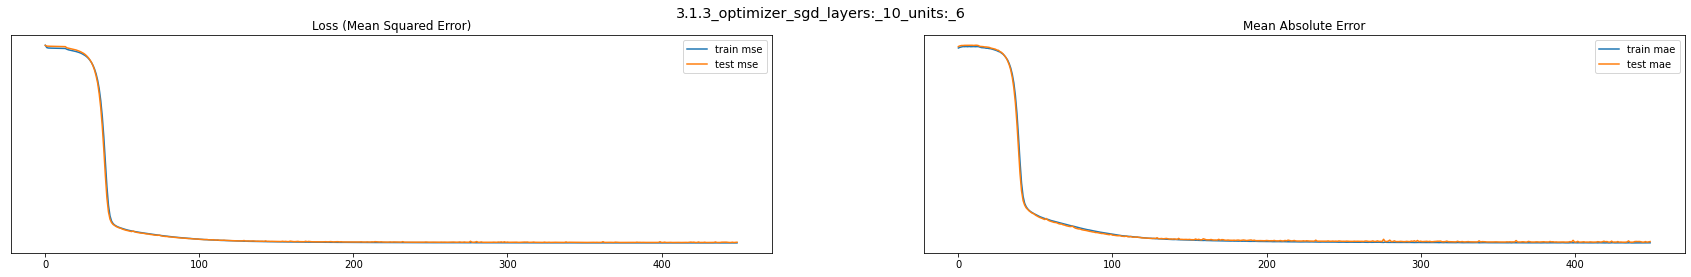

                                             type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_10_units:_6              18.012   
1   test:_3.1.3_optimizer_sgd_layers:_10_units:_6              18.623   
2         3.1.3_optimizer_sgd_layers:_10_units:_6               0.611   

   mean_absolute_error  r2_score  e_v_score  
0                3.302    93.798     93.928  
1                3.344    93.648     93.760  
2                0.042     0.150      0.168  

Epoch 1: val_loss improved from inf to 0.36335, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_10_units:_8.hdf5

Epoch 2: val_loss improved from 0.36335 to 0.35257, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_10_units:_8.hdf5

Epoch 3: val_loss improved from 0.35257 to 0.34148, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Pr

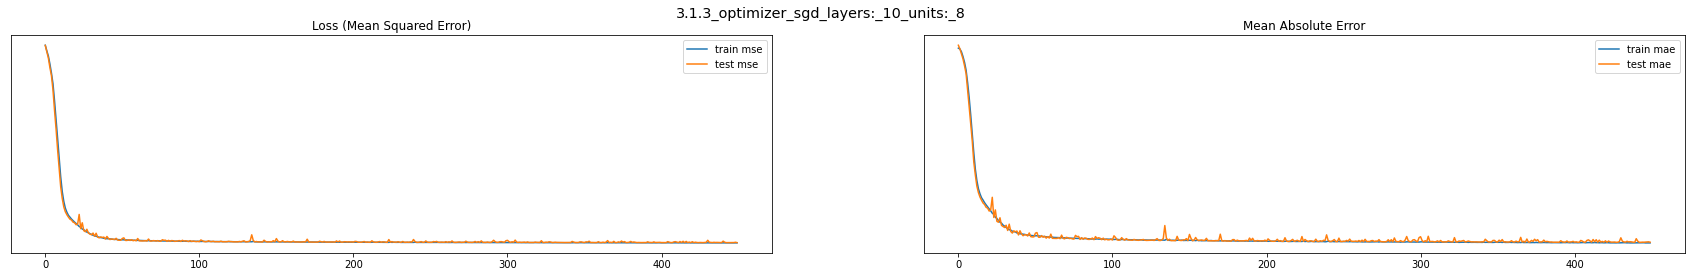

                                             type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_10_units:_8              17.382   
1   test:_3.1.3_optimizer_sgd_layers:_10_units:_8              17.848   
2         3.1.3_optimizer_sgd_layers:_10_units:_8               0.466   

   mean_absolute_error  r2_score  e_v_score  
0                3.233    94.015     94.017  
1                3.277    93.912     93.917  
2                0.044     0.103      0.100  

Epoch 1: val_loss improved from inf to 0.36429, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_10_units:_16.hdf5

Epoch 2: val_loss improved from 0.36429 to 0.35691, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_10_units:_16.hdf5

Epoch 3: val_loss improved from 0.35691 to 0.34982, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_

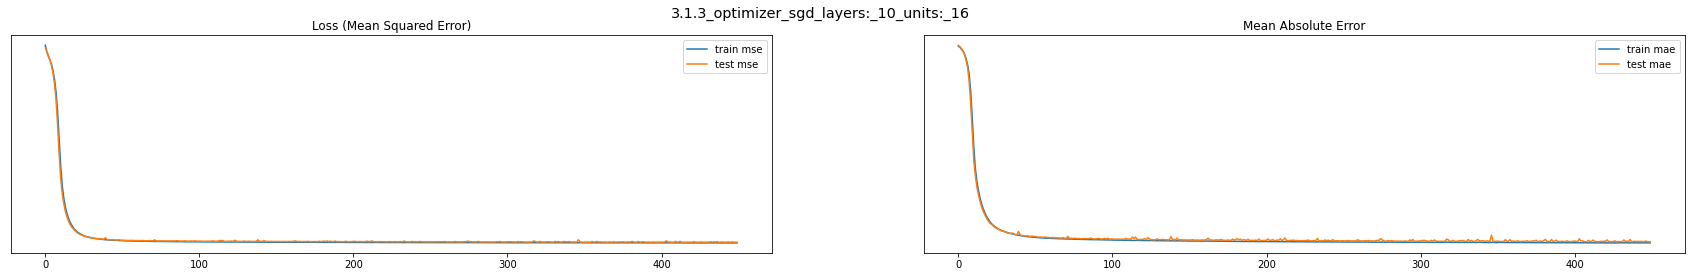

                                              type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_10_units:_16              17.279   
1   test:_3.1.3_optimizer_sgd_layers:_10_units:_16              18.228   
2         3.1.3_optimizer_sgd_layers:_10_units:_16               0.950   

   mean_absolute_error  r2_score  e_v_score  
0                3.220    94.051     94.051  
1                3.293    93.782     93.783  
2                0.073     0.269      0.268  

Epoch 1: val_loss improved from inf to 0.34242, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_10_units:_32.hdf5

Epoch 2: val_loss improved from 0.34242 to 0.32225, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_10_units:_32.hdf5

Epoch 3: val_loss improved from 0.32225 to 0.29641, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_

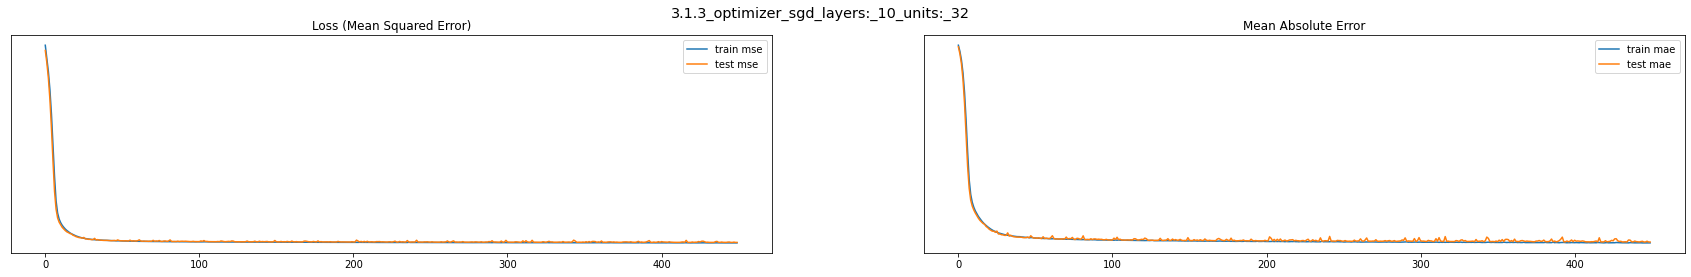

                                              type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_10_units:_32              15.934   
1   test:_3.1.3_optimizer_sgd_layers:_10_units:_32              16.686   
2         3.1.3_optimizer_sgd_layers:_10_units:_32               0.752   

   mean_absolute_error  r2_score  e_v_score  
0                3.058    94.514     94.516  
1                3.117    94.308     94.310  
2                0.059     0.206      0.206  

Epoch 1: val_loss improved from inf to 0.36266, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_10_units:_64.hdf5

Epoch 2: val_loss improved from 0.36266 to 0.35995, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_10_units:_64.hdf5

Epoch 3: val_loss improved from 0.35995 to 0.35747, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_

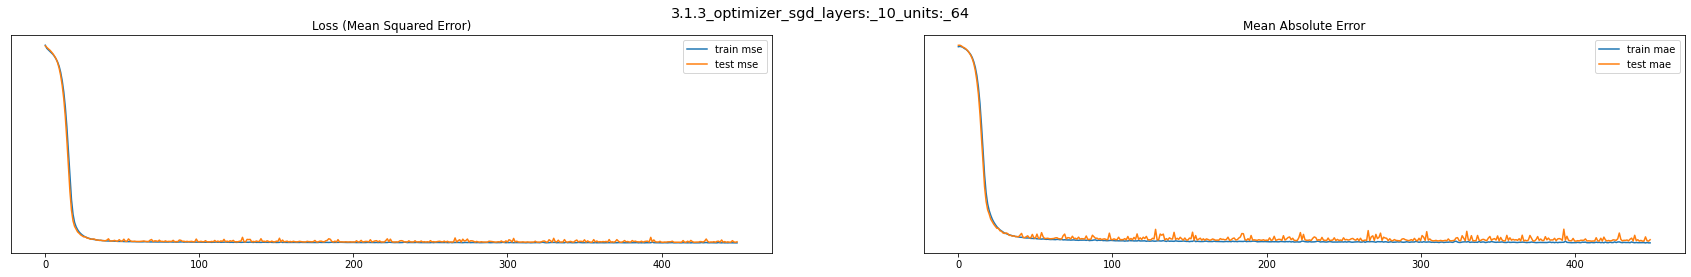

                                              type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_10_units:_64              16.070   
1   test:_3.1.3_optimizer_sgd_layers:_10_units:_64              17.047   
2         3.1.3_optimizer_sgd_layers:_10_units:_64               0.978   

   mean_absolute_error  r2_score  e_v_score  
0                3.071    94.467     94.687  
1                3.180    94.185     94.404  
2                0.109     0.282      0.283  

Epoch 1: val_loss improved from inf to 0.34244, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_10_units:_128.hdf5

Epoch 2: val_loss improved from 0.34244 to 0.32033, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_10_units:_128.hdf5

Epoch 3: val_loss improved from 0.32033 to 0.28517, saving model to /content/drive/MyDrive/Colab Notebooks/4.M

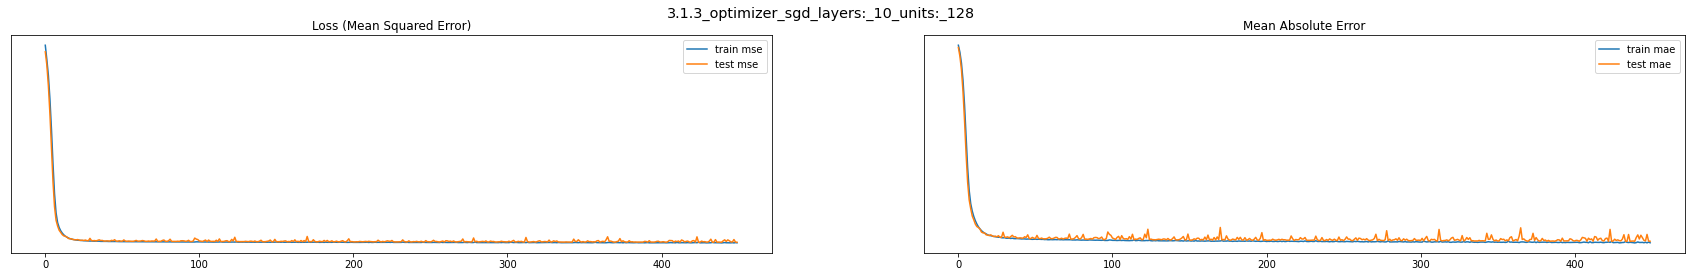

                                               type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_10_units:_128              15.029   
1   test:_3.1.3_optimizer_sgd_layers:_10_units:_128              16.038   
2         3.1.3_optimizer_sgd_layers:_10_units:_128               1.009   

   mean_absolute_error  r2_score  e_v_score  
0                2.949    94.825     94.829  
1                3.050    94.529     94.532  
2                0.101     0.296      0.297  

Epoch 1: val_loss improved from inf to 0.36120, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_15_units:_6.hdf5

Epoch 2: val_loss improved from 0.36120 to 0.35791, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_15_units:_6.hdf5

Epoch 3: val_loss improved from 0.35791 to 0.35388, saving model to /content/drive/MyDrive/Colab Notebooks/4.M

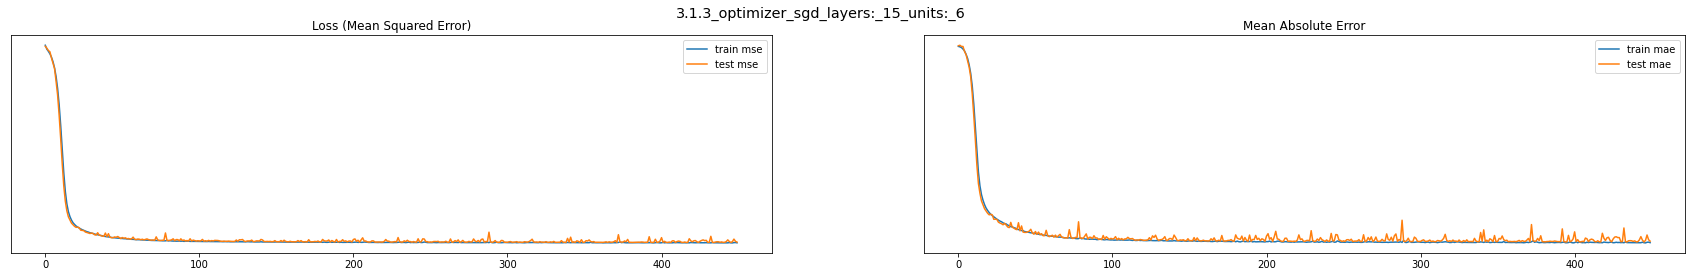

                                             type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_15_units:_6              17.978   
1   test:_3.1.3_optimizer_sgd_layers:_15_units:_6              18.553   
2         3.1.3_optimizer_sgd_layers:_15_units:_6               0.576   

   mean_absolute_error  r2_score  e_v_score  
0                3.275    93.810     93.987  
1                3.321    93.671     93.822  
2                0.046     0.139      0.165  

Epoch 1: val_loss improved from inf to 0.36641, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_15_units:_8.hdf5

Epoch 2: val_loss improved from 0.36641 to 0.36483, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_15_units:_8.hdf5

Epoch 3: val_loss improved from 0.36483 to 0.36452, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Pr

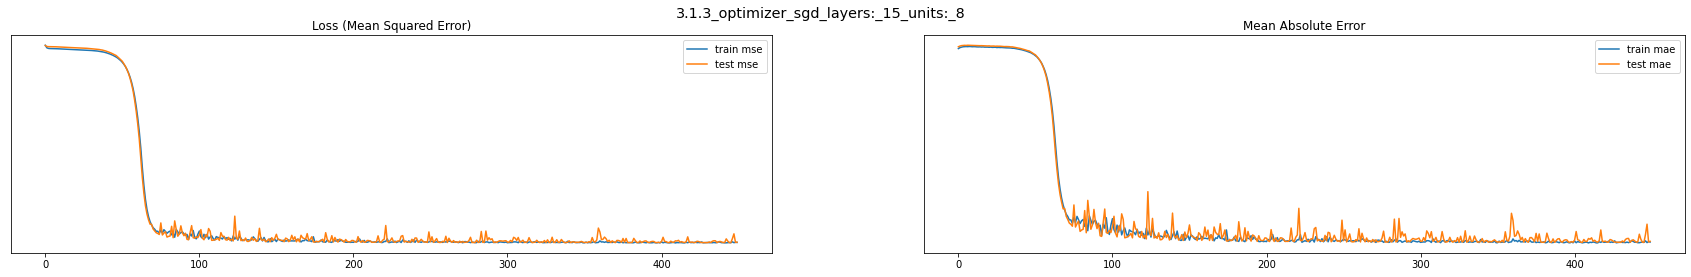

                                             type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_15_units:_8              18.146   
1   test:_3.1.3_optimizer_sgd_layers:_15_units:_8              18.672   
2         3.1.3_optimizer_sgd_layers:_15_units:_8               0.526   

   mean_absolute_error  r2_score  e_v_score  
0                3.306    93.752     93.994  
1                3.348    93.631     93.873  
2                0.041     0.121      0.121  

Epoch 1: val_loss improved from inf to 0.36444, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_15_units:_16.hdf5

Epoch 2: val_loss improved from 0.36444 to 0.36358, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_15_units:_16.hdf5

Epoch 3: val_loss improved from 0.36358 to 0.36345, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_

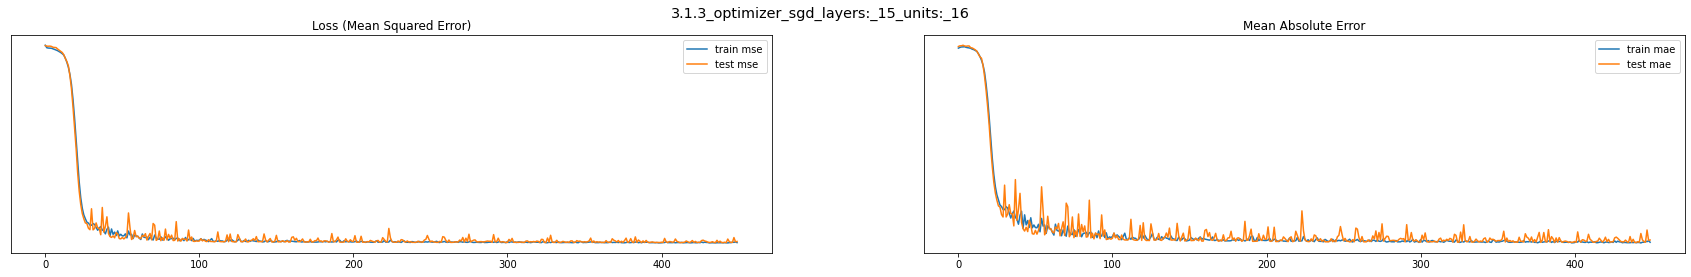

                                              type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_15_units:_16              17.694   
1   test:_3.1.3_optimizer_sgd_layers:_15_units:_16              18.229   
2         3.1.3_optimizer_sgd_layers:_15_units:_16               0.535   

   mean_absolute_error  r2_score  e_v_score  
0                3.213    93.908     94.446  
1                3.260    93.782     94.302  
2                0.046     0.126      0.144  

Epoch 1: val_loss improved from inf to 0.36472, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_15_units:_32.hdf5

Epoch 2: val_loss improved from 0.36472 to 0.35960, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_15_units:_32.hdf5

Epoch 3: val_loss improved from 0.35960 to 0.35067, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_

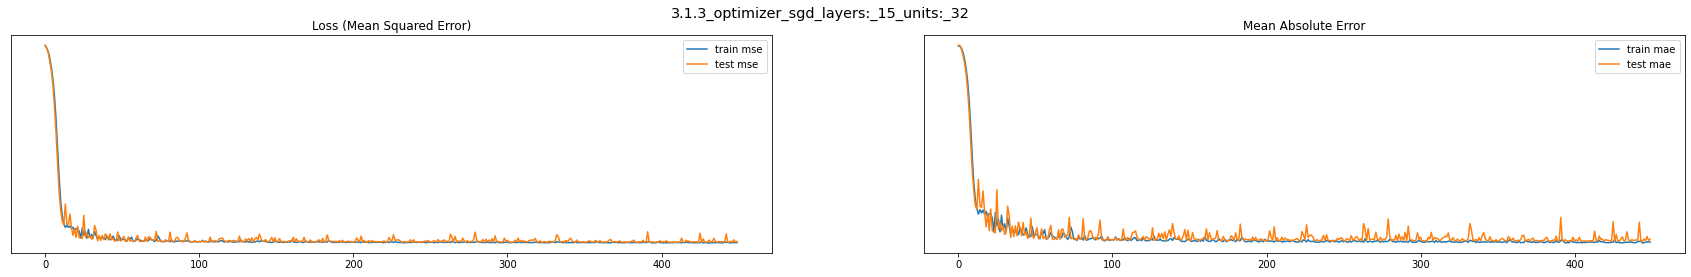

                                              type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_15_units:_32              16.868   
1   test:_3.1.3_optimizer_sgd_layers:_15_units:_32              17.929   
2         3.1.3_optimizer_sgd_layers:_15_units:_32               1.062   

   mean_absolute_error  r2_score  e_v_score  
0                3.173    94.192     94.556  
1                3.281    93.884     94.259  
2                0.109     0.308      0.297  

Epoch 1: val_loss improved from inf to 0.36309, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_15_units:_64.hdf5

Epoch 2: val_loss improved from 0.36309 to 0.36068, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_15_units:_64.hdf5

Epoch 3: val_loss improved from 0.36068 to 0.35703, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_

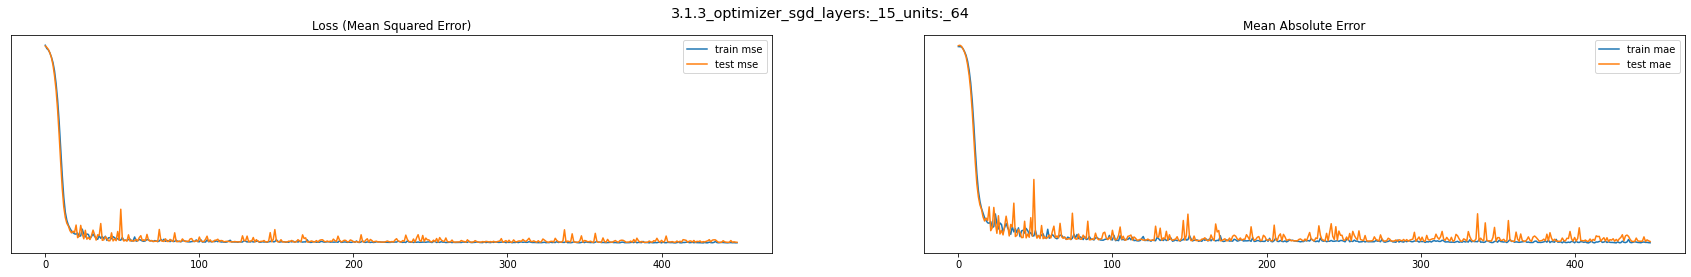

                                              type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_15_units:_64              15.516   
1   test:_3.1.3_optimizer_sgd_layers:_15_units:_64              16.439   
2         3.1.3_optimizer_sgd_layers:_15_units:_64               0.924   

   mean_absolute_error  r2_score  e_v_score  
0                2.998    94.658     94.664  
1                3.103    94.392     94.397  
2                0.105     0.266      0.267  

Epoch 1: val_loss improved from inf to 0.35558, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_15_units:_128.hdf5

Epoch 2: val_loss improved from 0.35558 to 0.33580, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_15_units:_128.hdf5

Epoch 3: val_loss improved from 0.33580 to 0.30425, saving model to /content/drive/MyDrive/Colab Notebooks/4.M

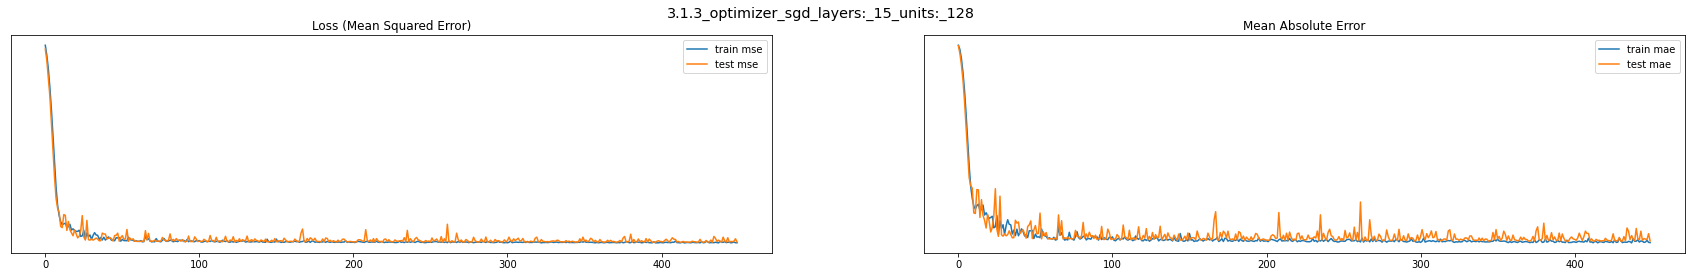

                                               type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_15_units:_128              15.377   
1   test:_3.1.3_optimizer_sgd_layers:_15_units:_128              16.570   
2         3.1.3_optimizer_sgd_layers:_15_units:_128               1.193   

   mean_absolute_error  r2_score  e_v_score  
0                2.965    94.705     94.723  
1                3.091    94.348     94.369  
2                0.126     0.357      0.354  

Epoch 1: val_loss improved from inf to 0.36477, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_20_units:_6.hdf5

Epoch 2: val_loss improved from 0.36477 to 0.36450, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_20_units:_6.hdf5

Epoch 3: val_loss did not improve from 0.36450

Epoch 4: val_loss improved from 0.36450 to 0.36450, saving mod

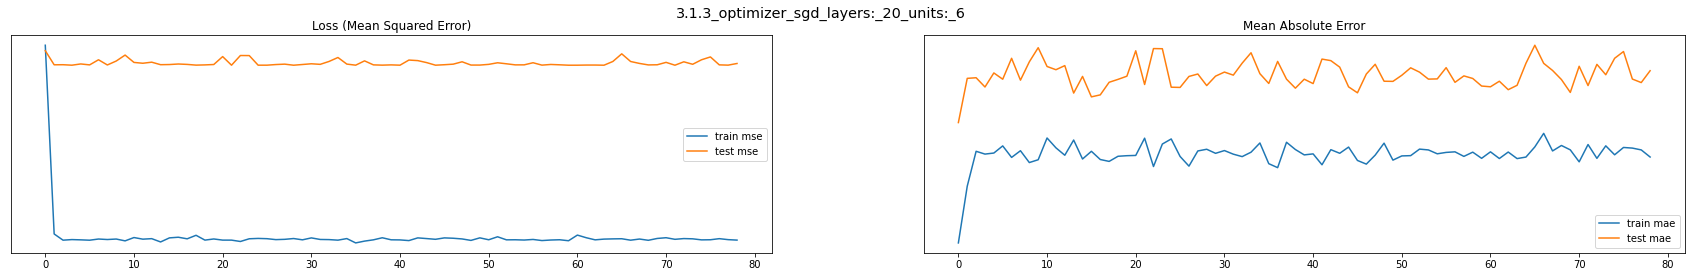

                                             type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_20_units:_6             290.428   
1   test:_3.1.3_optimizer_sgd_layers:_20_units:_6             293.186   
2         3.1.3_optimizer_sgd_layers:_20_units:_6               2.758   

   mean_absolute_error  r2_score  e_v_score  
0               14.819    -0.000        0.0  
1               14.894    -0.009        0.0  
2                0.075     0.009        0.0  

Epoch 1: val_loss improved from inf to 0.36466, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_20_units:_8.hdf5

Epoch 2: val_loss improved from 0.36466 to 0.36446, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_20_units:_8.hdf5

Epoch 3: val_loss improved from 0.36446 to 0.36407, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Pr

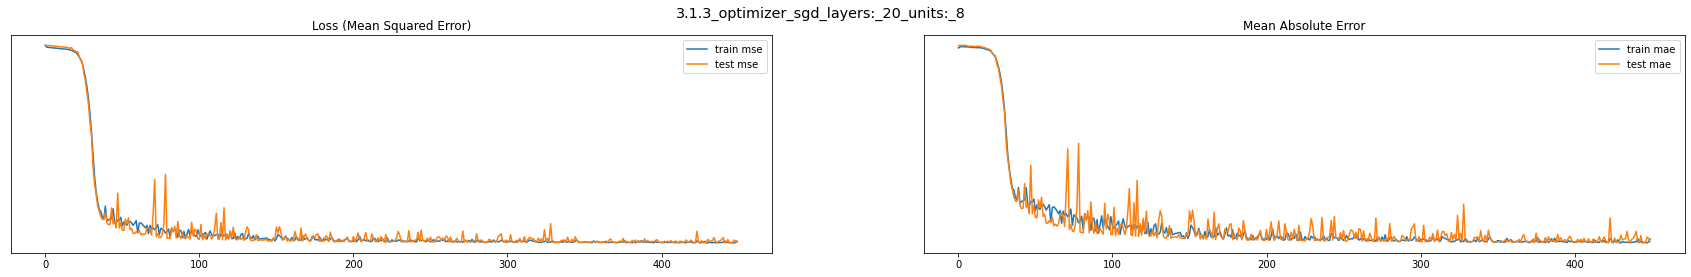

                                             type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_20_units:_8              17.968   
1   test:_3.1.3_optimizer_sgd_layers:_20_units:_8              18.443   
2         3.1.3_optimizer_sgd_layers:_20_units:_8               0.475   

   mean_absolute_error  r2_score  e_v_score  
0                3.286    93.813     93.969  
1                3.318    93.709     93.872  
2                0.032     0.104      0.097  

Epoch 1: val_loss improved from inf to 0.36541, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_20_units:_16.hdf5

Epoch 2: val_loss improved from 0.36541 to 0.36441, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_20_units:_16.hdf5

Epoch 3: val_loss improved from 0.36441 to 0.36395, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_

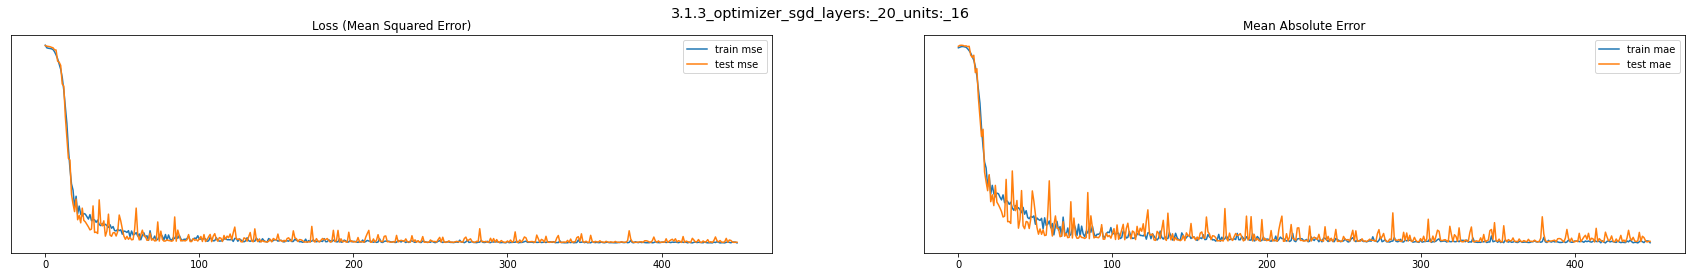

                                              type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_20_units:_16              16.734   
1   test:_3.1.3_optimizer_sgd_layers:_20_units:_16              17.511   
2         3.1.3_optimizer_sgd_layers:_20_units:_16               0.777   

   mean_absolute_error  r2_score  e_v_score  
0                3.165    94.238     94.345  
1                3.233    94.027     94.145  
2                0.068     0.211      0.200  

Epoch 1: val_loss improved from inf to 0.36425, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_20_units:_32.hdf5

Epoch 2: val_loss improved from 0.36425 to 0.36401, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_20_units:_32.hdf5

Epoch 3: val_loss improved from 0.36401 to 0.36388, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_

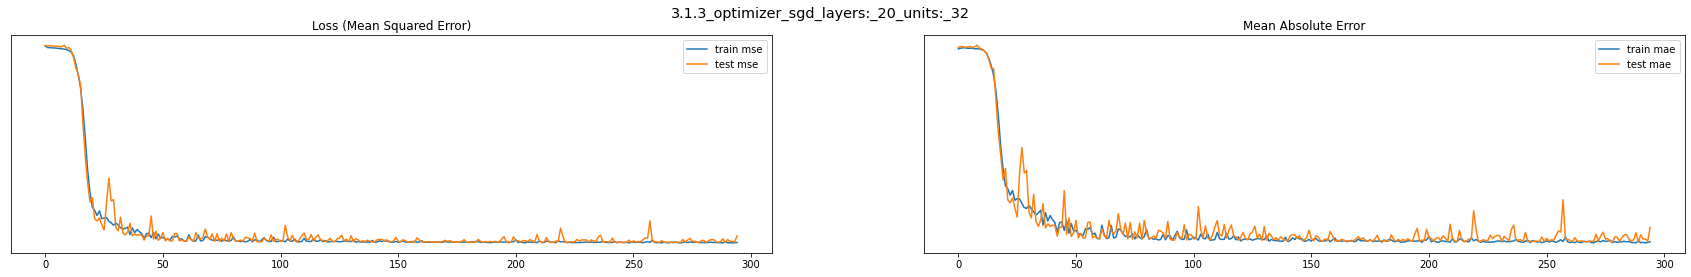

                                              type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_20_units:_32              25.241   
1   test:_3.1.3_optimizer_sgd_layers:_20_units:_32              25.884   
2         3.1.3_optimizer_sgd_layers:_20_units:_32               0.643   

   mean_absolute_error  r2_score  e_v_score  
0                3.946    91.309     94.374  
1                4.014    91.171     94.197  
2                0.068     0.138      0.177  

Epoch 1: val_loss improved from inf to 0.36503, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_20_units:_64.hdf5

Epoch 2: val_loss improved from 0.36503 to 0.36247, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_20_units:_64.hdf5

Epoch 3: val_loss improved from 0.36247 to 0.36157, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_

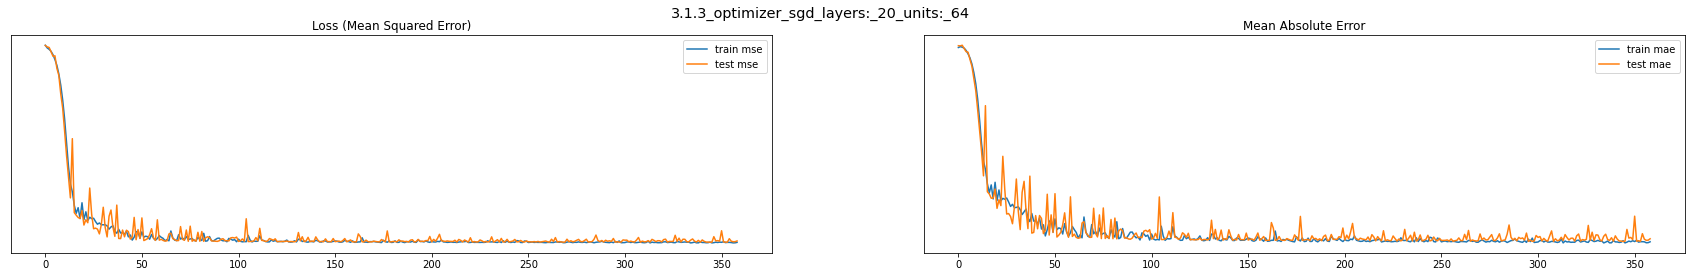

                                              type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_20_units:_64              17.494   
1   test:_3.1.3_optimizer_sgd_layers:_20_units:_64              18.630   
2         3.1.3_optimizer_sgd_layers:_20_units:_64               1.136   

   mean_absolute_error  r2_score  e_v_score  
0                3.196    93.977     94.566  
1                3.303    93.645     94.232  
2                0.108     0.332      0.334  

Epoch 1: val_loss improved from inf to 0.36516, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_20_units:_128.hdf5

Epoch 2: val_loss improved from 0.36516 to 0.36125, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.3_optimizer_sgd_layers:_20_units:_128.hdf5

Epoch 3: val_loss improved from 0.36125 to 0.35767, saving model to /content/drive/MyDrive/Colab Notebooks/4.M

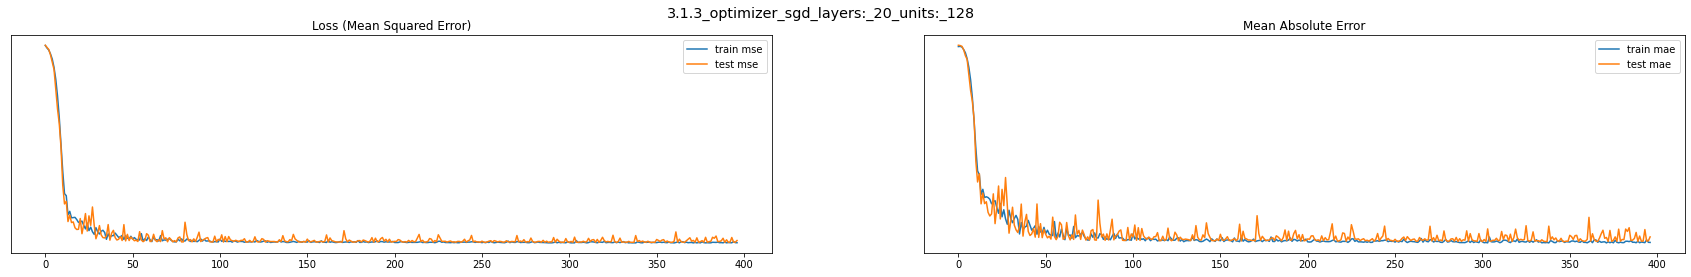

                                               type  mean_squared_error  \
0  train:_3.1.3_optimizer_sgd_layers:_20_units:_128              17.997   
1   test:_3.1.3_optimizer_sgd_layers:_20_units:_128              18.971   
2         3.1.3_optimizer_sgd_layers:_20_units:_128               0.974   

   mean_absolute_error  r2_score  e_v_score  
0                3.301    93.803     94.646  
1                3.370    93.529     94.387  
2                0.069     0.274      0.259  


In [ ]:
rcpr_transformer = FunctionTransformer(lambda x: 1/x, validate = True)
yj_transformer = PowerTransformer(method = 'yeo-johnson', standardize = False)

pipe_complex = define_pipeline_complex(RobustScaler(),yj_transformer, rcpr_transformer, False, True)
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_complex, KNNImputer(n_neighbors=2), True, True)
nlayers = [2,4,6,8,10,15,20]
units = [6,8,16,32,64,128]
for nl in nlayers:
  for u in units:
    complete_run (f"3.1.3_optimizer_sgd_layers:_{nl}_units:_{u}", pipe,  opt = 'sgd', n_layers = nl, unt = u)

In [ ]:
show_results(False)

MSE 
 
 
   
 modelName 
 train_mse 
 test_mse 
 difference 
 
 
 
 
 29 
 3.1.3_optimizer_sgd_layers:_10_units:_128 
 15.029 
 16.038 
 1.009 
 
 
 22 
 3.1.3_optimizer_sgd_layers:_8_units:_64 
 15.106 
 16.218 
 1.112 
 
 
 34 
 3.1.3_optimizer_sgd_layers:_15_units:_64 
 15.516 
 16.439 
 0.924 
 
 
 21 
 3.1.3_optimizer_sgd_layers:_8_units:_32 
 15.728 
 16.473 
 0.745 
 
 
 35 
 3.1.3_optimizer_sgd_layers:_15_units:_128 
 15.377 
 16.570 
 1.193 
 
 
 23 
 3.1.3_optimizer_sgd_layers:_8_units:_128 
 15.591 
 16.578 
 0.986 
 
 
 27 
 3.1.3_optimizer_sgd_layers:_10_units:_32 
 15.934 
 16.686 
 0.752 
 
 
 17 
 3.1.3_optimizer_sgd_layers:_6_units:_128 
 15.770 
 16.727 
 0.957 
 
 
 11 
 3.1.3_optimizer_sgd_layers:_4_units:_128 
 15.895 
 16.782 
 0.887 
 
 
 16 
 3.1.3_optimizer_sgd_layers:_6_units:_64 
 15.882 
 16.849 
 0.967 
 
 
 10 
 3.1.3_optimizer_sgd_layers:_4_units:_64 
 16.174 
 16.973 
 0.800 
 
 
 15 
 3.1.3_optimizer_sgd_layers:_6_units:_32 
 16.275 
 17.036 
 0.761 
 
 
 28 
 3.1.3_optimizer_sgd_layers:_10_units:_64 
 16.070 
 17.047 
 0.978 
 
 
 9 
 3.1.3_optimizer_sgd_layers:_4_units:_32 
 16.420 
 17.122 
 0.701 
 
 
 5 
 3.1.3_optimizer_sgd_layers:_2_units:_128 
 16.385 
 17.167 
 0.782 
 
 
 4 
 3.1.3_optimizer_sgd_layers:_2_units:_64 
 16.454 
 17.195 
 0.741 
 
 
 8 
 3.1.3_optimizer_sgd_layers:_4_units:_16 
 16.854 
 17.482 
 0.628 
 
 
 14 
 3.1.3_optimizer_sgd_layers:_6_units:_16 
 16.688 
 17.509 
 0.820 
 
 
 38 
 3.1.3_optimizer_sgd_layers:_20_units:_16 
 16.734 
 17.511 
 0.777 
 
 
 20 
 3.1.3_optimizer_sgd_layers:_8_units:_16 
 16.953 
 17.547 
 0.594 
 
 
 3 
 3.1.3_optimizer_sgd_layers:_2_units:_32 
 16.638 
 17.613 
 0.975 
 
 
 25 
 3.1.3_optimizer_sgd_layers:_10_units:_8 
 17.382 
 17.848 
 0.466 
 
 
 33 
 3.1.3_optimizer_sgd_layers:_15_units:_32 
 16.868 
 17.929 
 1.062 
 
 
 12 
 3.1.3_optimizer_sgd_layers:_6_units:_6 
 17.409 
 17.933 
 0.524 
 
 
 19 
 3.1.3_optimizer_sgd_layers:_8_units:_8 
 17.382 
 17.991 
 0.609 
 
 
 2 
 3.1.3_optimizer_sgd_layers:_2_units:_16 
 17.183 
 18.060 
 0.877 
 
 
 13 
 3.1.3_optimizer_sgd_layers:_6_units:_8 
 17.526 
 18.174 
 0.649 
 
 
 26 
 3.1.3_optimizer_sgd_layers:_10_units:_16 
 17.279 
 18.228 
 0.950 
 
 
 32 
 3.1.3_optimizer_sgd_layers:_15_units:_16 
 17.694 
 18.229 
 0.535 
 
 
 6 
 3.1.3_optimizer_sgd_layers:_4_units:_6 
 17.850 
 18.274 
 0.424 
 
 
 7 
 3.1.3_optimizer_sgd_layers:_4_units:_8 
 17.927 
 18.328 
 0.400 
 
 
 18 
 3.1.3_optimizer_sgd_layers:_8_units:_6 
 18.005 
 18.352 
 0.346 
 
 
 1 
 3.1.3_optimizer_sgd_layers:_2_units:_8 
 17.527 
 18.398 
 0.871 
 
 
 37 
 3.1.3_optimizer_sgd_layers:_20_units:_8 
 17.968 
 18.443 
 0.475 
 
 
 0 
 3.1.3_optimizer_sgd_layers:_2_units:_6 
 17.977 
 18.514 
 0.537 
 
 
 30 
 3.1.3_optimizer_sgd_layers:_15_units:_6 
 17.978 
 18.553 
 0.576 
 
 
 24 
 3.1.3_optimizer_sgd_layers:_10_units:_6 
 18.012 
 18.623 
 0.611 
 
 
 40 
 3.1.3_optimizer_sgd_layers:_20_units:_64 
 17.494 
 18.630 
 1.136 
 
 
 31 
 3.1.3_optimizer_sgd_layers:_15_units:_8 
 18.146 
 18.672 
 0.526 
 
 
 41 
 3.1.3_optimizer_sgd_layers:_20_units:_128 
 17.997 
 18.971 
 0.974 
 
 
 39 
 3.1.3_optimizer_sgd_layers:_20_units:_32 
 25.241 
 25.884 
 0.643 
 
 
 36 
 3.1.3_optimizer_sgd_layers:_20_units:_6 
 290.428 
 293.186 
 2.758 
 
 
 
____

 
 MAE 
 
 
   
 modelName 
 train_mae 
 test_mae 
 difference 
 
 
 
 
 29 
 3.1.3_optimizer_sgd_layers:_10_units:_128 
 2.949 
 3.050 
 0.101 
 
 
 22 
 3.1.3_optimizer_sgd_layers:_8_units:_64 
 2.955 
 3.072 
 0.117 
 
 
 35 
 3.1.3_optimizer_sgd_layers:_15_units:_128 
 2.965 
 3.091 
 0.126 
 
 
 21 
 3.1.3_optimizer_sgd_layers:_8_units:_32 
 3.028 
 3.099 
 0.070 
 
 
 23 
 3.1.3_optimizer_sgd_layers:_8_units:_128 
 3.005 
 3.100 
 0.096 
 
 
 34 
 3.1.3_optimizer_sgd_layers:_15_units:_64 
 2.998 
 3.103 
 0.105 
 
 
 27 
 3.1.3_optimizer_sgd_layers:_10_units:_32 
 3.058 
 3.117 
 0.059 
 
 
 17 
 3.1.3_optimizer_sgd_layers:_6_units:_128 
 3.035 
 3.124 
 0.089 
 
 
 16 
 

<Figure size 2880x1080 with 0 Axes>

MSE 
 
 
   
 modelName 
 train_mse 
 test_mse 
 difference 
 
 
 
 
 4 
 No3.1.1_Adam_layers:_2_units:_32 
 12.987 
 15.232 
 2.245 
 
 
 5 
 No3.1.1_Adam_layers:_6_units:_32 
 12.322 
 15.302 
 2.980 
 
 
 3 
 No3.1.1_Adam_layers:_6_units:_16 
 13.874 
 15.533 
 1.658 
 
 
 9 
 3.1.3_optimizer_sgd_layers:_10_units:_128 
 15.029 
 16.038 
 1.009 
 
 
 7 
 3.1.2_Adagrad_layers:_20_units:_128 
 14.601 
 16.052 
 1.450 
 
 
 6 
 3.1.2_Adagrad_layers:_15_units:_128 
 15.314 
 16.187 
 0.873 
 
 
 8 
 3.1.3_optimizer_sgd_layers:_8_units:_64 
 15.106 
 16.218 
 1.112 
 
 
 2 
 RS_RH_AP_winsorize_RCPR_na_ann_knn 
 16.928 
 17.442 
 0.514 
 
 
 1 
 base_ann 
 16.975 
 17.756 
 0.781 
 
 
 0 
 basemodel 
 21.448 
 22.164 
 0.716 
 
 
 
____

 
 MAE 
 
 
   
 modelName 
 train_mae 
 test_mae 
 difference 
 
 
 
 
 5 
 No3.1.1_Adam_layers:_6_units:_32 
 2.598 
 2.888 
 0.290 
 
 
 4 
 No3.1.1_Adam_layers:_2_units:_32 
 2.699 
 2.915 
 0.216 
 
 
 3 
 No3.1.1_Adam_layers:_6_units:_16 
 2.790 
 2.947 
 0.157 
 
 
 7 
 3.1.2_Adagrad_layers:_20_units:_128 
 2.903 
 3.042 
 0.140 
 
 
 9 
 3.1.3_optimizer_sgd_layers:_10_units:_128 
 2.949 
 3.050 
 0.101 
 
 
 8 
 3.1.3_optimizer_sgd_layers:_8_units:_64 
 2.955 
 3.072 
 0.117 
 
 
 6 
 3.1.2_Adagrad_layers:_15_units:_128 
 2.986 
 3.088 
 0.102 
 
 
 1 
 base_ann 
 3.156 
 3.207 
 0.051 
 
 
 2 
 RS_RH_AP_winsorize_RCPR_na_ann_knn 
 3.180 
 3.231 
 0.051 
 
 
 0 
 basemodel 
 3.659 
 3.687 
 0.028 
 
 
 
____
 
 r2score 
 
 
   
 modelName 
 train_r2score 
 test_r2score 
 difference 
 
 
 
 
 4 
 No3.1.1_Adam_layers:_2_units:_32 
 95.528 
 94.804 
 0.724 
 
 
 5 
 No3.1.1_Adam_layers:_6_units:_32 
 95.757 
 94.780 
 0.977 
 
 
 3 
 No3.1.1_Adam_layers:_6_units:_16 
 95.223 
 94.702 
 0.521 
 
 
 9 
 3.1.3_optimizer_sgd_layers:_10_units:_128 
 94.825 
 94.529 
 0.296 
 
 
 7 
 3.1.2_Adagrad_layers:_20_units:_128 
 94.972 
 94.525 
 0.447 
 
 
 6 
 3.1.2_Adagrad_layers:_15_units:_128 
 94.727 
 94.478 
 0.249 
 
 
 8 
 3.1.3_optimizer_sgd_layers:_8_units:_64 
 94.799 
 94.468 
 0.331 
 
 
 2 
 RS_RH_AP_winsorize_RCPR_na_ann_knn 
 94.172 
 94.050 
 0.122 
 
 
 1 
 base_ann 
 94.155 
 93.943 
 0.212 
 
 
 0 
 basemodel 
 92.615 
 92.440 
 0.176 
 
 
 
____
 
 EVS 
 
 
   
 modelName 
 train_evs 
 test_evs 
 difference 
 
 
 
 
 5 
 No3.1.1_Adam_layers:_6_units:_32 
 95.856 
 94.862 
 0.994 
 
 
 4 
 No3.1.1_Adam_layers:_2_units:_32 
 95.567 
 94.847 
 0.720 
 
 
 3 
 No3.1.1_Adam_layers:_6_units:_16 
 95.267 
 94.741 
 0.526 
 
 
 7 
 3.1.2_Adagrad_layers:_20_units:_128 
 95.000 
 94.550 
 0.450 
 
 
 9 
 3.1.3_optimizer_sgd_layers:_10_units:_128 
 94.829 
 94.532 
 0.297 
 
 
 6 
 3.1.2_Adagrad_layers:_15_units:_128 
 94.775 
 94.530 
 0.245 
 
 
 8 
 3.1.3_optimizer_sgd_layers:_8_units:_64 
 94.806 
 94.476 
 0.330 
 
 
 2 
 RS_RH_AP_winsorize_RCPR_na_ann_knn 
 94.172 
 94.052 
 0.120 
 
 
 1 
 base_ann 
 94.166 
 93.956 
 0.210 
 
 
 0 
 basemodel 
 92.615 
 92.441 
 0.174

<Figure size 2880x1080 with 0 Axes>

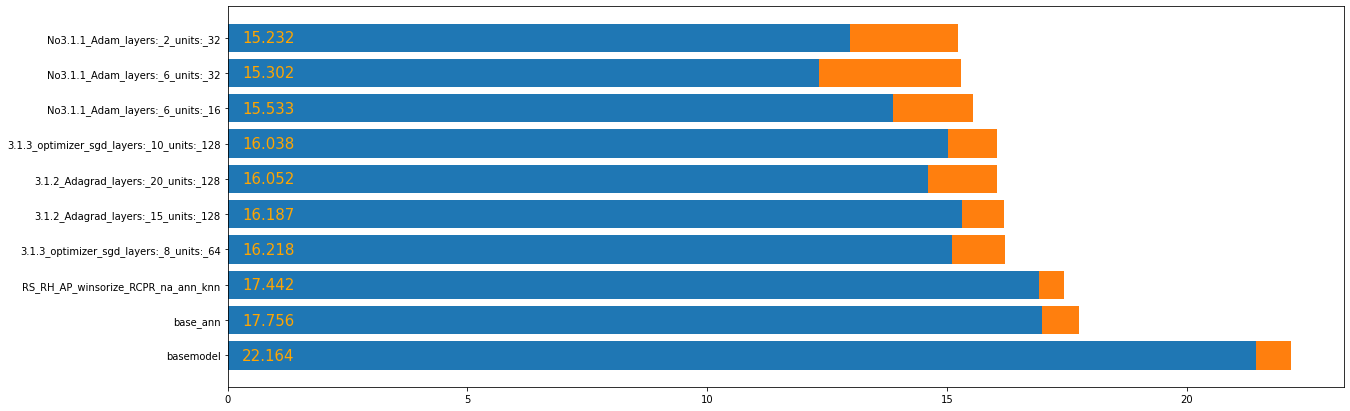

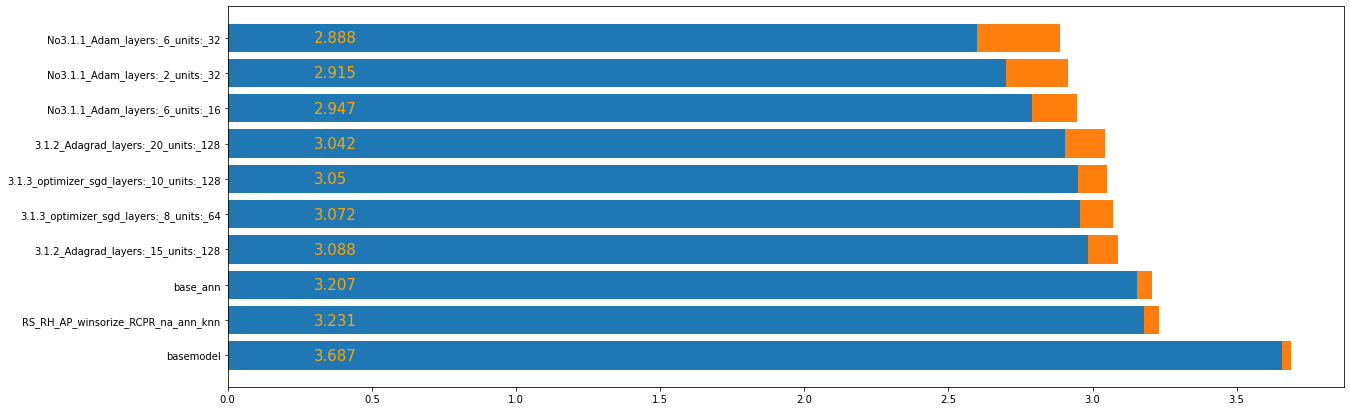

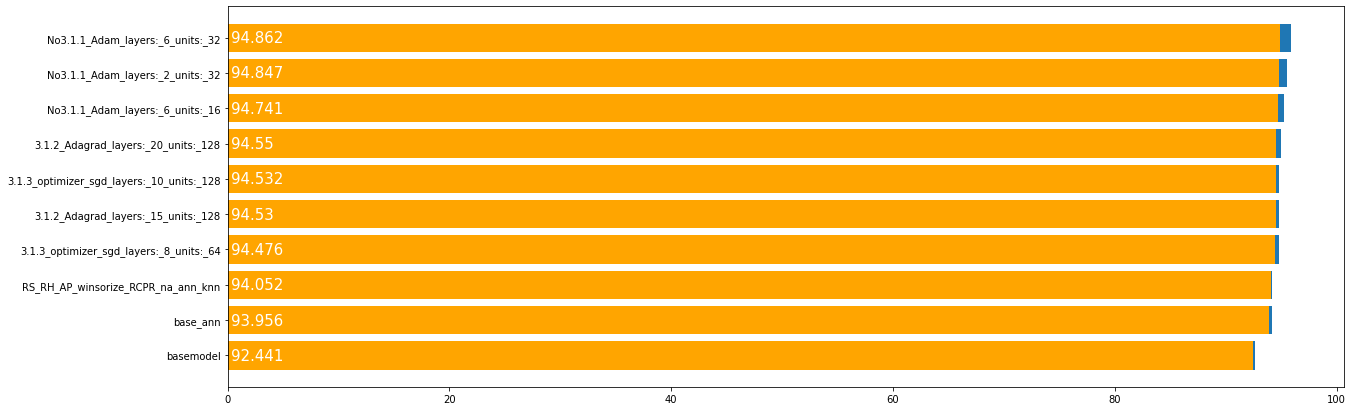

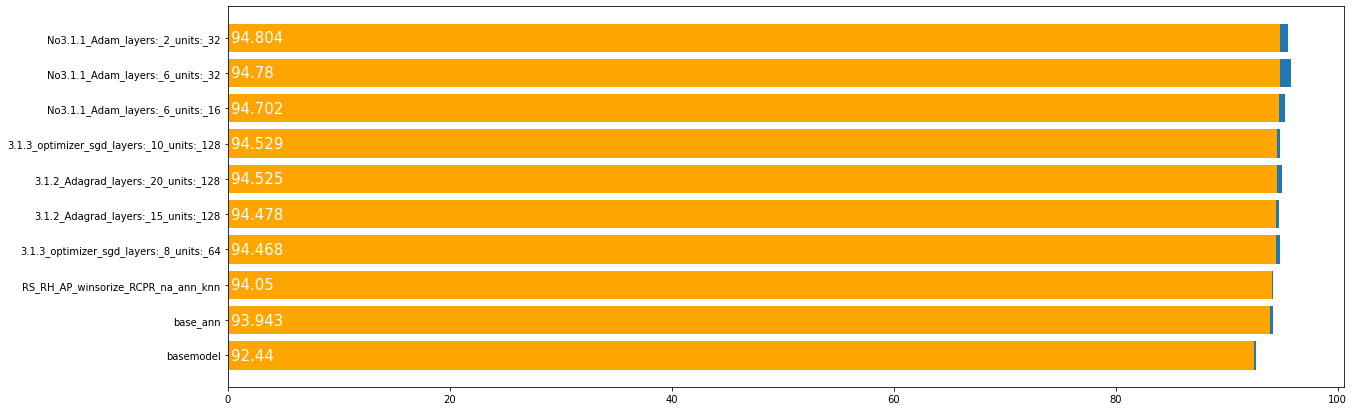

In [ ]:
update_results(True)
show_results()

### RMSProp


Epoch 1: val_loss improved from inf to 0.31677, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_2_units:_6.hdf5

Epoch 2: val_loss improved from 0.31677 to 0.24629, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_2_units:_6.hdf5

Epoch 3: val_loss improved from 0.24629 to 0.20147, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_2_units:_6.hdf5

Epoch 4: val_loss improved from 0.20147 to 0.15987, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_2_units:_6.hdf5

Epoch 5: val_loss improved from 0.15987 to 0.12075, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_r

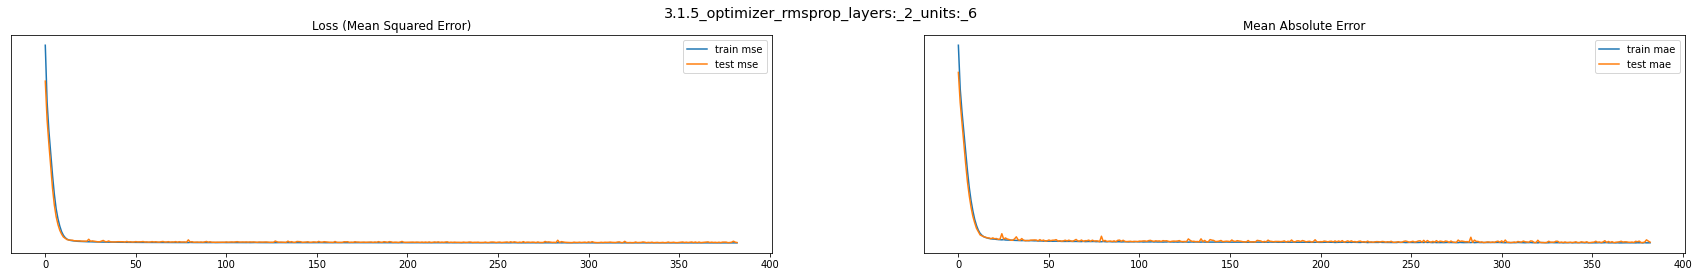

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_2_units:_6              17.057   
1   test:_3.1.5_optimizer_rmsprop_layers:_2_units:_6              17.485   
2         3.1.5_optimizer_rmsprop_layers:_2_units:_6               0.428   

   mean_absolute_error  r2_score  e_v_score  
0                3.213    94.127     94.131  
1                3.230    94.036     94.041  
2                0.018     0.091      0.090  

Epoch 1: val_loss improved from inf to 0.21171, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_2_units:_8.hdf5

Epoch 2: val_loss improved from 0.21171 to 0.12506, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_2_units:_8.hdf5

Epoch 3: val_loss improved from 0.12506 to 0.07089, saving model to /content/drive/MyDrive/Colab Not

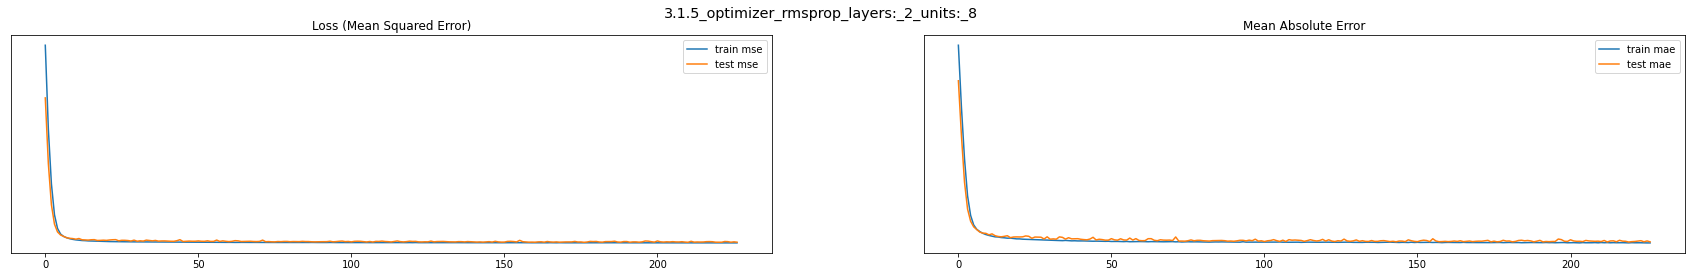

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_2_units:_8              16.594   
1   test:_3.1.5_optimizer_rmsprop_layers:_2_units:_8              17.329   
2         3.1.5_optimizer_rmsprop_layers:_2_units:_8               0.735   

   mean_absolute_error  r2_score  e_v_score  
0                3.127    94.286     94.287  
1                3.184    94.089     94.089  
2                0.056     0.197      0.198  

Epoch 1: val_loss improved from inf to 0.20728, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_2_units:_16.hdf5

Epoch 2: val_loss improved from 0.20728 to 0.08876, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_2_units:_16.hdf5

Epoch 3: val_loss improved from 0.08876 to 0.04273, saving model to /content/drive/MyDrive/Colab N

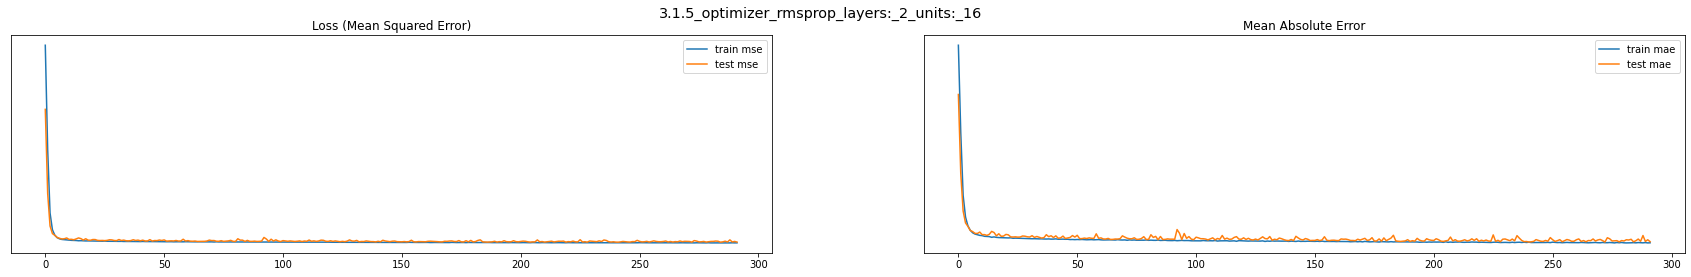

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_2_units...              15.122   
1  test:_3.1.5_optimizer_rmsprop_layers:_2_units:_16              16.084   
2        3.1.5_optimizer_rmsprop_layers:_2_units:_16               0.962   

   mean_absolute_error  r2_score  e_v_score  
0                2.954    94.793     94.828  
1                3.019    94.514     94.549  
2                0.066     0.279      0.279  

Epoch 1: val_loss improved from inf to 0.04049, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_2_units:_32.hdf5

Epoch 2: val_loss improved from 0.04049 to 0.02488, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_2_units:_32.hdf5

Epoch 3: val_loss improved from 0.02488 to 0.02425, saving model to /content/drive/MyDrive/Colab N

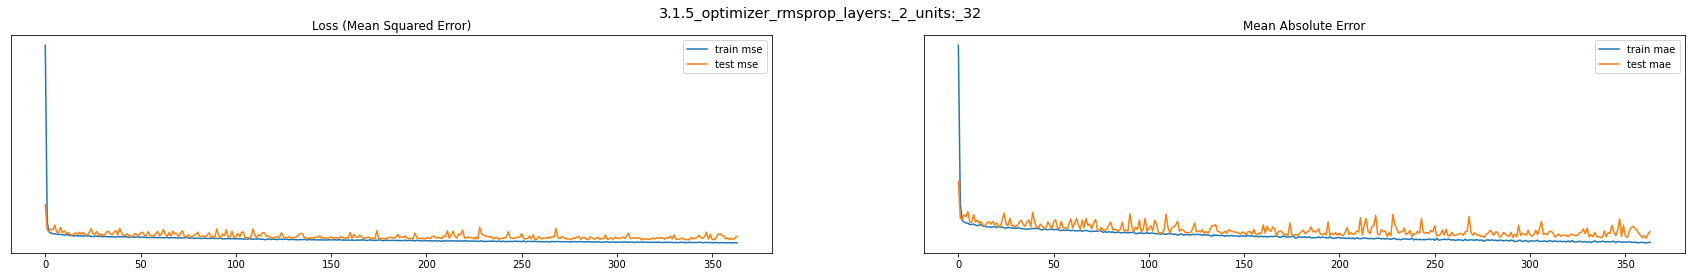

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_2_units...              15.059   
1  test:_3.1.5_optimizer_rmsprop_layers:_2_units:_32              16.920   
2        3.1.5_optimizer_rmsprop_layers:_2_units:_32               1.861   

   mean_absolute_error  r2_score  e_v_score  
0                2.918    94.815     95.357  
1                3.065    94.228     94.729  
2                0.148     0.587      0.628  

Epoch 1: val_loss improved from inf to 0.02980, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_2_units:_64.hdf5

Epoch 2: val_loss improved from 0.02980 to 0.02390, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_2_units:_64.hdf5

Epoch 3: val_loss did not improve from 0.02390

Epoch 4: val_loss did not improve from 0.02390

Ep

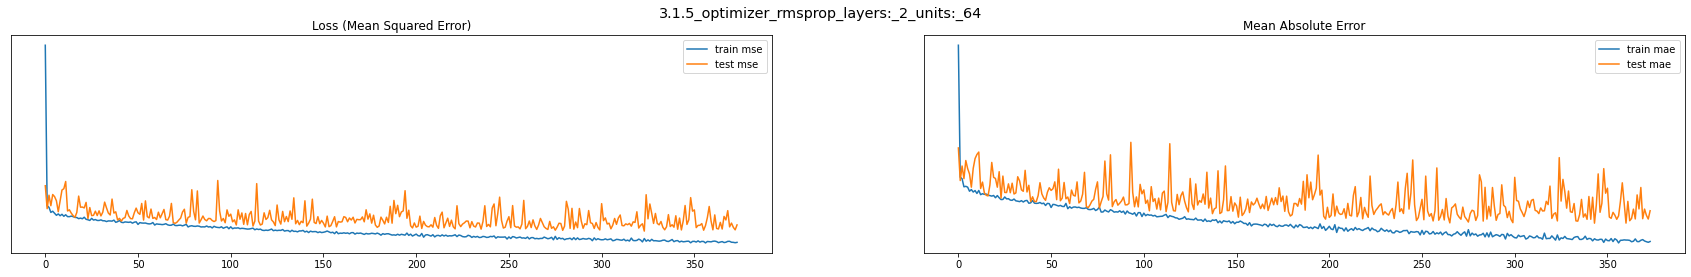

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_2_units...              13.074   
1  test:_3.1.5_optimizer_rmsprop_layers:_2_units:_64              15.844   
2        3.1.5_optimizer_rmsprop_layers:_2_units:_64               2.770   

   mean_absolute_error  r2_score  e_v_score  
0                2.733    95.498     95.975  
1                3.000    94.595     95.053  
2                0.268     0.903      0.922  

Epoch 1: val_loss improved from inf to 0.03008, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_2_units:_128.hdf5

Epoch 2: val_loss improved from 0.03008 to 0.02487, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_2_units:_128.hdf5

Epoch 3: val_loss improved from 0.02487 to 0.02309, saving model to /content/drive/MyDrive/Colab

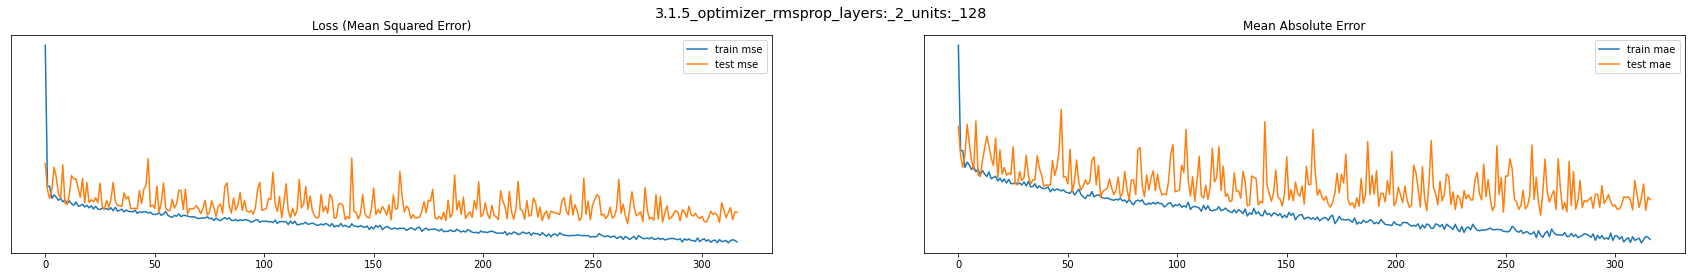

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_2_units...              12.399   
1  test:_3.1.5_optimizer_rmsprop_layers:_2_units:...              16.345   
2       3.1.5_optimizer_rmsprop_layers:_2_units:_128               3.946   

   mean_absolute_error  r2_score  e_v_score  
0                2.596    95.731     95.924  
1                2.975    94.424     94.634  
2                0.379     1.307      1.290  

Epoch 1: val_loss improved from inf to 0.22970, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_4_units:_6.hdf5

Epoch 2: val_loss improved from 0.22970 to 0.20509, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_4_units:_6.hdf5

Epoch 3: val_loss improved from 0.20509 to 0.18566, saving model to /content/drive/MyDrive/Colab Not

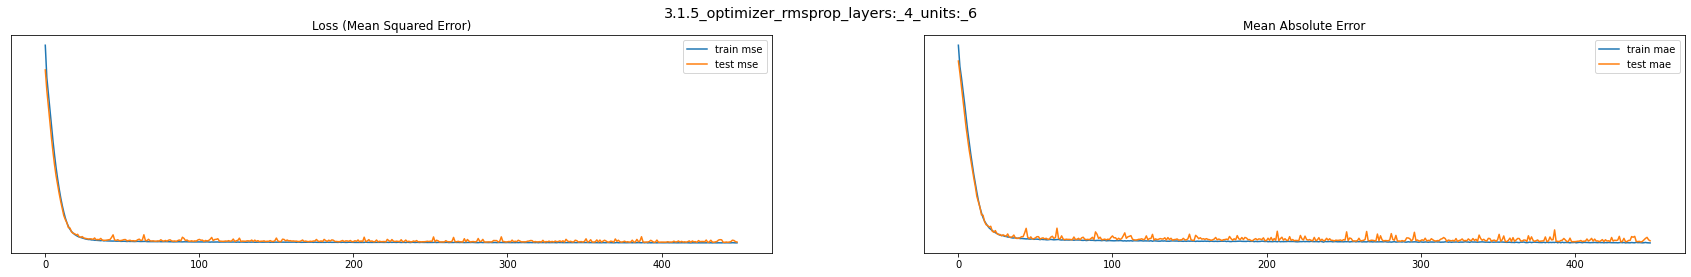

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_4_units:_6              17.039   
1   test:_3.1.5_optimizer_rmsprop_layers:_4_units:_6              17.695   
2         3.1.5_optimizer_rmsprop_layers:_4_units:_6               0.656   

   mean_absolute_error  r2_score  e_v_score  
0                3.206    94.133     94.239  
1                3.261    93.964     94.075  
2                0.055     0.169      0.164  

Epoch 1: val_loss improved from inf to 0.36818, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_4_units:_8.hdf5

Epoch 2: val_loss improved from 0.36818 to 0.27929, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_4_units:_8.hdf5

Epoch 3: val_loss improved from 0.27929 to 0.18633, saving model to /content/drive/MyDrive/Colab Not

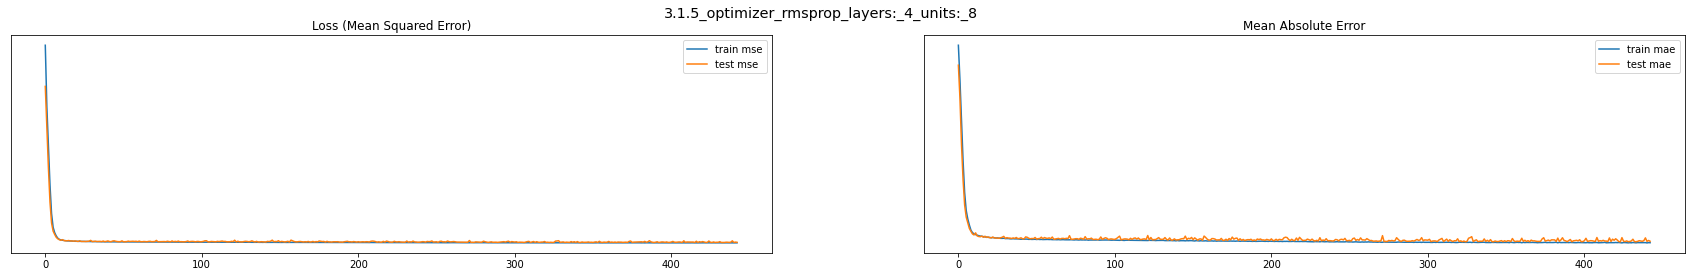

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_4_units:_8              15.872   
1   test:_3.1.5_optimizer_rmsprop_layers:_4_units:_8              16.724   
2         3.1.5_optimizer_rmsprop_layers:_4_units:_8               0.852   

   mean_absolute_error  r2_score  e_v_score  
0                3.026    94.535     94.653  
1                3.115    94.295     94.429  
2                0.088     0.240      0.224  

Epoch 1: val_loss improved from inf to 0.11367, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_4_units:_16.hdf5

Epoch 2: val_loss improved from 0.11367 to 0.05104, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_4_units:_16.hdf5

Epoch 3: val_loss improved from 0.05104 to 0.03258, saving model to /content/drive/MyDrive/Colab N

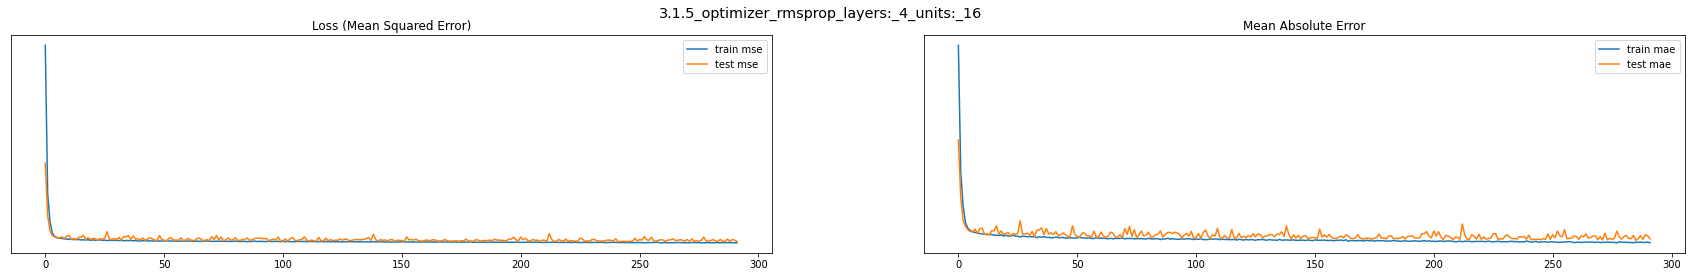

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_4_units...              15.067   
1  test:_3.1.5_optimizer_rmsprop_layers:_4_units:_16              16.411   
2        3.1.5_optimizer_rmsprop_layers:_4_units:_16               1.344   

   mean_absolute_error  r2_score  e_v_score  
0                2.966    94.812     94.976  
1                3.100    94.402     94.564  
2                0.134     0.410      0.412  

Epoch 1: val_loss improved from inf to 0.02769, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_4_units:_32.hdf5

Epoch 2: val_loss improved from 0.02769 to 0.02376, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_4_units:_32.hdf5

Epoch 3: val_loss did not improve from 0.02376

Epoch 4: val_loss did not improve from 0.02376

Ep

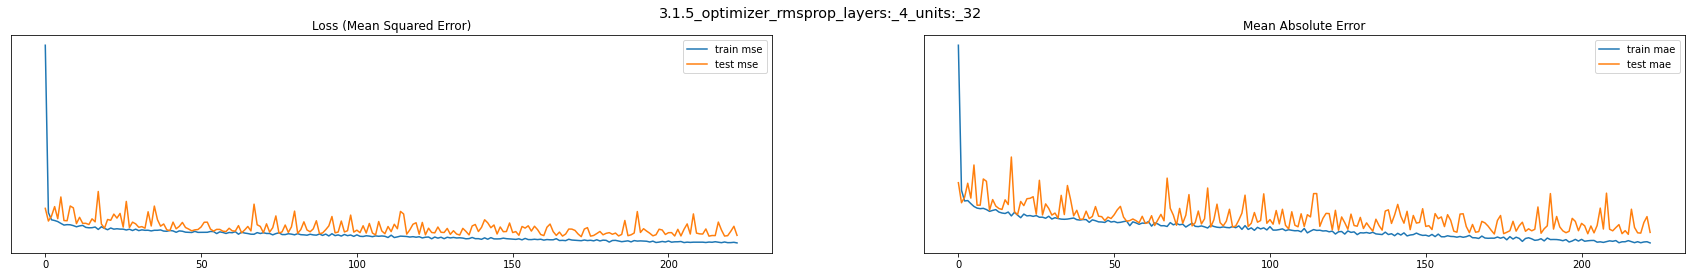

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_4_units...              13.504   
1  test:_3.1.5_optimizer_rmsprop_layers:_4_units:_32              15.541   
2        3.1.5_optimizer_rmsprop_layers:_4_units:_32               2.037   

   mean_absolute_error  r2_score  e_v_score  
0                2.744    95.350     95.364  
1                2.927    94.699     94.710  
2                0.183     0.651      0.654  

Epoch 1: val_loss improved from inf to 0.02863, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_4_units:_64.hdf5

Epoch 2: val_loss improved from 0.02863 to 0.02360, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_4_units:_64.hdf5

Epoch 3: val_loss improved from 0.02360 to 0.02322, saving model to /content/drive/MyDrive/Colab N

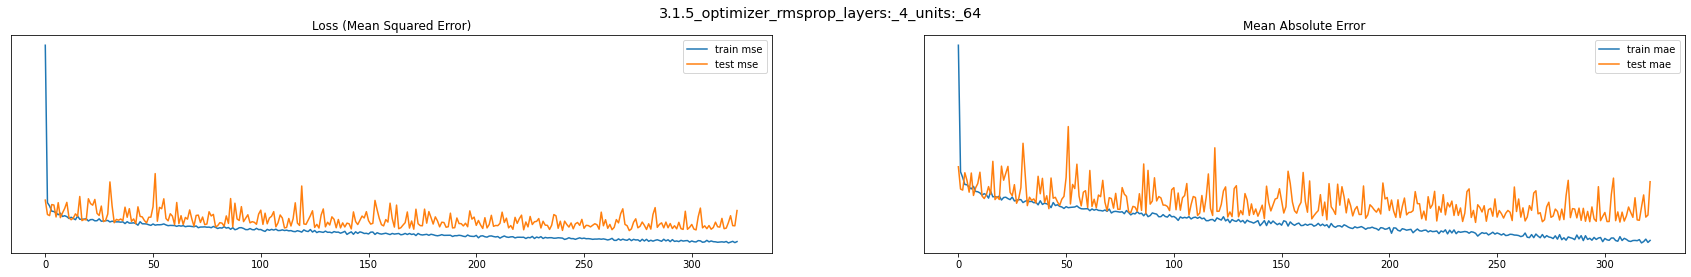

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_4_units...              16.419   
1  test:_3.1.5_optimizer_rmsprop_layers:_4_units:_64              20.093   
2        3.1.5_optimizer_rmsprop_layers:_4_units:_64               3.674   

   mean_absolute_error  r2_score  e_v_score  
0                3.180    94.347     95.297  
1                3.502    93.146     94.069  
2                0.322     1.201      1.228  

Epoch 1: val_loss improved from inf to 0.02672, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_4_units:_128.hdf5

Epoch 2: val_loss did not improve from 0.02672

Epoch 3: val_loss improved from 0.02672 to 0.02669, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_4_units:_128.hdf5

Epoch 4: val_loss did not improve from 0.02669



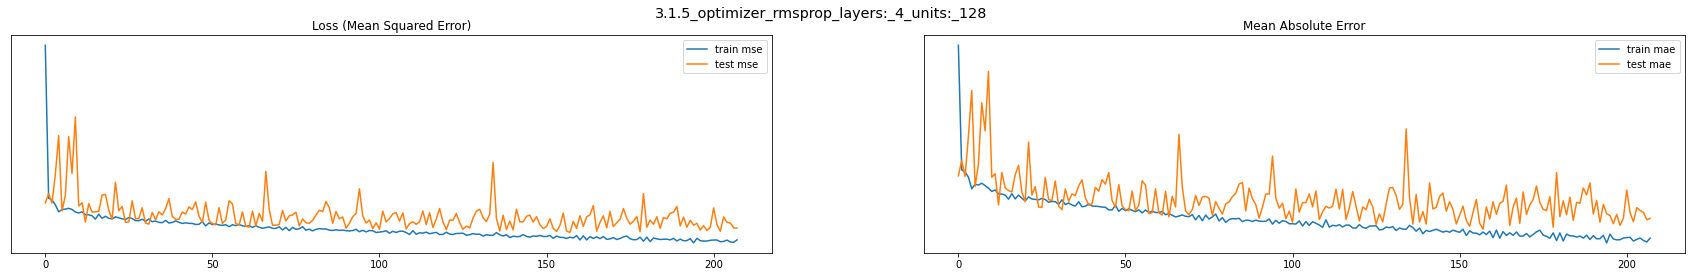

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_4_units...              12.943   
1  test:_3.1.5_optimizer_rmsprop_layers:_4_units:...              15.733   
2       3.1.5_optimizer_rmsprop_layers:_4_units:_128               2.791   

   mean_absolute_error  r2_score  e_v_score  
0                2.721    95.544     95.762  
1                2.981    94.633     94.847  
2                0.260     0.911      0.915  

Epoch 1: val_loss improved from inf to 0.31049, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_6_units:_6.hdf5

Epoch 2: val_loss improved from 0.31049 to 0.22905, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_6_units:_6.hdf5

Epoch 3: val_loss improved from 0.22905 to 0.14022, saving model to /content/drive/MyDrive/Colab Not

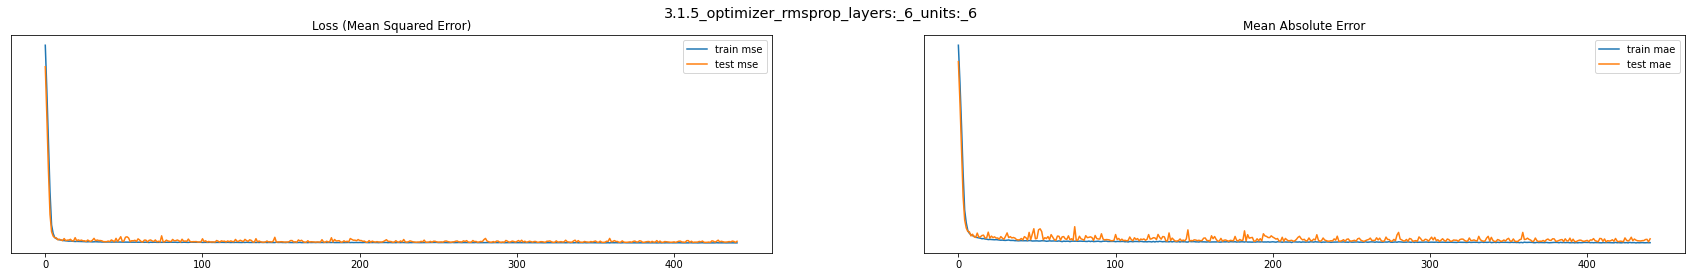

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_6_units:_6              18.273   
1   test:_3.1.5_optimizer_rmsprop_layers:_6_units:_6              18.987   
2         3.1.5_optimizer_rmsprop_layers:_6_units:_6               0.714   

   mean_absolute_error  r2_score  e_v_score  
0                3.334    93.708     94.165  
1                3.389    93.523     93.981  
2                0.055     0.185      0.184  

Epoch 1: val_loss improved from inf to 0.32339, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_6_units:_8.hdf5

Epoch 2: val_loss improved from 0.32339 to 0.25598, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_6_units:_8.hdf5

Epoch 3: val_loss improved from 0.25598 to 0.16074, saving model to /content/drive/MyDrive/Colab Not

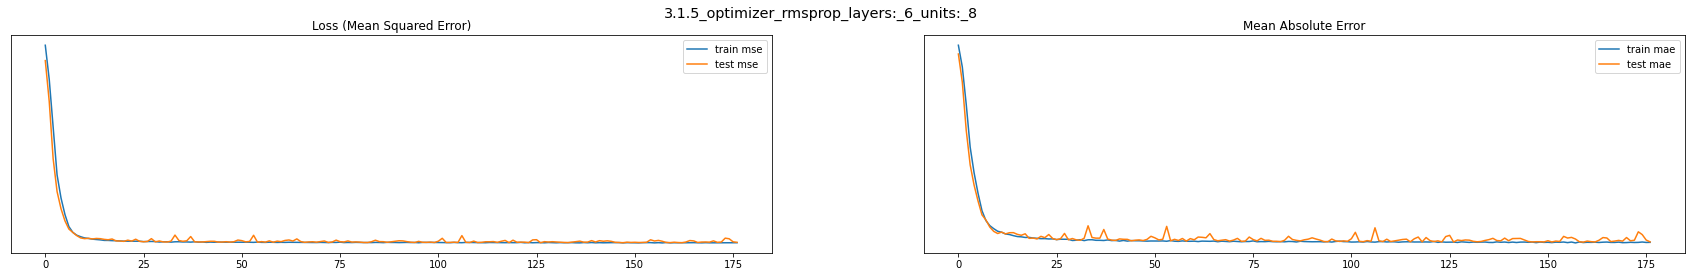

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_6_units:_8              17.191   
1   test:_3.1.5_optimizer_rmsprop_layers:_6_units:_8              17.808   
2         3.1.5_optimizer_rmsprop_layers:_6_units:_8               0.617   

   mean_absolute_error  r2_score  e_v_score  
0                3.154    94.081     94.084  
1                3.229    93.925     93.929  
2                0.075     0.156      0.155  

Epoch 1: val_loss improved from inf to 0.07700, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_6_units:_16.hdf5

Epoch 2: val_loss improved from 0.07700 to 0.04793, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_6_units:_16.hdf5

Epoch 3: val_loss improved from 0.04793 to 0.03868, saving model to /content/drive/MyDrive/Colab N

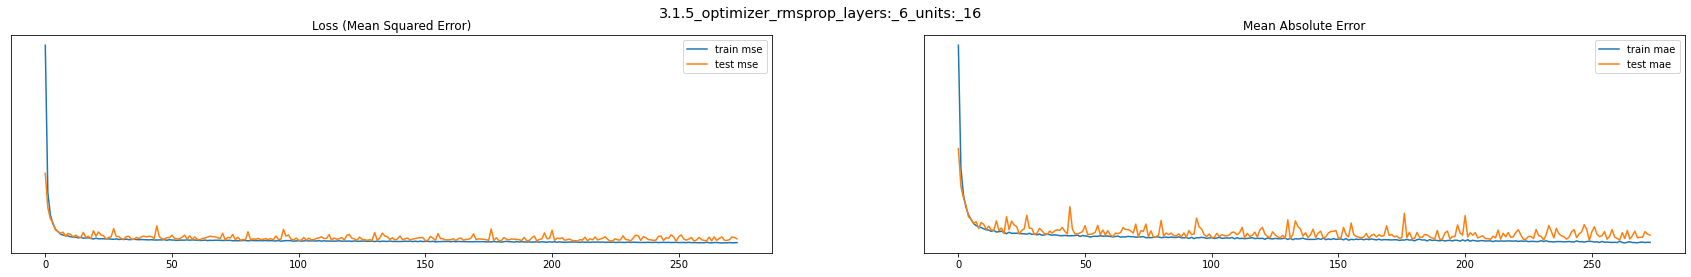

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_6_units...              15.747   
1  test:_3.1.5_optimizer_rmsprop_layers:_6_units:_16              17.509   
2        3.1.5_optimizer_rmsprop_layers:_6_units:_16               1.762   

   mean_absolute_error  r2_score  e_v_score  
0                3.031    94.578     94.984  
1                3.167    94.027     94.436  
2                0.136     0.551      0.548  

Epoch 1: val_loss improved from inf to 0.03393, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_6_units:_32.hdf5

Epoch 2: val_loss improved from 0.03393 to 0.02682, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_6_units:_32.hdf5

Epoch 3: val_loss improved from 0.02682 to 0.02351, saving model to /content/drive/MyDrive/Colab N

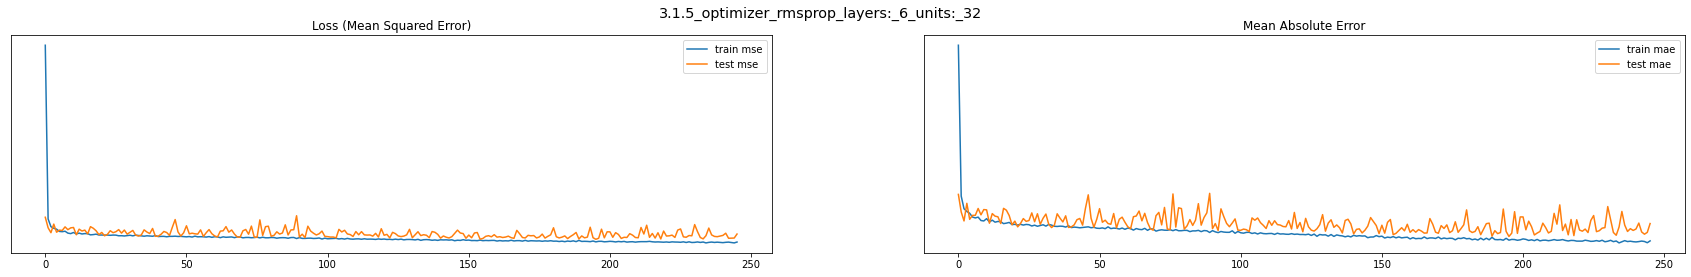

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_6_units...              16.270   
1  test:_3.1.5_optimizer_rmsprop_layers:_6_units:_32              18.171   
2        3.1.5_optimizer_rmsprop_layers:_6_units:_32               1.901   

   mean_absolute_error  r2_score  e_v_score  
0                3.095    94.398     94.585  
1                3.253    93.802     93.992  
2                0.158     0.596      0.593  

Epoch 1: val_loss improved from inf to 0.05753, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_6_units:_64.hdf5

Epoch 2: val_loss improved from 0.05753 to 0.02871, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_6_units:_64.hdf5

Epoch 3: val_loss improved from 0.02871 to 0.02321, saving model to /content/drive/MyDrive/Colab N

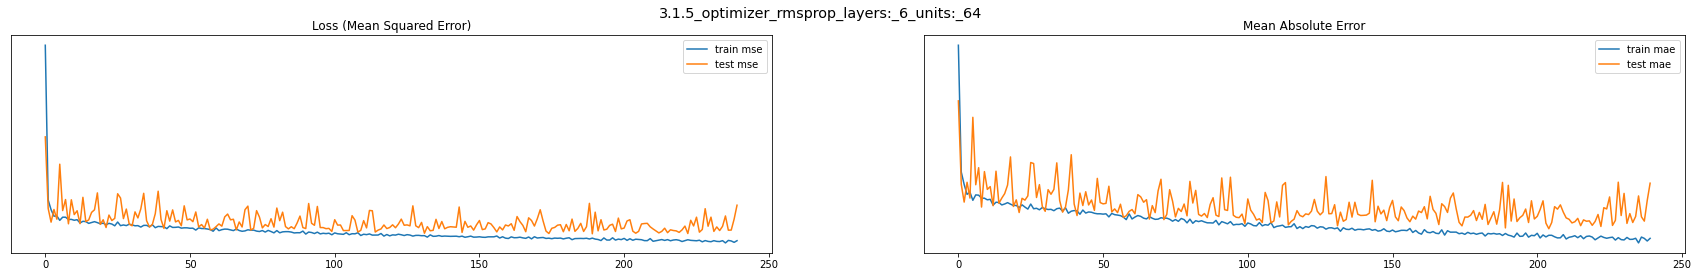

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_6_units...              20.456   
1  test:_3.1.5_optimizer_rmsprop_layers:_6_units:_64              24.147   
2        3.1.5_optimizer_rmsprop_layers:_6_units:_64               3.691   

   mean_absolute_error  r2_score  e_v_score  
0                3.417    92.957     95.086  
1                3.727    91.763     93.996  
2                0.310     1.194      1.090  

Epoch 1: val_loss improved from inf to 0.03378, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_6_units:_128.hdf5

Epoch 2: val_loss did not improve from 0.03378

Epoch 3: val_loss improved from 0.03378 to 0.02791, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_6_units:_128.hdf5

Epoch 4: val_loss improved from 0.02791 to 0.023

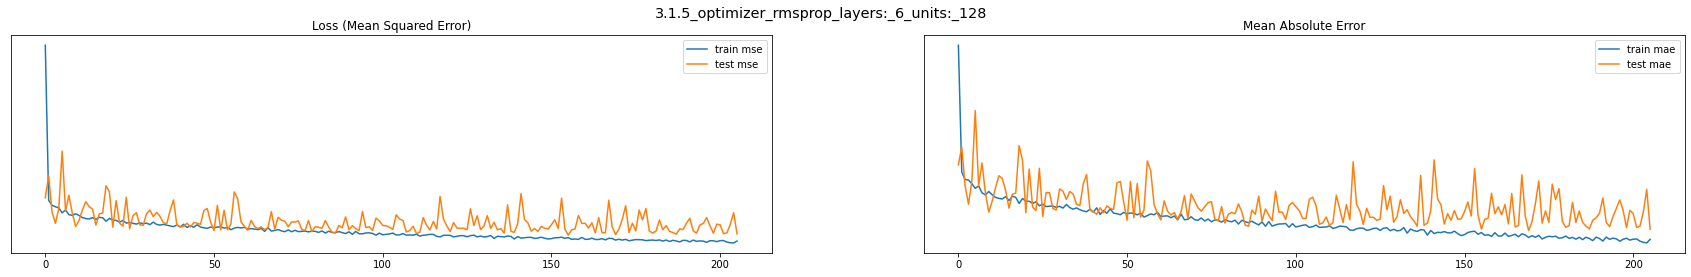

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_6_units...              11.931   
1  test:_3.1.5_optimizer_rmsprop_layers:_6_units:...              15.295   
2       3.1.5_optimizer_rmsprop_layers:_6_units:_128               3.364   

   mean_absolute_error  r2_score  e_v_score  
0                2.543    95.892     95.901  
1                2.874    94.783     94.789  
2                0.331     1.109      1.112  

Epoch 1: val_loss improved from inf to 0.27904, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_8_units:_6.hdf5

Epoch 2: val_loss improved from 0.27904 to 0.17373, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_8_units:_6.hdf5

Epoch 3: val_loss improved from 0.17373 to 0.08440, saving model to /content/drive/MyDrive/Colab Not

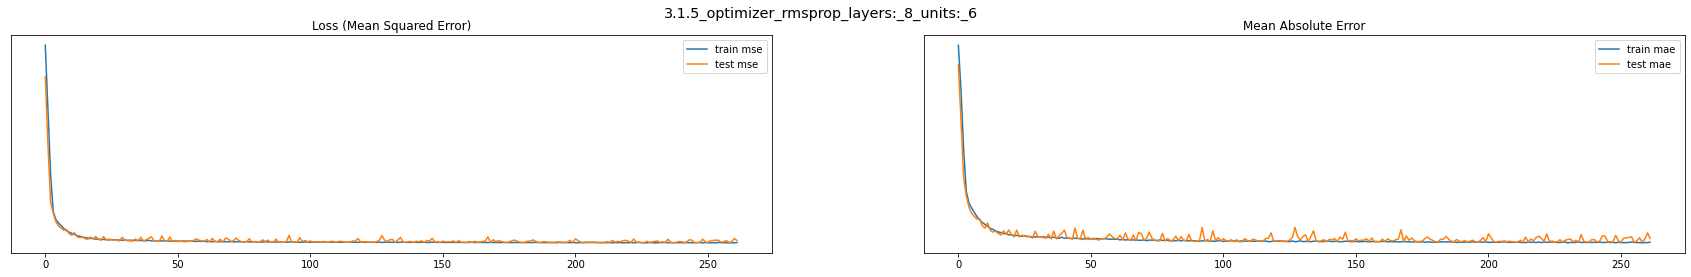

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_8_units:_6              19.203   
1   test:_3.1.5_optimizer_rmsprop_layers:_8_units:_6              19.876   
2         3.1.5_optimizer_rmsprop_layers:_8_units:_6               0.673   

   mean_absolute_error  r2_score  e_v_score  
0                3.342    93.388     94.088  
1                3.402    93.220     93.871  
2                0.060     0.168      0.217  

Epoch 1: val_loss improved from inf to 0.25328, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_8_units:_8.hdf5

Epoch 2: val_loss improved from 0.25328 to 0.19421, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_8_units:_8.hdf5

Epoch 3: val_loss improved from 0.19421 to 0.16101, saving model to /content/drive/MyDrive/Colab Not

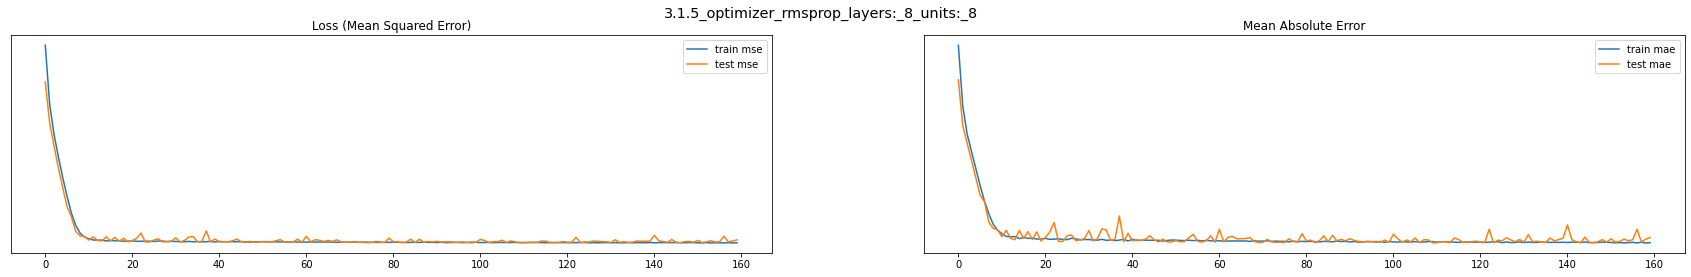

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_8_units:_8              19.838   
1   test:_3.1.5_optimizer_rmsprop_layers:_8_units:_8              20.540   
2         3.1.5_optimizer_rmsprop_layers:_8_units:_8               0.702   

   mean_absolute_error  r2_score  e_v_score  
0                3.424    93.169     94.151  
1                3.448    92.993     93.967  
2                0.024     0.176      0.184  

Epoch 1: val_loss improved from inf to 0.11549, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_8_units:_16.hdf5

Epoch 2: val_loss improved from 0.11549 to 0.03427, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_8_units:_16.hdf5

Epoch 3: val_loss improved from 0.03427 to 0.02795, saving model to /content/drive/MyDrive/Colab N

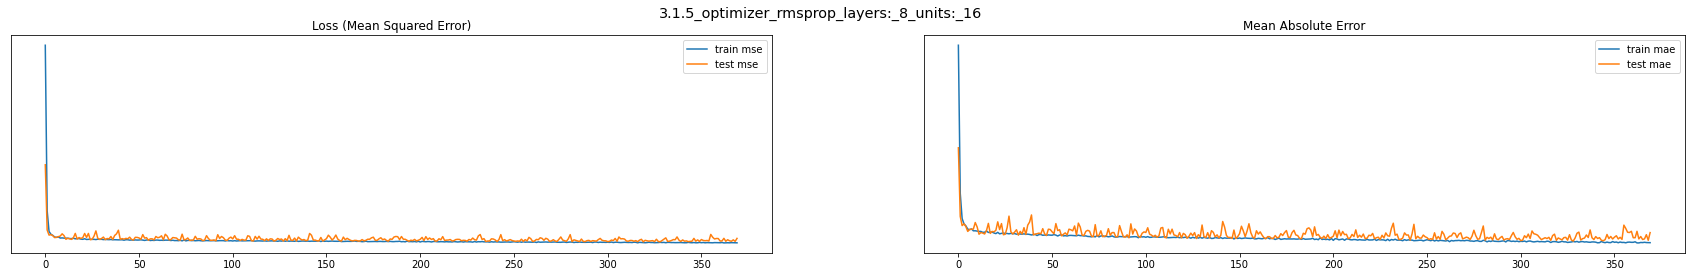

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_8_units...              17.841   
1  test:_3.1.5_optimizer_rmsprop_layers:_8_units:_16              19.177   
2        3.1.5_optimizer_rmsprop_layers:_8_units:_16               1.336   

   mean_absolute_error  r2_score  e_v_score  
0                3.263    93.857     94.486  
1                3.357    93.458     94.094  
2                0.094     0.399      0.392  

Epoch 1: val_loss improved from inf to 0.04792, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_8_units:_32.hdf5

Epoch 2: val_loss improved from 0.04792 to 0.03262, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_8_units:_32.hdf5

Epoch 3: val_loss improved from 0.03262 to 0.02819, saving model to /content/drive/MyDrive/Colab N

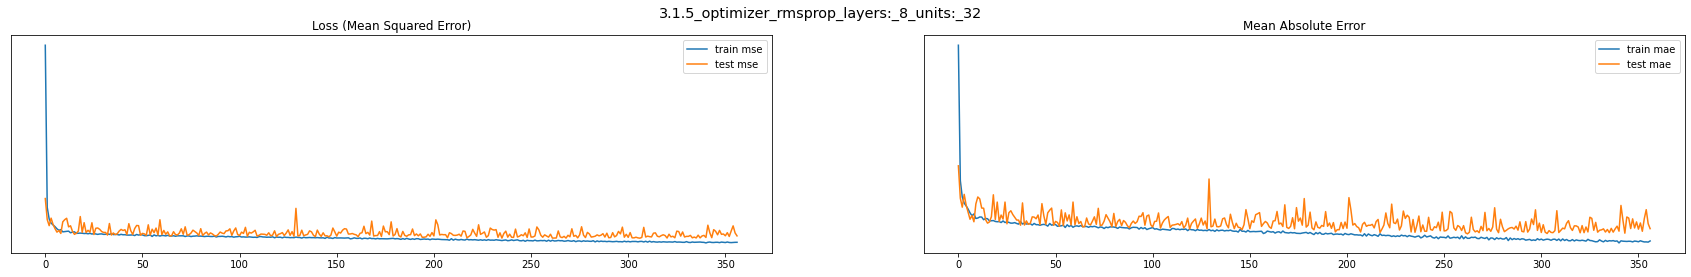

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_8_units...              13.777   
1  test:_3.1.5_optimizer_rmsprop_layers:_8_units:_32              16.675   
2        3.1.5_optimizer_rmsprop_layers:_8_units:_32               2.897   

   mean_absolute_error  r2_score  e_v_score  
0                2.805    95.256      95.79  
1                3.061    94.312      94.82  
2                0.256     0.944       0.97  

Epoch 1: val_loss improved from inf to 0.03494, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_8_units:_64.hdf5

Epoch 2: val_loss improved from 0.03494 to 0.02727, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_8_units:_64.hdf5

Epoch 3: val_loss did not improve from 0.02727

Epoch 4: val_loss did not improve from 0.02727

Ep

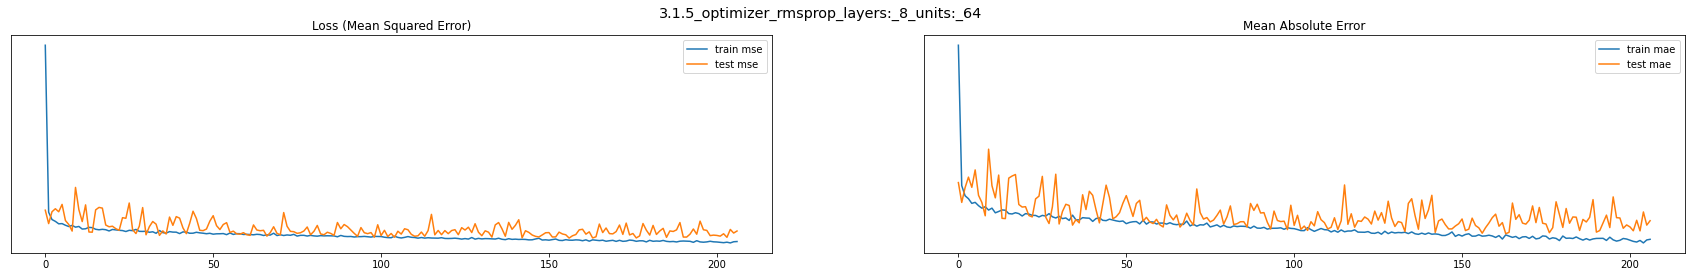

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_8_units...              15.855   
1  test:_3.1.5_optimizer_rmsprop_layers:_8_units:_64              18.514   
2        3.1.5_optimizer_rmsprop_layers:_8_units:_64               2.659   

   mean_absolute_error  r2_score  e_v_score  
0                2.981    94.541     94.666  
1                3.209    93.685     93.804  
2                0.228     0.856      0.862  

Epoch 1: val_loss improved from inf to 0.04186, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_8_units:_128.hdf5

Epoch 2: val_loss improved from 0.04186 to 0.03069, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_8_units:_128.hdf5

Epoch 3: val_loss improved from 0.03069 to 0.02494, saving model to /content/drive/MyDrive/Colab

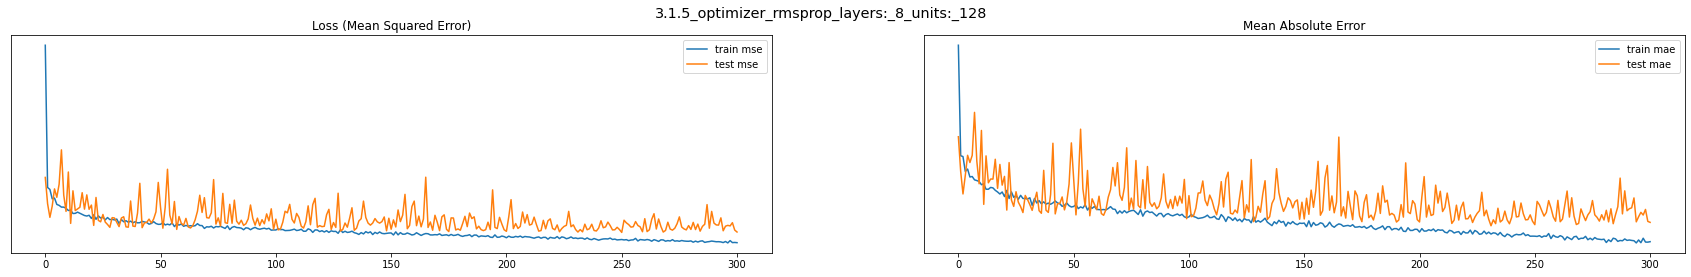

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_8_units...              11.167   
1  test:_3.1.5_optimizer_rmsprop_layers:_8_units:...              15.052   
2       3.1.5_optimizer_rmsprop_layers:_8_units:_128               3.885   

   mean_absolute_error  r2_score  e_v_score  
0                2.499    96.155     96.189  
1                2.903    94.866     94.918  
2                0.404     1.289      1.271  

Epoch 1: val_loss improved from inf to 0.27992, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_10_units:_6.hdf5

Epoch 2: val_loss improved from 0.27992 to 0.19422, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_10_units:_6.hdf5

Epoch 3: val_loss improved from 0.19422 to 0.14489, saving model to /content/drive/MyDrive/Colab N

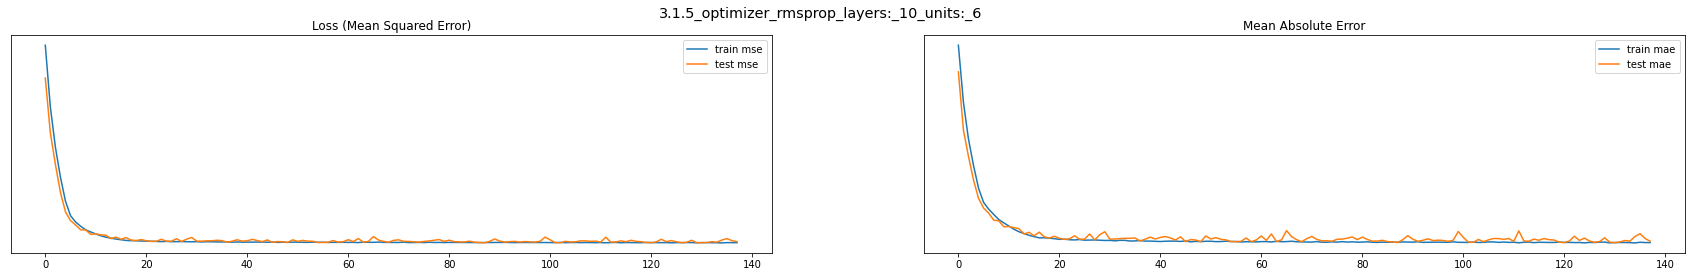

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_10_unit...              18.524   
1  test:_3.1.5_optimizer_rmsprop_layers:_10_units:_6              19.206   
2        3.1.5_optimizer_rmsprop_layers:_10_units:_6               0.682   

   mean_absolute_error  r2_score  e_v_score  
0                3.301    93.622     93.831  
1                3.362    93.448     93.640  
2                0.061     0.174      0.191  

Epoch 1: val_loss improved from inf to 0.36443, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_10_units:_8.hdf5

Epoch 2: val_loss improved from 0.36443 to 0.33467, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_10_units:_8.hdf5

Epoch 3: val_loss improved from 0.33467 to 0.20740, saving model to /content/drive/MyDrive/Colab N

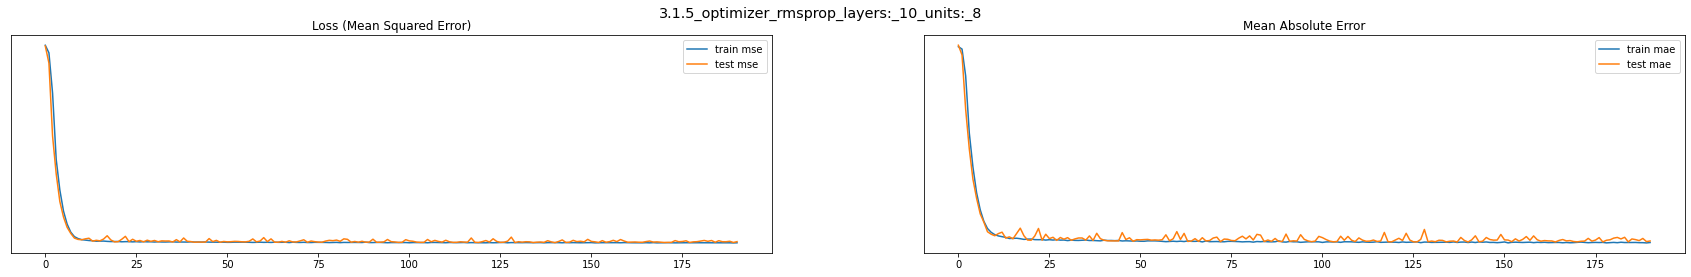

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_10_unit...               17.62   
1  test:_3.1.5_optimizer_rmsprop_layers:_10_units:_8               18.62   
2        3.1.5_optimizer_rmsprop_layers:_10_units:_8                1.00   

   mean_absolute_error  r2_score  e_v_score  
0                3.156    93.933     93.934  
1                3.260    93.649     93.650  
2                0.104     0.284      0.284  

Epoch 1: val_loss improved from inf to 0.25583, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_10_units:_16.hdf5

Epoch 2: val_loss improved from 0.25583 to 0.07825, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_10_units:_16.hdf5

Epoch 3: val_loss improved from 0.07825 to 0.06141, saving model to /content/drive/MyDrive/Colab

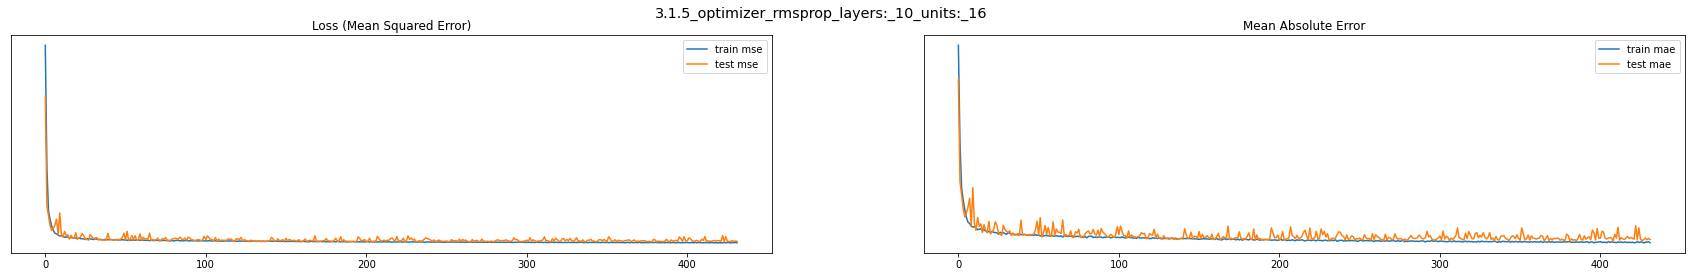

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_10_unit...              14.461   
1  test:_3.1.5_optimizer_rmsprop_layers:_10_units...              16.328   
2       3.1.5_optimizer_rmsprop_layers:_10_units:_16               1.866   

   mean_absolute_error  r2_score  e_v_score  
0                2.878    95.021     95.081  
1                3.045    94.430     94.466  
2                0.167     0.591      0.615  

Epoch 1: val_loss improved from inf to 0.09949, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_10_units:_32.hdf5

Epoch 2: val_loss improved from 0.09949 to 0.03333, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_10_units:_32.hdf5

Epoch 3: val_loss improved from 0.03333 to 0.03282, saving model to /content/drive/MyDrive/Colab

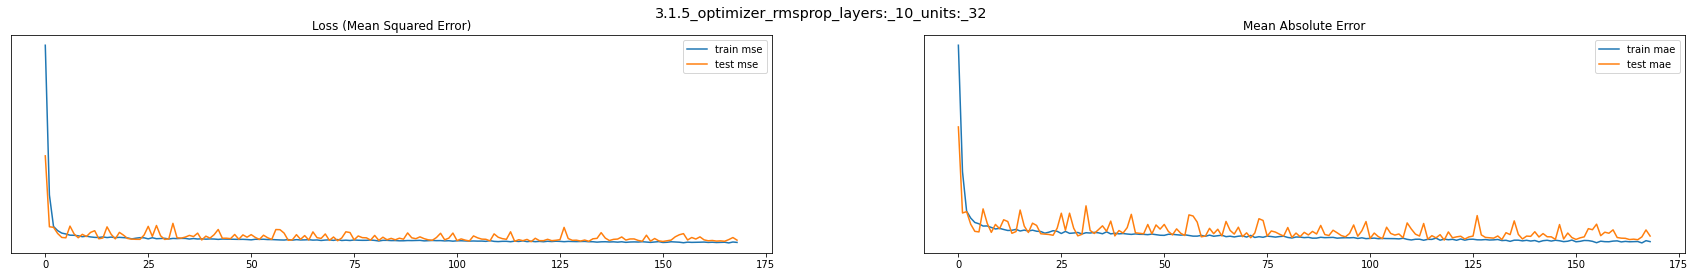

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_10_unit...              15.237   
1  test:_3.1.5_optimizer_rmsprop_layers:_10_units...              16.758   
2       3.1.5_optimizer_rmsprop_layers:_10_units:_32               1.520   

   mean_absolute_error  r2_score  e_v_score  
0                3.001    94.753     94.755  
1                3.141    94.284     94.286  
2                0.141     0.469      0.469  

Epoch 1: val_loss improved from inf to 0.03102, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_10_units:_64.hdf5

Epoch 2: val_loss did not improve from 0.03102

Epoch 3: val_loss improved from 0.03102 to 0.02611, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_10_units:_64.hdf5

Epoch 4: val_loss did not improve from 0.02611



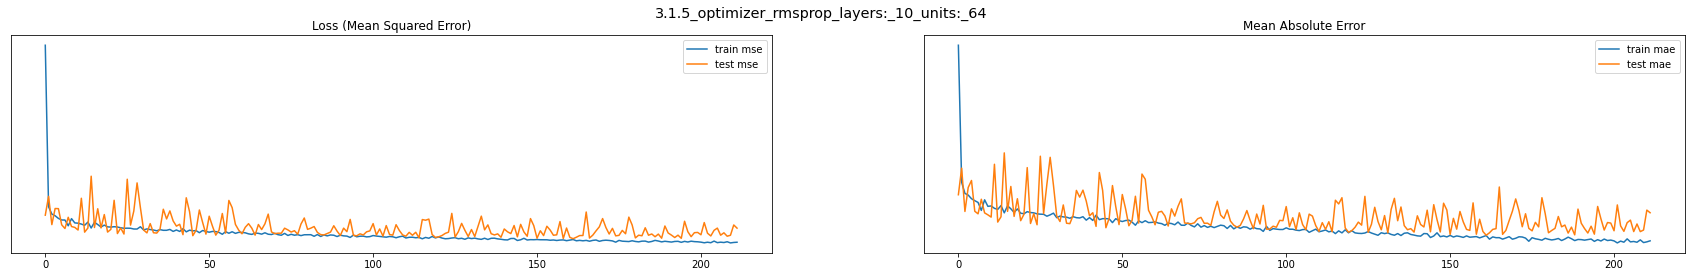

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_10_unit...              16.897   
1  test:_3.1.5_optimizer_rmsprop_layers:_10_units...              19.519   
2       3.1.5_optimizer_rmsprop_layers:_10_units:_64               2.621   

   mean_absolute_error  r2_score  e_v_score  
0                3.199    94.182     94.678  
1                3.431    93.342     93.834  
2                0.232     0.840      0.844  

Epoch 1: val_loss improved from inf to 0.03061, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_10_units:_128.hdf5

Epoch 2: val_loss did not improve from 0.03061

Epoch 3: val_loss improved from 0.03061 to 0.02399, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_10_units:_128.hdf5

Epoch 4: val_loss did not improve from 0.02399

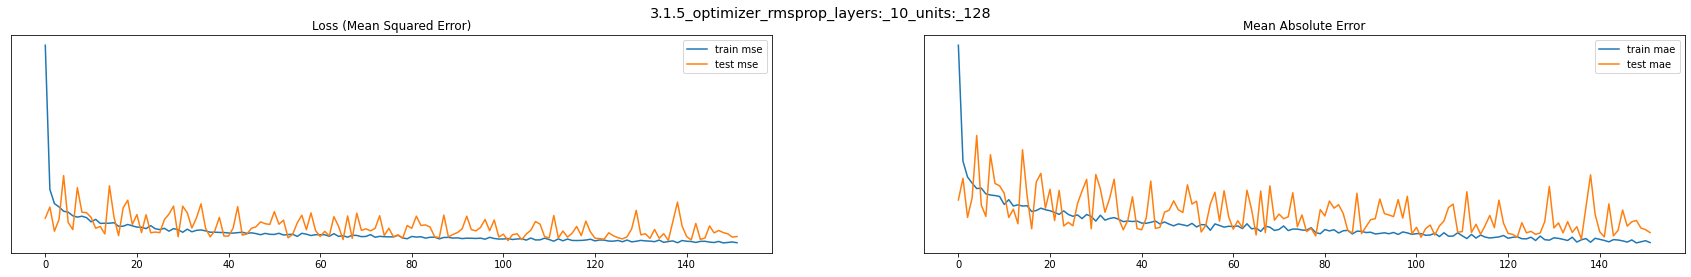

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_10_unit...              14.776   
1  test:_3.1.5_optimizer_rmsprop_layers:_10_units...              17.122   
2      3.1.5_optimizer_rmsprop_layers:_10_units:_128               2.345   

   mean_absolute_error  r2_score  e_v_score  
0                2.890    94.912     95.096  
1                3.087    94.160     94.350  
2                0.197     0.752      0.746  

Epoch 1: val_loss improved from inf to 0.36819, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_15_units:_6.hdf5

Epoch 2: val_loss improved from 0.36819 to 0.36608, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_15_units:_6.hdf5

Epoch 3: val_loss improved from 0.36608 to 0.36506, saving model to /content/drive/MyDrive/Colab N

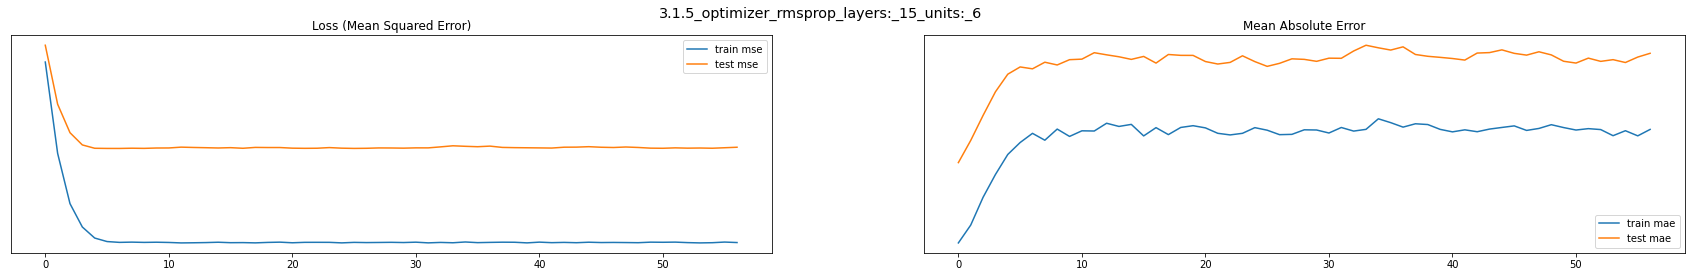

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_15_unit...             290.429   
1  test:_3.1.5_optimizer_rmsprop_layers:_15_units:_6             293.194   
2        3.1.5_optimizer_rmsprop_layers:_15_units:_6               2.765   

   mean_absolute_error  r2_score  e_v_score  
0               14.821    -0.001        0.0  
1               14.896    -0.012        0.0  
2                0.075     0.011        0.0  

Epoch 1: val_loss improved from inf to 0.36379, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_15_units:_8.hdf5

Epoch 2: val_loss improved from 0.36379 to 0.35430, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_15_units:_8.hdf5

Epoch 3: val_loss improved from 0.35430 to 0.28336, saving model to /content/drive/MyDrive/Colab N

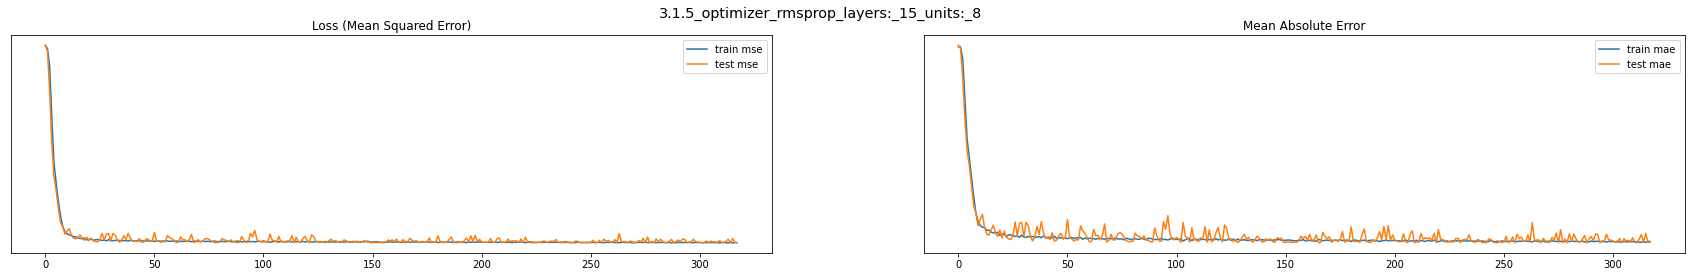

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_15_unit...              16.653   
1  test:_3.1.5_optimizer_rmsprop_layers:_15_units:_8              17.224   
2        3.1.5_optimizer_rmsprop_layers:_15_units:_8               0.571   

   mean_absolute_error  r2_score  e_v_score  
0                3.151    94.266     94.353  
1                3.189    94.125     94.200  
2                0.038     0.141      0.153  

Epoch 1: val_loss improved from inf to 0.12878, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_15_units:_16.hdf5

Epoch 2: val_loss improved from 0.12878 to 0.05199, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_15_units:_16.hdf5

Epoch 3: val_loss improved from 0.05199 to 0.03825, saving model to /content/drive/MyDrive/Colab

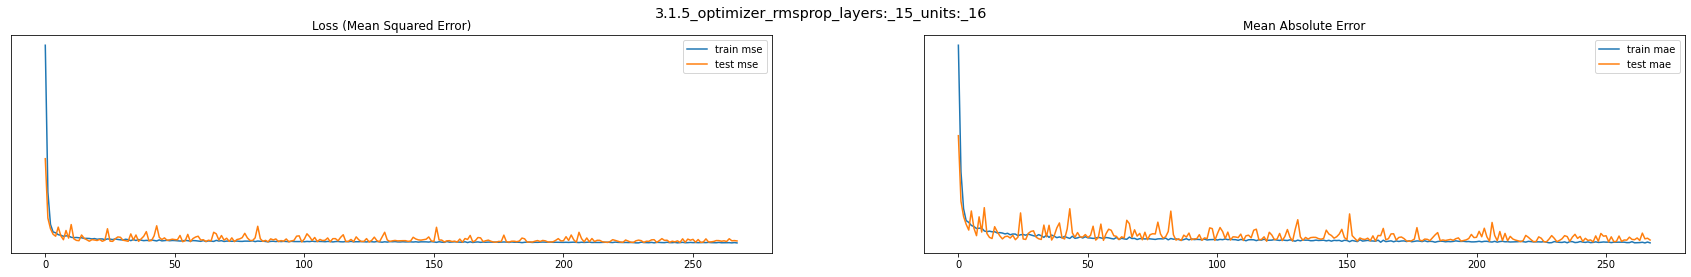

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_15_unit...              16.601   
1  test:_3.1.5_optimizer_rmsprop_layers:_15_units...              18.016   
2       3.1.5_optimizer_rmsprop_layers:_15_units:_16               1.415   

   mean_absolute_error  r2_score  e_v_score  
0                3.040    94.284     94.547  
1                3.181    93.855     94.120  
2                0.141     0.429      0.427  

Epoch 1: val_loss improved from inf to 0.14332, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_15_units:_32.hdf5

Epoch 2: val_loss improved from 0.14332 to 0.08048, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_15_units:_32.hdf5

Epoch 3: val_loss improved from 0.08048 to 0.03746, saving model to /content/drive/MyDrive/Colab

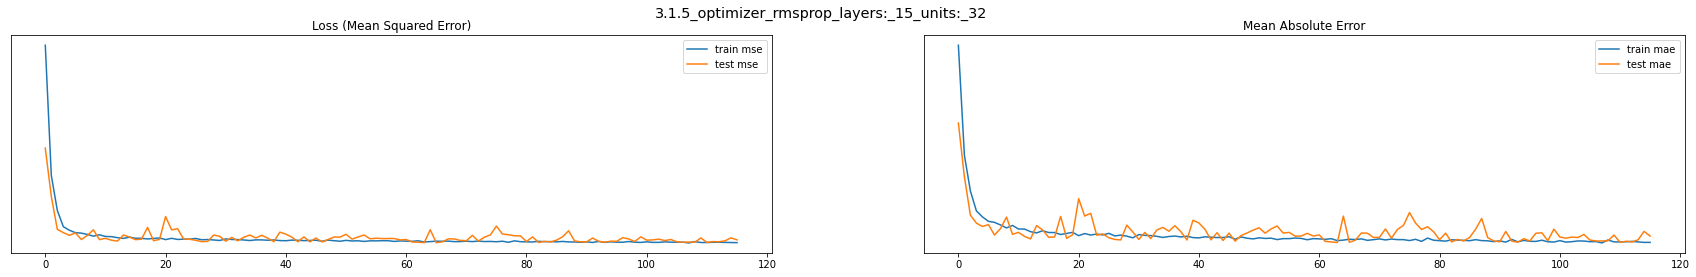

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_15_unit...              17.299   
1  test:_3.1.5_optimizer_rmsprop_layers:_15_units...              19.065   
2       3.1.5_optimizer_rmsprop_layers:_15_units:_32               1.766   

   mean_absolute_error  r2_score  e_v_score  
0                3.224    94.044     94.905  
1                3.360    93.497     94.338  
2                0.136     0.547      0.567  

Epoch 1: val_loss improved from inf to 0.05828, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_15_units:_64.hdf5

Epoch 2: val_loss improved from 0.05828 to 0.03904, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_15_units:_64.hdf5

Epoch 3: val_loss did not improve from 0.03904

Epoch 4: val_loss did not improve from 0.03904



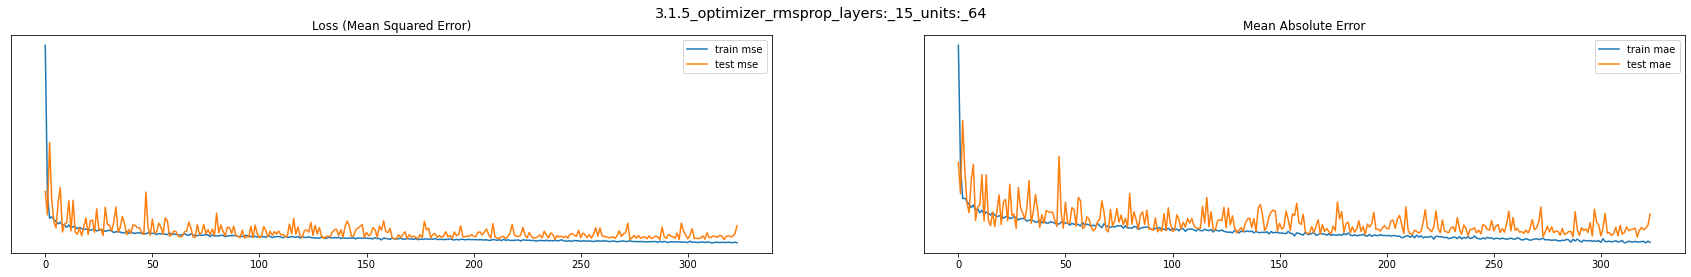

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_15_unit...              19.987   
1  test:_3.1.5_optimizer_rmsprop_layers:_15_units...              24.118   
2       3.1.5_optimizer_rmsprop_layers:_15_units:_64               4.131   

   mean_absolute_error  r2_score  e_v_score  
0                3.319    93.118     94.206  
1                3.677    91.773     92.886  
2                0.359     1.345      1.320  

Epoch 1: val_loss improved from inf to 0.03845, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_15_units:_128.hdf5

Epoch 2: val_loss improved from 0.03845 to 0.03044, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_15_units:_128.hdf5

Epoch 3: val_loss did not improve from 0.03044

Epoch 4: val_loss did not improve from 0.03044

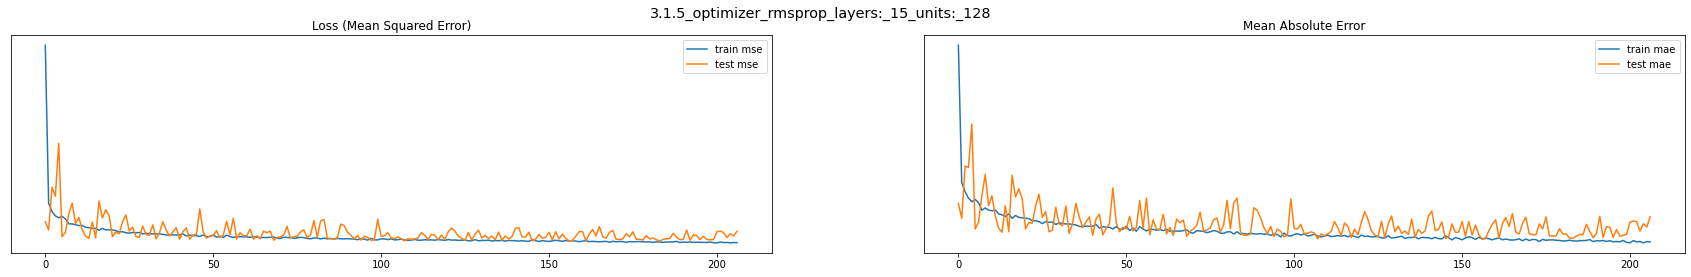

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_15_unit...              22.392   
1  test:_3.1.5_optimizer_rmsprop_layers:_15_units...              23.447   
2      3.1.5_optimizer_rmsprop_layers:_15_units:_128               1.055   

   mean_absolute_error  r2_score  e_v_score  
0                3.806    92.290     92.350  
1                3.860    92.002     92.043  
2                0.054     0.288      0.307  

Epoch 1: val_loss improved from inf to 0.36528, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_20_units:_6.hdf5

Epoch 2: val_loss improved from 0.36528 to 0.36458, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_20_units:_6.hdf5

Epoch 3: val_loss did not improve from 0.36458

Epoch 4: val_loss improved from 0.36458 to 0.36457

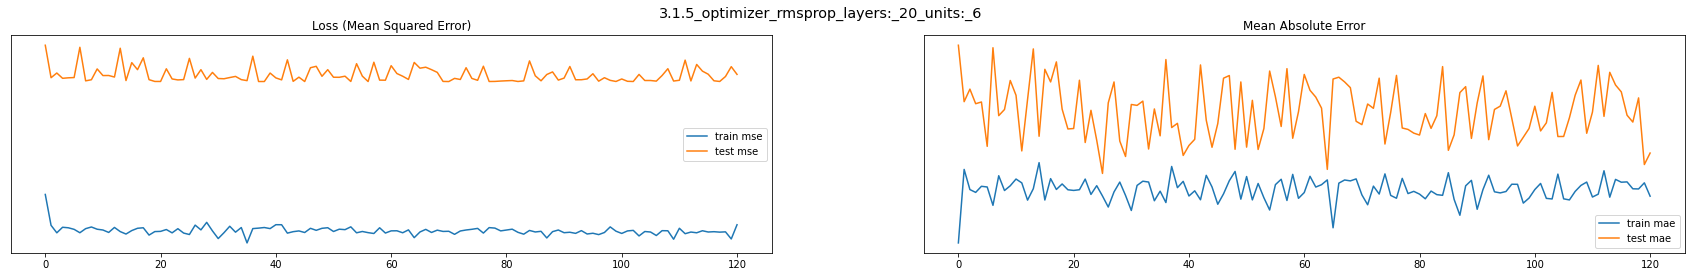

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_20_unit...             290.676   
1  test:_3.1.5_optimizer_rmsprop_layers:_20_units:_6             293.284   
2        3.1.5_optimizer_rmsprop_layers:_20_units:_6               2.609   

   mean_absolute_error  r2_score  e_v_score  
0               14.780    -0.085        0.0  
1               14.854    -0.043        0.0  
2                0.074    -0.042        0.0  

Epoch 1: val_loss improved from inf to 0.36454, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_20_units:_8.hdf5

Epoch 2: val_loss improved from 0.36454 to 0.36450, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_20_units:_8.hdf5

Epoch 3: val_loss did not improve from 0.36450

Epoch 4: val_loss did not improve from 0.36450

Ep

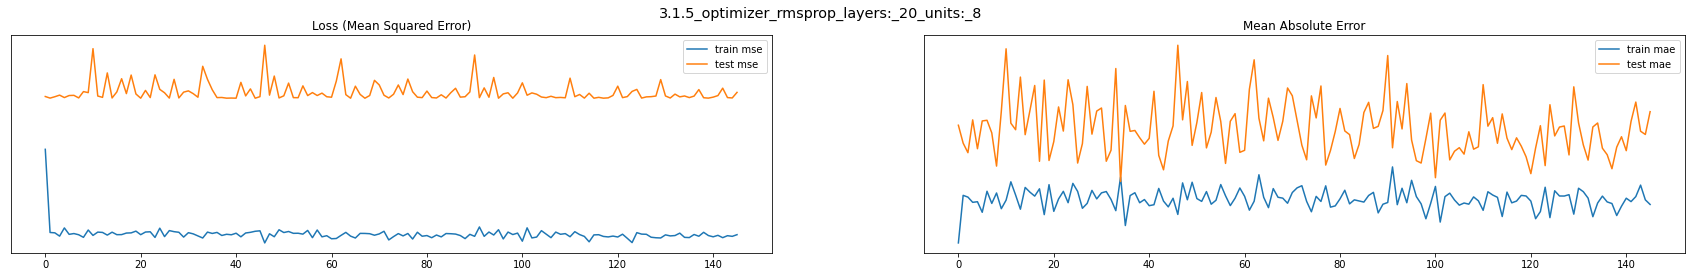

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_20_unit...             290.464   
1  test:_3.1.5_optimizer_rmsprop_layers:_20_units:_8             293.272   
2        3.1.5_optimizer_rmsprop_layers:_20_units:_8               2.808   

   mean_absolute_error  r2_score  e_v_score  
0               14.834    -0.012        0.0  
1               14.910    -0.038        0.0  
2                0.076     0.026        0.0  

Epoch 1: val_loss improved from inf to 0.36427, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_20_units:_16.hdf5

Epoch 2: val_loss improved from 0.36427 to 0.31673, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_20_units:_16.hdf5

Epoch 3: val_loss improved from 0.31673 to 0.11734, saving model to /content/drive/MyDrive/Colab

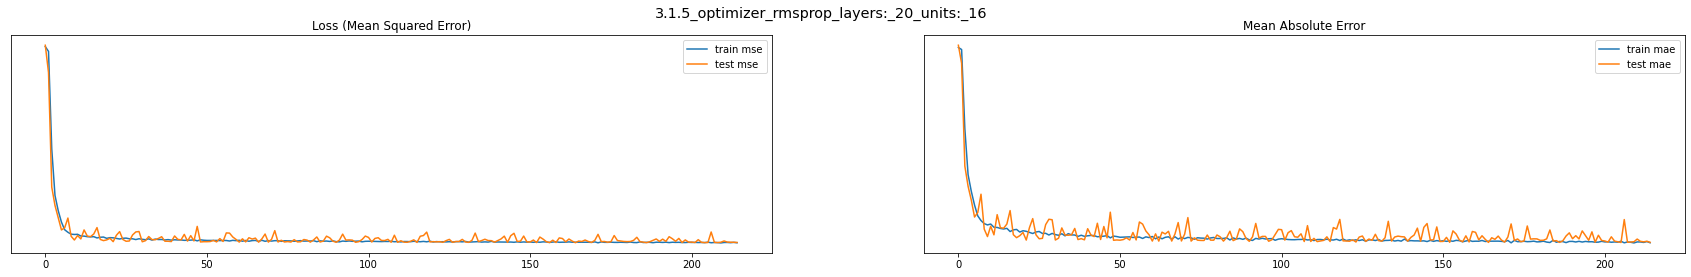

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_20_unit...              15.590   
1  test:_3.1.5_optimizer_rmsprop_layers:_20_units...              16.823   
2       3.1.5_optimizer_rmsprop_layers:_20_units:_16               1.233   

   mean_absolute_error  r2_score  e_v_score  
0                2.978    94.632     94.663  
1                3.104    94.262     94.293  
2                0.126     0.370      0.370  

Epoch 1: val_loss improved from inf to 0.10698, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_20_units:_32.hdf5

Epoch 2: val_loss improved from 0.10698 to 0.09650, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_20_units:_32.hdf5

Epoch 3: val_loss improved from 0.09650 to 0.04650, saving model to /content/drive/MyDrive/Colab

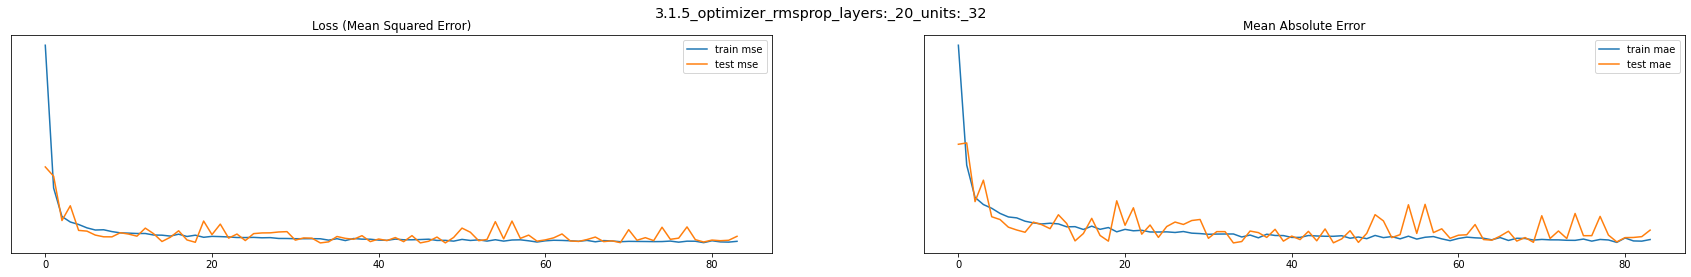

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_20_unit...              21.781   
1  test:_3.1.5_optimizer_rmsprop_layers:_20_units...              23.055   
2       3.1.5_optimizer_rmsprop_layers:_20_units:_32               1.274   

   mean_absolute_error  r2_score  e_v_score  
0                3.598    92.500     94.431  
1                3.702    92.136     94.048  
2                0.105     0.364      0.383  

Epoch 1: val_loss improved from inf to 0.11510, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_20_units:_64.hdf5

Epoch 2: val_loss improved from 0.11510 to 0.04942, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_20_units:_64.hdf5

Epoch 3: val_loss did not improve from 0.04942

Epoch 4: val_loss did not improve from 0.04942



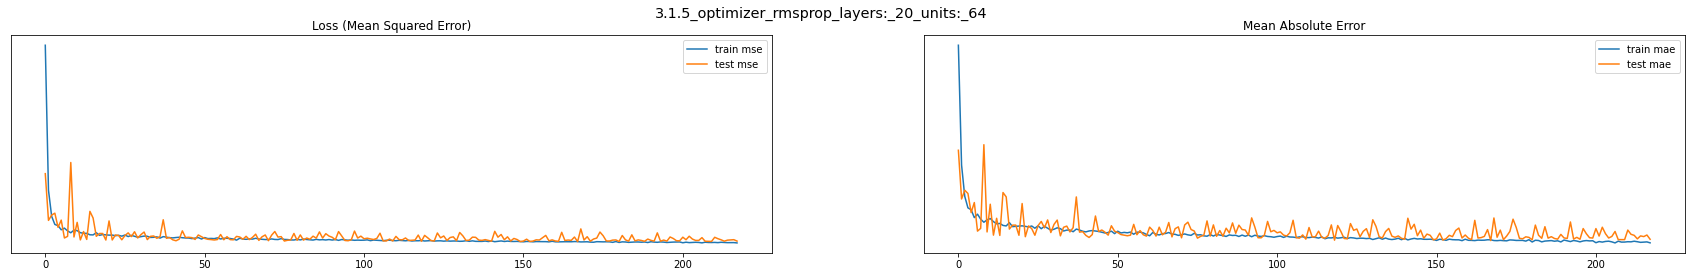

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_20_unit...              14.020   
1  test:_3.1.5_optimizer_rmsprop_layers:_20_units...              16.356   
2       3.1.5_optimizer_rmsprop_layers:_20_units:_64               2.336   

   mean_absolute_error  r2_score  e_v_score  
0                2.822    95.173     95.195  
1                3.035    94.421     94.446  
2                0.214     0.752      0.749  

Epoch 1: val_loss improved from inf to 0.11698, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_20_units:_128.hdf5

Epoch 2: val_loss improved from 0.11698 to 0.06820, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.5_optimizer_rmsprop_layers:_20_units:_128.hdf5

Epoch 3: val_loss improved from 0.06820 to 0.06268, saving model to /content/drive/MyDrive/Col

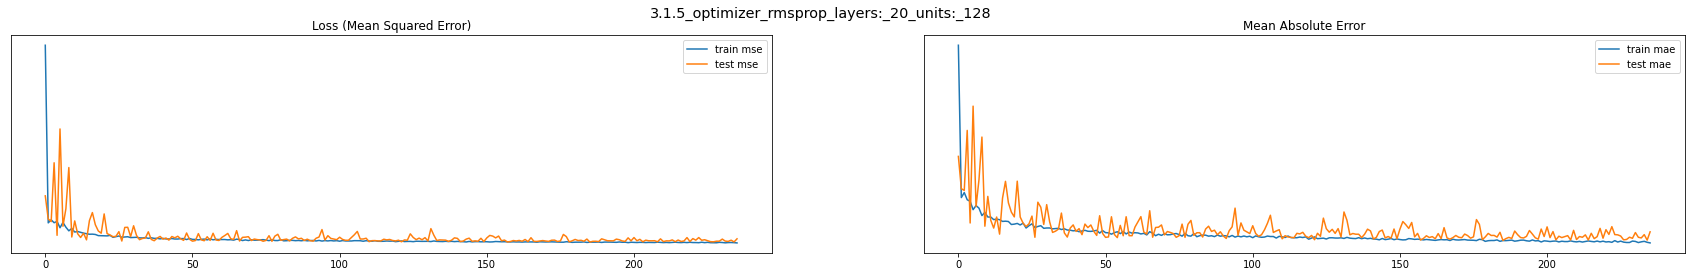

                                                type  mean_squared_error  \
0  train:_3.1.5_optimizer_rmsprop_layers:_20_unit...              18.543   
1  test:_3.1.5_optimizer_rmsprop_layers:_20_units...              21.161   
2      3.1.5_optimizer_rmsprop_layers:_20_units:_128               2.618   

   mean_absolute_error  r2_score  e_v_score  
0                3.266    93.615     94.650  
1                3.504    92.782     93.867  
2                0.238     0.833      0.783  


In [ ]:
rcpr_transformer = FunctionTransformer(lambda x: 1/x, validate = True)
yj_transformer = PowerTransformer(method = 'yeo-johnson', standardize = False)

pipe_complex = define_pipeline_complex(RobustScaler(),yj_transformer, rcpr_transformer, False, True)
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_complex, KNNImputer(n_neighbors=2), True, True)
nlayers = [2,4,6,8,10,15,20]
units = [6,8,16,32,64,128]
for nl in nlayers:
  for u in units:
    complete_run (f"3.1.5_optimizer_rmsprop_layers:_{nl}_units:_{u}", pipe, opt = 'RMSprop', n_layers = nl, unt = u)

In [ ]:
show_results(False)

MSE 
 
 
   
 modelName 
 train_mse 
 test_mse 
 difference 
 
 
 
 
 23 
 3.1.5_optimizer_rmsprop_layers:_8_units:_128 
 11.167 
 15.052 
 3.885 
 
 
 17 
 3.1.5_optimizer_rmsprop_layers:_6_units:_128 
 11.931 
 15.295 
 3.364 
 
 
 9 
 3.1.5_optimizer_rmsprop_layers:_4_units:_32 
 13.504 
 15.541 
 2.037 
 
 
 11 
 3.1.5_optimizer_rmsprop_layers:_4_units:_128 
 12.943 
 15.733 
 2.791 
 
 
 4 
 3.1.5_optimizer_rmsprop_layers:_2_units:_64 
 13.074 
 15.844 
 2.770 
 
 
 2 
 3.1.5_optimizer_rmsprop_layers:_2_units:_16 
 15.122 
 16.084 
 0.962 
 
 
 26 
 3.1.5_optimizer_rmsprop_layers:_10_units:_16 
 14.461 
 16.328 
 1.866 
 
 
 5 
 3.1.5_optimizer_rmsprop_layers:_2_units:_128 
 12.399 
 16.345 
 3.946 
 
 
 40 
 3.1.5_optimizer_rmsprop_layers:_20_units:_64 
 14.020 
 16.356 
 2.336 
 
 
 8 
 3.1.5_optimizer_rmsprop_layers:_4_units:_16 
 15.067 
 16.411 
 1.344 
 
 
 21 
 3.1.5_optimizer_rmsprop_layers:_8_units:_32 
 13.777 
 16.675 
 2.897 
 
 
 7 
 3.1.5_optimizer_rmsprop_layers:_4_units:_8 
 15.872 
 16.724 
 0.852 
 
 
 27 
 3.1.5_optimizer_rmsprop_layers:_10_units:_32 
 15.237 
 16.758 
 1.520 
 
 
 38 
 3.1.5_optimizer_rmsprop_layers:_20_units:_16 
 15.590 
 16.823 
 1.233 
 
 
 3 
 3.1.5_optimizer_rmsprop_layers:_2_units:_32 
 15.059 
 16.920 
 1.861 
 
 
 29 
 3.1.5_optimizer_rmsprop_layers:_10_units:_128 
 14.776 
 17.122 
 2.345 
 
 
 31 
 3.1.5_optimizer_rmsprop_layers:_15_units:_8 
 16.653 
 17.224 
 0.571 
 
 
 1 
 3.1.5_optimizer_rmsprop_layers:_2_units:_8 
 16.594 
 17.329 
 0.735 
 
 
 0 
 3.1.5_optimizer_rmsprop_layers:_2_units:_6 
 17.057 
 17.485 
 0.428 
 
 
 14 
 3.1.5_optimizer_rmsprop_layers:_6_units:_16 
 15.747 
 17.509 
 1.762 
 
 
 6 
 3.1.5_optimizer_rmsprop_layers:_4_units:_6 
 17.039 
 17.695 
 0.656 
 
 
 13 
 3.1.5_optimizer_rmsprop_layers:_6_units:_8 
 17.191 
 17.808 
 0.617 
 
 
 32 
 3.1.5_optimizer_rmsprop_layers:_15_units:_16 
 16.601 
 18.016 
 1.415 
 
 
 15 
 3.1.5_optimizer_rmsprop_layers:_6_units:_32 
 16.270 
 18.171 
 1.901 
 
 
 22 
 3.1.5_optimizer_rmsprop_layers:_8_units:_64 
 15.855 
 18.514 
 2.659 
 
 
 25 
 3.1.5_optimizer_rmsprop_layers:_10_units:_8 
 17.620 
 18.620 
 1.000 
 
 
 12 
 3.1.5_optimizer_rmsprop_layers:_6_units:_6 
 18.273 
 18.987 
 0.714 
 
 
 33 
 3.1.5_optimizer_rmsprop_layers:_15_units:_32 
 17.299 
 19.065 
 1.766 
 
 
 20 
 3.1.5_optimizer_rmsprop_layers:_8_units:_16 
 17.841 
 19.177 
 1.336 
 
 
 24 
 3.1.5_optimizer_rmsprop_layers:_10_units:_6 
 18.524 
 19.206 
 0.682 
 
 
 28 
 3.1.5_optimizer_rmsprop_layers:_10_units:_64 
 16.897 
 19.519 
 2.621 
 
 
 18 
 3.1.5_optimizer_rmsprop_layers:_8_units:_6 
 19.203 
 19.876 
 0.673 
 
 
 10 
 3.1.5_optimizer_rmsprop_layers:_4_units:_64 
 16.419 
 20.093 
 3.674 
 
 
 19 
 3.1.5_optimizer_rmsprop_layers:_8_units:_8 
 19.838 
 20.540 
 0.702 
 
 
 41 
 3.1.5_optimizer_rmsprop_layers:_20_units:_128 
 18.543 
 21.161 
 2.618 
 
 
 39 
 3.1.5_optimizer_rmsprop_layers:_20_units:_32 
 21.781 
 23.055 
 1.274 
 
 
 35 
 3.1.5_optimizer_rmsprop_layers:_15_units:_128 
 22.392 
 23.447 
 1.055 
 
 
 34 
 3.1.5_optimizer_rmsprop_layers:_15_units:_64 
 19.987 
 24.118 
 4.131 
 
 
 16 
 3.1.5_optimizer_rmsprop_layers:_6_units:_64 
 20.456 
 24.147 
 3.691 
 
 
 30 
 3.1.5_optimizer_rmsprop_layers:_15_units:_6 
 290.429 
 293.194 
 2.765 
 
 
 37 
 3.1.5_optimizer_rmsprop_layers:_20_units:_8 
 290.464 
 293.272 
 2.808 
 
 
 36 
 3.1.5_optimizer_rmsprop_layers:_20_units:_6 
 290.676 
 293.284 
 2.609 
 
 
 
____

 
 MAE 
 
 
   
 modelName 
 train_mae 
 test_mae 
 difference 
 
 
 
 
 17 
 3.1.5_optimizer_rmsprop_layers:_6_units:_128 
 2.543 
 2.874 
 0.331 
 
 
 23 
 3.1.5_optimizer_rmsprop_layers:_8_units:_128 
 2.499 
 2.903 
 0.404 
 
 
 9 
 3.1.5_optimizer_rmsprop_layers:_4_units:_32 
 2.744 
 2.927 
 0.183 
 
 
 5 
 3.1.5_optimizer_rmsprop_layers:_2_units:_128 
 2.596 
 2.975 
 0.379 
 
 
 11 
 3.1.5_optimizer_rmsprop_layers:_4_units:_128 
 2.721 
 2.981 
 0.260 
 
 
 4 
 3.1.5_optimizer_rmsprop_layers:_2_units:

<Figure size 2880x1080 with 0 Axes>

### Optimizer  Results

In [ ]:
update_results(True)
show_results(False)

MSE 
 
 
   
 modelName 
 train_mse 
 test_mse 
 difference 
 
 
 
 
 6 
 No3.1.1_Adam_layers:_2_units:_32 
 12.987 
 15.232 
 2.245 
 
 
 8 
 No3.1.1_Adam_layers:_6_units:_32 
 12.322 
 15.302 
 2.980 
 
 
 7 
 No3.1.1_Adam_layers:_6_units:_16 
 13.874 
 15.533 
 1.658 
 
 
 13 
 3.1.5_optimizer_rmsprop_layers:_4_units:_32 
 13.504 
 15.541 
 2.037 
 
 
 12 
 3.1.5_optimizer_rmsprop_layers:_4_units:_128 
 12.943 
 15.733 
 2.791 
 
 
 5 
 3.1.3_optimizer_sgd_layers:_10_units:_128 
 15.029 
 16.038 
 1.009 
 
 
 3 
 3.1.2_Adagrad_layers:_20_units:_128 
 14.601 
 16.052 
 1.450 
 
 
 2 
 3.1.2_Adagrad_layers:_15_units:_128 
 15.314 
 16.187 
 0.873 
 
 
 4 
 3.1.3_optimizer_sgd_layers:_8_units:_64 
 15.106 
 16.218 
 1.112 
 
 
 1 
 RS_RH_AP_winsorize_RCPR_na_ann_knn 
 16.928 
 17.442 
 0.514 
 
 
 0 
 base_ann 
 16.975 
 17.756 
 0.781 
 
 
 9 
 3.1.4_optimizer_adadelta_layers:_20_units:_128 
 17.462 
 17.835 
 0.374 
 
 
 10 
 3.1.4_optimizer_adadelta_layers:_15_units:_128 
 17.913 
 18.108 
 0.194 
 
 
 11 
 3.1.4_optimizer_adadelta_layers:_10_units:_128 
 17.751 
 18.298 
 0.547 
 
 
 
____

 
 MAE 
 
 
   
 modelName 
 train_mae 
 test_mae 
 difference 
 
 
 
 
 8 
 No3.1.1_Adam_layers:_6_units:_32 
 2.598 
 2.888 
 0.290 
 
 
 6 
 No3.1.1_Adam_layers:_2_units:_32 
 2.699 
 2.915 
 0.216 
 
 
 13 
 3.1.5_optimizer_rmsprop_layers:_4_units:_32 
 2.744 
 2.927 
 0.183 
 
 
 7 
 No3.1.1_Adam_layers:_6_units:_16 
 2.790 
 2.947 
 0.157 
 
 
 12 
 3.1.5_optimizer_rmsprop_layers:_4_units:_128 
 2.721 
 2.981 
 0.260 
 
 
 3 
 3.1.2_Adagrad_layers:_20_units:_128 
 2.903 
 3.042 
 0.140 
 
 
 5 
 3.1.3_optimizer_sgd_layers:_10_units:_128 
 2.949 
 3.050 
 0.101 
 
 
 4 
 3.1.3_optimizer_sgd_layers:_8_units:_64 
 2.955 
 3.072 
 0.117 
 
 
 2 
 3.1.2_Adagrad_layers:_15_units:_128 
 2.986 
 3.088 
 0.102 
 
 
 0 
 base_ann 
 3.156 
 3.207 
 0.051 
 
 
 1 
 RS_RH_AP_winsorize_RCPR_na_ann_knn 
 3.180 
 3.231 
 0.051 
 
 
 9 
 3.1.4_optimizer_adadelta_layers:_20_units:_128 
 3.194 
 3.232 
 0.037 
 
 
 11 
 3.1.4_optimizer_adadelta_layers:_10_units:_128 
 3.259 
 3.275 
 0.017 
 
 
 10 
 3.1.4_optimizer_adadelta_layers:_15_units:_128 
 3.275 
 3.284 
 0.009 
 
 
 
____
 
 r2score 
 
 
   
 modelName 
 train_r2score 
 test_r2score 
 difference 
 
 
 
 
 6 
 No3.1.1_Adam_layers:_2_units:_32 
 95.528 
 94.804 
 0.724 
 
 
 8 
 No3.1.1_Adam_layers:_6_units:_32 
 95.757 
 94.780 
 0.977 
 
 
 7 
 No3.1.1_Adam_layers:_6_units:_16 
 95.223 
 94.702 
 0.521 
 
 
 13 
 3.1.5_optimizer_rmsprop_layers:_4_units:_32 
 95.350 
 94.699 
 0.651 
 
 
 12 
 3.1.5_optimizer_rmsprop_layers:_4_units:_128 
 95.544 
 94.633 
 0.911 
 
 
 5 
 3.1.3_optimizer_sgd_layers:_10_units:_128 
 94.825 
 94.529 
 0.296 
 
 
 3 
 3.1.2_Adagrad_layers:_20_units:_128 
 94.972 
 94.525 
 0.447 
 
 
 2 
 3.1.2_Adagrad_layers:_15_units:_128 
 94.727 
 94.478 
 0.249 
 
 
 4 
 3.1.3_optimizer_sgd_layers:_8_units:_64 
 94.799 
 94.468 
 0.331 
 
 
 1 
 RS_RH_AP_winsorize_RCPR_na_ann_knn 
 94.172 
 94.050 
 0.122 
 
 
 0 
 base_ann 
 94.155 
 93.943 
 0.212 
 
 
 9 
 3.1.4_optimizer_adadelta_layers:_20_units:_128 
 93.988 
 93.916 
 0.072 
 
 
 10 
 3.1.4_optimizer_adadelta_layers:_15_units:_128 
 93.832 
 93.823 
 0.009 
 
 
 11 
 3.1.4_optimizer_adadelta_layers:_10_units:_128 
 93.888 
 93.758 
 0.130 
 
 
 
____
 
 EVS 
 
 
   
 modelName 
 train_evs 
 test_evs 
 difference 
 
 
 
 
 8 
 No3.1.1_Adam_layers:_6_units:_32 
 95.856 
 94.862 
 0.994 
 
 
 6 
 No3.1.1_Adam_layers:_2_units:_32 
 95.567 
 94.847 
 0.720 
 
 
 12 
 3.1.5_optimizer_rmsprop_layers:_4_units:_128 
 95.762 
 94.847 
 0.915 
 
 
 7 
 No3.1.1_Adam_layers:_6_units:_16 
 95.267 
 94.741 
 0.526 
 
 
 13 
 3.1.5_optimizer_rmsprop_layers:_4_units:_32 
 95.364 
 94.710 
 0.654 
 
 
 3 
 3.1.2_Adagrad_layers:_20_units:_128 
 95.000 
 94.550 
 0.450 
 
 
 5 
 3.1.3_optimizer_sgd_layers:_10_units:_128 
 94.829 
 94.532 
 0.297 
 
 
 2 
 3.1.2_Adagrad_layers:_15_units:_128 
 94.775 
 94.530 
 0.245 
 
 
 4 
 3.1.3_o

<Figure size 2880x1080 with 0 Axes>

From the results above it can be clearly seen that adam optimizer from base model has shown optimal results with difference between train and test results in mse < 3. 

Although RMSProp has shown also good results, considering learning courves, model training was unstable and this optimizer wont be trained further.

Model with Adam optimizer will be trained further.